Notebook initialization:

You need to run the next 3 cells!

In [3]:
# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import math
from astropy.io import fits
import pandas as pd

import uncertainties as un
from uncertainties import unumpy

from scipy.optimize import fmin


font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

Common settings for cosmological parameters and other CLASS parameters

In [2]:
common_settings = {
                   'output':'tCl,pCl,lCl',
                   # LambdaCDM parameters
                   'h':0.67556,
                   'omega_b':0.022032,
                   'omega_cdm':0.12038,
                   'A_s':2.215e-9,
                   'tau_reio':0.0925,
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
                   'YHe':0.246,
                   'mass function' : 'T10',
                   'integrate_wrt_m200m' : 1
                   
}


p18_cosmo = {
    
     # P18 1st column table 1 of https://arxiv.org/pdf/1807.06209.pdf
    'omega_b': 0.022383,
    'omega_cdm': 0.12011,
    'h': 0.6732,
    'tau_reio': 0.0543,
    'ln10^{10}A_s': 3.0448,
    'n_s': 0.96605,
    'k_pivot': 0.05,
    'N_ncdm': 1,
    'N_ur': 2.0328,
    'm_ncdm': 0.06
}
factor_sz = 1e-2

In [5]:
# copied from : https://github.com/simonsobs/websky_model/blob/a93bbf758432a936c0ec2b59775683b695d3d191/websky_model/websky.py#L55
websky_Omega_M = 0.31
websky_Omega_B = 0.049
websky_Omega_L = 0.69
websky_h = 0.68
websky_sigma_8 = 0.81
websky_n_s = 0.965


websky_cosmo = {
    'omega_b': websky_Omega_B*websky_h**2.,
    'omega_cdm': (websky_Omega_M-websky_Omega_B)*websky_h**2.,
    'h': websky_h,
    'tau_reio': 0.0543,
    'sigma8': websky_sigma_8,
    'n_s': websky_n_s,   
}


omegab = websky_Omega_B
omegac = websky_Omega_M-websky_Omega_B
omegam = omegab + omegac
h      = websky_h
ns     = websky_n_s
sigma8 = websky_sigma_8

c = 3e5

H0 = 100*h
nz = 100000
z1 = 0.0
z2 = 6.0
za = np.linspace(z1,z2,nz)
dz = za[1]-za[0]

H      = lambda z: H0*np.sqrt(omegam*(1+z)**3+1-omegam)
dchidz = lambda z: c/H(z)

chia = np.cumsum(dchidz(za))*dz

zofchi = interp1d(chia,za)

print(websky_Omega_B*websky_h**2.)
print(omegac)

0.022657600000000007
0.261


In [4]:
M = Class()
M.set(websky_cosmo)
has_selfn = 1
snrcut = 6.
M.set({
          'non linear': 'halofit',
#           'output' :'sz_cluster_counts,m200m_to_m500c',
          'output' :'sz_cluster_counts, m200m_to_m500c',
          'mass function' : 'T08',
          #'integrate_wrt_m200m' : 1,
          'concentration parameter': 'B13',
          'has_selection_function' : has_selfn,
          'sky area in deg2': 41253.,
#     'sky area in deg2': 599.,
          'experiment' : 1, # simons observatory 1
          'y_m_relation' : 1,
          'signal-to-noise cut-off for survey cluster completeness' : snrcut,
#           'SO_skyfracs_file': "/sz_auxiliary_files/so_3freqs_120921_pass2_skyfracs.txt",
#           'SO_ylims_file': "/sz_auxiliary_files/so_3freqs_120921_pass2_ylims.txt",
#           'SO_thetas_file': "/sz_auxiliary_files/so_3freqs_120921_pass2_thetas.txt",

          'M_min' : 8.06216e+13,#*websky_h, # bounds in websky:8.06216e+13 2.35569e+15, in matt's file m200mUncorr in Msun/h:1.11329e+14 2.17657e+15, Upp: 9.70934e+13 2.17039e+15
          'M_max' : 2.35569e+15,
          'B': 1.,

          'N_ur': 2.0328,
          'N_ncdm': 1,
          'm_ncdm': 0.0,
          'T_ncdm': 0.71611,
          'input_verbose' : 0,
          'background_verbose': 0,
          'perturbations_verbose': 0,
          'sz_verbose'  : 0,

          'bin_z_min_cluster_counts' : 0.,
          'bin_z_max_cluster_counts' : 2.,
          'bin_dz_cluster_counts' : 0.1,
          'bin_dlog10_snr': 0.25,

          'dlny' : 0.01,
          'lnymin' : -13., # planck  -11.5 so -11
          'lnymax' : -3.,  # planck 10. so -5
          'dlnM_cluster_count_completeness_grid' : 0.005,


          'cluster_count_completeness_grid_z_cutoff_low' : 0.4,
          'cluster_count_completeness_grid_z_cutoff_mid' : 1.,

          'dz_cluster_count_completeness_grid_low_z' : 1e-3,
          'dz_cluster_count_completeness_grid_mid_z' : 1e-2,
          'dz_cluster_count_completeness_grid_high_z' : 1e-1,



          'mass_epsrel_cluster_counts' : 1e-6,
          'mass_epsabs_cluster_counts' : 1e-40,

          'redshift_epsrel_cluster_counts' : 1e-4,
          'redshift_epsabs_cluster_counts' : 1e-40,
    #a=4.56036e-01 b=-3.869082e-02
          'A_ym': 4.35e-05,#4.35e-05,#4.68912e-05,#4.35e-05,#4.62e-05,#A_ym_websky,4.68912e-05 b=1.054969e+00
          'B_ym':0.08,#0.08,#5.496869e-02, #0.08, #B_ym_websky,
          'C_ym' : 0.,
          'sigmaM_ym' : 0.,
    

#           # # tabulation of mass function:
          'n_z_dndlnM' : 200,
          'n_m_dndlnM' : 200,
#           #
#           # # computation of mass function
#           # # (grid in mass and redshifts for sigma and dsigma)
          'ndim_masses' : 200,
          'ndim_redshifts' : 200,

#           # pk setup for computation of sigma and dsigma
    
          'k_per_decade_class_sz' : 40., #important parameter
          'k_min_for_pk_class_sz' : 1e-4,
          'k_max_for_pk_class_sz' : 10.,

          'P_k_max_h/Mpc' : 2e1
    
})
M.compute()
print(M.sigma8())
print(M.get_sigma8_at_z(0.0002))
# print(M.get_sigma8_at_z(0.0))

0.8100000957137263
0.8103065815754312


In [5]:
dNdzdy_theoretical = M.dndzdy_theoretical()['dndzdy']
z_center = M.dndzdy_theoretical()['z_center']
z_edges = M.dndzdy_theoretical()['z_edges']
log10y_center = M.dndzdy_theoretical()['log10y_center']
log10y_edges = M.dndzdy_theoretical()['log10y_edges']
# M.struct_cleanup()
# M.empty()

In [6]:
np.sum(dNdzdy_theoretical)

25219.054150789365

In [7]:
#m200ms = np.geomspace(1e12,1e15)
#m500ms = np.vectorize(M.get_m200m_to_m500c_at_z_and_M)(1e-5,m200ms)

In [7]:
N_z,N_y = np.shape(dNdzdy_theoretical)
N_clusters_z_theory = []
N_clusters_z_theory_actlike = []
# N_clusters_z_theory_plancklike = []
for iz in range(N_z):
    if (has_selfn == 1):
        N_clusters_z_theory.append(np.sum(dNdzdy_theoretical[iz]))
    elif (has_selfn == 0):
        N_clusters_z_theory.append(dNdzdy_theoretical[iz][0])
#     N_clusters_z_theory_actlike.append(np.sum(dNdzdy_theoretical[iz])/4.)
#     N_clusters_z_theory_plancklike.append(np.sum(dNdzdy_theoretical[iz])/25.)
N_clusters_y_theory = []
for iy in range(N_y):
    N_clusters_y_theory.append(np.sum(np.asarray(dNdzdy_theoretical)[:,iy]))




In [8]:
np.sum(N_clusters_z_theory)

25219.054150789372

In [9]:
# here puth the path to the directory : MFMF_SOSim_3freq_tiles
# path_to_catalogue = '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_external_data_and_scripts/MFMF_SOSim_3freq_tiles/'
# path_to_catalogue = '/Users/boris/Work/CLASS-SZ/SO-SZ/so_cluster_counts/MFMF_WebSkyHalos_A10tSZ_3freq_tiles/'
path_to_catalogue = '/Users/boris/Work/CLASS-SZ/SO-SZ/so_cluster_counts/MFMF_WebSkyHalos_A10tSZ_3freq_tiles_pass2/MFMF_WebSkyHalos_A10tSZ_3freq_tiles/'

#"fits_image_filename = fits.util.get_testdata_filepath(path_to_catalogue+'MFMF_SOSim_3freq_tiles_M500.fits')
tcat = path_to_catalogue+'MFMF_WebSkyHalos_A10tSZ_3freq_tiles_mass.fits'
# tcat = path_to_catalogue+'WebSky_A10_mock.fits'
# tcat = path_to_catalogue+'MFMF_WebSkyHalos_A10tSZ_3freq_tiles_optimalCatalog.fits'
list = fits.open(tcat)
data = list[1].data
z = data.field("redshift")
snr = data.field("fixed_SNR")
# snr = np.sqrt(snr**2-3.)
tile = data.field("tileName")
m500c = data.field('M500c')
m500c = m500c[snr > snrcut]
z = z[snr > snrcut]
# snr = np.sqrt(snr[snr > snrcut]**2-3.)
snr = snr[snr > snrcut]
sf = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/so_3freqs_120921_pass2_skyfracs.txt')
print('sky fraction:',sf.sum())
print('area:',sf.sum()*41253.)
print('N clusters:',z.size,snr.size)

sky fraction: 0.43353265345590863
area: 17884.5225530166
N clusters: 25840 25840


In [39]:
print(data.columns)
df_matt = {
#      "y_c": data.field("y_c").byteswap().newbyteorder(),
    "redshift": data.field("redshift").byteswap().newbyteorder(),
#       "err_y_c": data.field("err_y_c").byteswap().newbyteorder(),
    "M500c": data.field("M500c").byteswap().newbyteorder(),
     "M200m": data.field("M200m").byteswap().newbyteorder(),
    "M200mUncorr": data.field("M200mUncorr").byteswap().newbyteorder(),
#      "SNR": data.field("SNR").byteswap().newbyteorder(),
      "name":data.field("name").byteswap().newbyteorder(),
     'fixed_y_c': data.field('fixed_y_c').byteswap().newbyteorder(),
#      "fixed_SNR": data.field("fixed_SNR").byteswap().newbyteorder(),
#      "decDeg":data.field("decDeg").byteswap().newbyteorder()}
}
df_matt = pd.DataFrame(df_matt)
df_matt

ColDefs(
    name = 'name'; format = '18A'
    name = 'RADeg'; format = 'D'
    name = 'decDeg'; format = 'D'
    name = 'SNR'; format = 'D'
    name = 'numSigPix'; format = 'D'
    name = 'template'; format = '17A'
    name = 'tileName'; format = '7A'
    name = 'galacticLatDeg'; format = 'D'
    name = 'fixed_SNR'; format = 'D'
    name = 'deltaT_c'; format = 'D'
    name = 'err_deltaT_c'; format = 'D'
    name = 'y_c'; format = 'D'
    name = 'err_y_c'; format = 'D'
    name = 'fixed_deltaT_c'; format = 'D'
    name = 'fixed_err_deltaT_c'; format = 'D'
    name = 'fixed_y_c'; format = 'D'
    name = 'fixed_err_y_c'; format = 'D'
    name = 'tileBoundarySplit'; format = 'L'
    name = 'redshift'; format = 'D'
    name = 'redshiftErr'; format = 'K'
    name = 'M500c'; format = 'D'
    name = 'M500c_errPlus'; format = 'D'
    name = 'M500c_errMinus'; format = 'D'
    name = 'M500cUncorr'; format = 'D'
    name = 'M500cUncorr_errPlus'; format = 'D'
    name = 'M500cUncorr_errMinus'; for

,redshift,M500c,M200m,M200mUncorr,name,fixed_y_c
0,1.230438,2.955487,5.095571,5.167807,SO-CL J0000.0-0207,0.919446
1,1.025901,1.765854,2.989484,3.111658,SO-CL J0000.0-5006,0.411763
2,0.552456,1.414709,2.434125,2.578501,SO-CL J0000.0-5910,0.281209
3,0.311749,2.741794,5.018612,5.086296,SO-CL J0000.0-6015,0.664135
4,0.918096,1.485587,2.504392,2.694182,SO-CL J0000.1-0433,0.310615
...,...,...,...,...,...,...
62470,0.218872,2.721106,5.130395,5.262443,SO-CL J2359.9-1352,0.676967
62471,0.367818,1.623578,2.894354,3.053372,SO-CL J2359.9-1730,0.352899
62472,0.366927,1.985134,3.555533,3.695926,SO-CL J2359.9-1923,0.452226
62473,0.609075,4.257110,7.453453,7.522022,SO-CL J2359.9-3559,1.205494


In [46]:
"%.5e"%(df_matt['M200mUncorr'].min()*websky_h*1e14)

'1.11329e+14'

In [48]:
"%.5e"%(df_matt['M200mUncorr'].max()*websky_h*1e14)

'2.17657e+15'

In [36]:
"%.5e"%(df_matt['M200m'].min()*websky_h*1e14)

'9.70934e+13'

In [37]:
"%.5e"%(df_matt['M200m'].max()*websky_h*1e14)

'2.17039e+15'

In [63]:
df_matt['name'] = df_matt['name'].apply(lambda x: x.replace('SO-CL','MOCK-CL'))

In [64]:
df_matt['name']

0        MOCK-CL J0000.0-0207
1        MOCK-CL J0000.0-5006
2        MOCK-CL J0000.0-5910
3        MOCK-CL J0000.0-6015
4        MOCK-CL J0000.1-0433
                 ...         
62470    MOCK-CL J2359.9-1352
62471    MOCK-CL J2359.9-1730
62472    MOCK-CL J2359.9-1923
62473    MOCK-CL J2359.9-3559
62474    MOCK-CL J2359.9-4029
Name: name, Length: 62475, dtype: object

In [65]:
df_merges['name']

0         MOCK-CL J0212.9-4204
1         MOCK-CL J1350.1+1422
2         MOCK-CL J1730.0+1647
3         MOCK-CL J0742.3-0732
4         MOCK-CL J0927.0+0325
                  ...         
156135    MOCK-CL J0440.7-3441
156136    MOCK-CL J2334.5-4015
156137    MOCK-CL J0428.4-5420
156138    MOCK-CL J2157.9-1310
156139    MOCK-CL J1119.0-1616
Name: name, Length: 156140, dtype: object

In [66]:
df_all = pd.merge(df_matt,df_nemo, how='inner',on='name')

In [67]:
df_all

,redshift_x,M500c,name,fixed_y_c,redshift_y,true_M500c,true_fixed_y_c
0,1.230438,2.955487,MOCK-CL J0000.0-0207,0.919446,1.230581,2.404232,0.666512
1,1.230438,2.955487,MOCK-CL J0000.0-0207,0.919446,1.230438,1.810920,0.432832
2,1.025901,1.765854,MOCK-CL J0000.0-5006,0.411763,1.025901,1.916257,0.431377
3,0.552456,1.414709,MOCK-CL J0000.0-5910,0.281209,0.552456,1.437196,0.259932
4,0.311749,2.741794,MOCK-CL J0000.0-6015,0.664135,0.311749,2.949916,0.730835
...,...,...,...,...,...,...,...
44576,0.218872,2.721106,MOCK-CL J2359.9-1352,0.676967,0.218872,2.776928,0.689266
44577,0.367818,1.623578,MOCK-CL J2359.9-1730,0.352899,0.367818,1.137358,0.202097
44578,0.609075,4.257110,MOCK-CL J2359.9-3559,1.205494,0.609052,2.789135,0.664379
44579,0.609075,4.257110,MOCK-CL J2359.9-3559,1.205494,0.609075,2.758841,0.654309


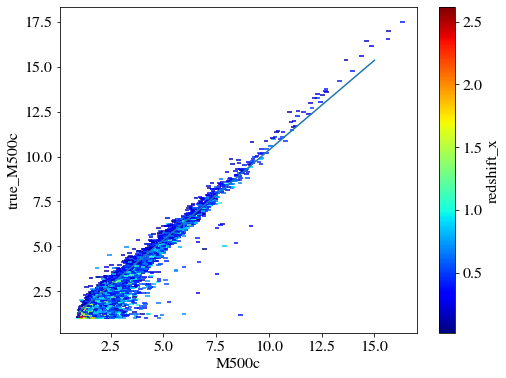

In [75]:
ax = df_all.plot(kind="scatter",x="M500c",y="true_M500c",c="redshift_x", cmap='jet',marker=1, sharex=False)
plt.plot(np.linspace(1.,15.,100),np.linspace(1.,15.,100)-np.log(0.7))


In [76]:
df_nemo

,redshift,true_M500c,name,true_fixed_y_c
0,0.256726,17.930581,MOCK-CL J1751.3-1129,5.613414
1,0.136831,17.012492,MOCK-CL J0212.9-4204,3.929891
2,0.258311,17.598813,MOCK-CL J1847.2-1345,5.518515
3,0.403070,17.505160,MOCK-CL J1350.1+1422,6.407170
4,0.193444,16.431466,MOCK-CL J1730.0+1647,4.560958
...,...,...,...,...
260692,0.910410,1.000146,MOCK-CL J0008.2-0624,0.154647
260693,0.943900,1.000029,MOCK-CL J2334.5-4015,0.155904
260694,0.911099,1.000105,MOCK-CL J0428.4-5420,0.154663
260695,0.926425,1.000077,MOCK-CL J2157.9-1310,0.155226


In [11]:
from nemo import *
path_to_selfn = '/Users/boris/Work/CLASS-SZ/SO-SZ/so_cluster_counts/MFMF_WebSkyHalos_A10tSZ_3freq_tiles_pass2/MFMF_WebSkyHalos_A10tSZ_3freq_tiles_pass2/selFn/'


configFileName=path_to_selfn+'config.yml'
selFnDir=path_to_selfn
SNRCut=snrcut
zStep=0.1
footprintLabel=None

print(">>> Setting up SNR > %.2f selection function ..." % (SNRCut))
selFn=completeness.SelFn(selFnDir, SNRCut, configFileName = configFileName, 
                         footprintLabel = footprintLabel, zStep = zStep)

scalingRelationDict=selFn.scalingRelationDict
H0, Om0, Ob0, sigma8, ns = websky_h*100., websky_Omega_M,websky_Omega_B, websky_sigma_8, websky_n_s
h=H0/100.0
selFn.update(H0, Om0, Ob0, sigma8, ns, scalingRelationDict = scalingRelationDict)
print("Total area = %.3f square degrees" % (selFn.totalAreaDeg2))

# N(z) with M500c > 5e13 MSun - no selection function applied
countsByRedshift=selFn.mockSurvey.clusterCount[:, np.greater(selFn.mockSurvey.log10M, np.log10(5e13/h))].sum(axis = 1)
z_nemo = []
Nz_noselfn = []
Nz_selfn = []

# with open("NzCheck_noSelFn.csv", "w") as outFile:
for i in range(len(selFn.mockSurvey.z)):
    z_nemo.append((selFn.mockSurvey.zBinEdges[i]+selFn.mockSurvey.zBinEdges[i+1])/2.)
    Nz_noselfn.append(countsByRedshift[i])
#     print("%.1f <= z < %.1f\t%.3f\n" % (selFn.mockSurvey.zBinEdges[i], selFn.mockSurvey.zBinEdges[i+1], countsByRedshift[i]))

# N(z) with M500c > 5e13 MSun - with S/N > 5 selection function applied
predMz=selFn.compMz*selFn.mockSurvey.clusterCount
countsByRedshift=predMz[:, np.greater(selFn.mockSurvey.log10M, np.log10(5e13/h))].sum(axis = 1)
# with open("NzCheck_withSelFn.csv", "w") as outFile:
for i in range(len(selFn.mockSurvey.z)):
#     z.append(selFn.mockSurvey.zBinEdges[i]+selFn.mockSurvey.zBinEdges[i+1])/2.)
    Nz_selfn.append(countsByRedshift[i])
#     print("%.1f <= z < %.1f\t%.3f\n" % (selFn.mockSurvey.zBinEdges[i], selFn.mockSurvey.zBinEdges[i+1], countsByRedshift[i]))


>>> Setting up SNR > 6.00 selection function ...
Total area = 17884.523 square degrees


In [12]:
np.sum(Nz_selfn)

30251.50884698465

In [13]:
#z = df_merges[df_merges['SNR']>9]['redshift']

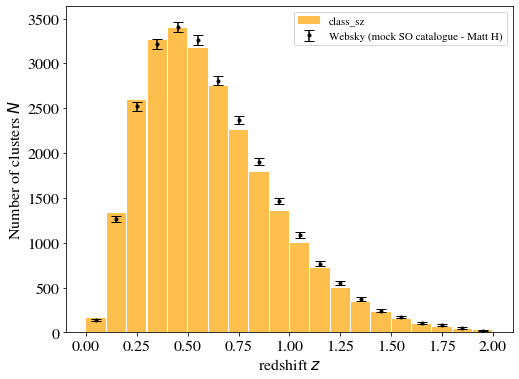

In [10]:
N_clusters_z, xedges = np.histogram(z, bins=z_edges)
plt.errorbar(z_center,N_clusters_z,yerr=np.sqrt(N_clusters_z),marker='o',markersize=3.,ls='none',label=r'Websky (mock SO catalogue - Matt H)',capsize=5,c='k')
#plt.hist(z_center,N_clusters_z_theory,marker='o',markersize=3.,ls=':',label='theory',c='orange')
n, bins, patches = plt.hist(x=np.repeat(z_center,N_clusters_z_theory), bins=z_edges, color='orange',alpha=0.7, rwidth=0.95,label=r'class_sz')
# n, bins, patches = plt.hist(x=np.repeat(z_center,N_clusters_z_theory_actlike), bins=z_edges, color='green',alpha=0.3, rwidth=0.95,label=r'ACT (~$10^{3}$)')
# n, bins, patches = plt.hist(x=np.repeat(z_center_planck,N_clusters_z_theory_planck), bins=z_edges_planck, color='red',alpha=0.7, rwidth=0.95,label=r'PLANCK (~$10^{2}$)')
# n, bins, patches = plt.hist(x=np.repeat(z_center,N_clusters_z_theory), bins=z_edges, color='orange',alpha=0.7, rwidth=0.95,label=r'SO (~$10^{4}$) - class_sz')
# plt.errorbar(z_nemo,Nz_selfn,yerr=np.sqrt(Nz_selfn),marker='o',markersize=3.,ls='none',label=r'Nemo (Matt H)',capsize=5,c='b')






plt.legend(loc=1,fontsize=11)
plt.xlabel(r'redshift $z$')
plt.ylabel(r'Number of clusters $N$')
plt.yscale('linear')
#plt.savefig('Nz_compare.pdf')
plt.show()

# plt.ylim(1e0,5e3)

In [45]:
 data.field("M200m").min()

1.4278445084810019

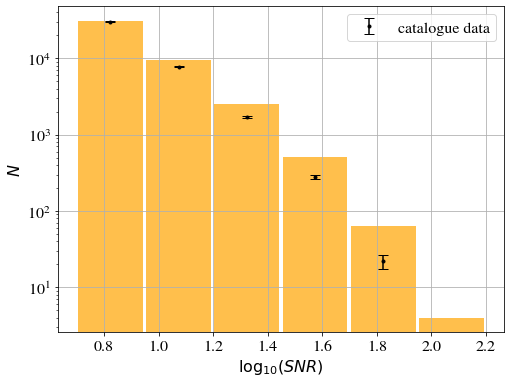

In [46]:
N_clusters_y, xedges = np.histogram(np.log10(snr), bins=log10y_edges)
plt.errorbar(log10y_center,N_clusters_y,yerr=np.sqrt(N_clusters_y),marker='o',markersize=3.,ls='none',label='catalogue data',capsize=5,c='k')
#plt.plot(log10y_center,N_clusters_y_theory,marker='o',markersize=3.,ls=':',label='theory',c='orange')
n, bins, patches = plt.hist(x=np.repeat(log10y_center,N_clusters_y_theory), bins=log10y_edges, color='orange',alpha=0.7, rwidth=0.95)


plt.grid()
plt.legend()
plt.xlabel(r'$\log_{10}(SNR)$')
plt.ylabel(r'$N$')
plt.yscale('log')

In [53]:
import pandas as pd 
d = pd.read_csv("/Users/boris/Work/CLASS-SZ/SO-SZ/so_cluster_counts/output_truemock_SNR.txt", delimiter=" \t", header = None).to_dict()[0]

/var/folders/_q/j04c9lw93j75_c_z2jdfbtwm0000gn/T/ipykernel_6193/619301583.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  d = pd.read_csv("/Users/boris/Work/CLASS-SZ/SO-SZ/so_cluster_counts/output_truemock_SNR.txt", delimiter=" \t", header = None).to_dict()[0]


In [54]:
import re
df = {'name':[],
     'mass_in':[],
      'y_in':[],
      'RA_in':[],
      'Dec_in':[],
      'tileName':[],
      'yRMS':[],
      'SNR':[]}
for i in range(len(d)):
    if i == 0:
        continue
    l =str(d[i])
    l = re.split('\s+', l)
    df['name'].append('MOCK-CL '+l[1])
    df['mass_in'].append(float(l[2]))
    df['y_in'].append(float(l[3]))
    df['RA_in'].append(float(l[4]))
    df['Dec_in'].append(float(l[5]))
    df['tileName'].append(l[6])
    df['yRMS'].append(float(l[7]))
    df['SNR'].append(float(l[8]))
    
#     print(type(l))
#     if i>10:
#         break
df = pd.DataFrame(df)

In [55]:

df

,name,mass_in,y_in,RA_in,Dec_in,tileName,yRMS,SNR
0,MOCK-CL J0212.9-4204,17.012492,3.929891,33.249195,-42.077911,1_4_6,0.000007,59.045171
1,MOCK-CL J1350.1+1422,17.505160,6.407170,207.543182,14.376556,3_10_6,0.000007,96.089427
2,MOCK-CL J1730.0+1647,16.431466,4.560958,262.521545,16.787682,3_11_1,0.000010,47.389518
3,MOCK-CL J0742.3-0732,15.355368,3.566145,115.584854,-7.542931,2_6_5,0.000009,39.613670
4,MOCK-CL J0927.0+0325,16.517517,5.782334,141.766556,3.429047,2_8_3,0.000007,77.989239
...,...,...,...,...,...,...,...,...
155542,MOCK-CL J0440.7-3441,1.000050,0.155889,70.195419,-34.690399,1_5_3,0.000008,2.058691
155543,MOCK-CL J2334.5-4015,1.000029,0.155904,353.634705,-40.250381,1_4_9,0.000008,2.064773
155544,MOCK-CL J0428.4-5420,1.000105,0.154663,67.105034,-54.346313,1_1_3,0.000006,2.632402
155545,MOCK-CL J2157.9-1310,1.000077,0.155226,329.499725,-13.168449,1_9_12,0.000007,2.144719


In [56]:
path_to_catalogue = '/Users/boris/Work/CLASS-SZ/SO-SZ/so_cluster_counts/MFMF_WebSkyHalos_A10tSZ_3freq_tiles_pass2/MFMF_WebSkyHalos_A10tSZ_3freq_tiles/'


#"fits_image_filename = fits.util.get_testdata_filepath(path_to_catalogue+'MFMF_SOSim_3freq_tiles_M500.fits')
# tcat = path_to_catalogue+'MFMF_WebSkyHalos_A10tSZ_3freq_tiles_mass.fits'
# tcat = path_to_catalogue+'MFMF_WebSkyHalos_A10tSZ_3freq_tiles_optimalCatalog.fits'
tcat = path_to_catalogue+'WebSky_A10_mock.fits'
list = fits.open(tcat)
data = list[1].data
z = data.field("redshift")
# snr = data.field("fixed_SNR")
# snr = np.sqrt(snr**2-3.)
# tile = data.field("tileName")
print(data.columns)

ColDefs(
    name = 'name'; format = '20A'
    name = 'RADeg'; format = 'E'
    name = 'decDeg'; format = 'E'
    name = 'redshift'; format = 'D'
    name = 'true_M500c'; format = 'D'
    name = 'true_fixed_y_c'; format = 'D'
    name = 'true_Q'; format = 'D'
)


In [57]:
print(data.columns)
df_nemo = {
#      "y_c": data.field("y_c").byteswap().newbyteorder(),
    "redshift": data.field("redshift").byteswap().newbyteorder(),
#       "err_y_c": data.field("err_y_c").byteswap().newbyteorder(),
    'true_M500c': data.field('true_M500c').byteswap().newbyteorder(),
#     "M200m": data.field("M200m").byteswap().newbyteorder(),
#      "SNR": data.field("SNR").byteswap().newbyteorder(),
      "name":data.field("name").byteswap().newbyteorder(),
     'true_fixed_y_c': data.field('true_fixed_y_c').byteswap().newbyteorder(),
      'true_M500c': data.field('true_M500c').byteswap().newbyteorder(),
#      "fixed_SNR": data.field("fixed_SNR").byteswap().newbyteorder(),
#      "decDeg":data.field("decDeg").byteswap().newbyteorder()}
}
df_nemo = pd.DataFrame(df_nemo)
df_nemo

ColDefs(
    name = 'name'; format = '20A'
    name = 'RADeg'; format = 'E'
    name = 'decDeg'; format = 'E'
    name = 'redshift'; format = 'D'
    name = 'true_M500c'; format = 'D'
    name = 'true_fixed_y_c'; format = 'D'
    name = 'true_Q'; format = 'D'
)


,redshift,true_M500c,name,true_fixed_y_c
0,0.256726,17.930581,MOCK-CL J1751.3-1129,5.613414
1,0.136831,17.012492,MOCK-CL J0212.9-4204,3.929891
2,0.258311,17.598813,MOCK-CL J1847.2-1345,5.518515
3,0.403070,17.505160,MOCK-CL J1350.1+1422,6.407170
4,0.193444,16.431466,MOCK-CL J1730.0+1647,4.560958
...,...,...,...,...
260692,0.910410,1.000146,MOCK-CL J0008.2-0624,0.154647
260693,0.943900,1.000029,MOCK-CL J2334.5-4015,0.155904
260694,0.911099,1.000105,MOCK-CL J0428.4-5420,0.154663
260695,0.926425,1.000077,MOCK-CL J2157.9-1310,0.155226


In [58]:
df_merges = pd.merge(df,df_nemo, how='inner',on='name')

In [59]:
df_merges

,name,mass_in,y_in,RA_in,Dec_in,tileName,yRMS,SNR,redshift,true_M500c,true_fixed_y_c
0,MOCK-CL J0212.9-4204,17.012492,3.929891,33.249195,-42.077911,1_4_6,0.000007,59.045171,0.136831,17.012492,3.929891
1,MOCK-CL J1350.1+1422,17.505160,6.407170,207.543182,14.376556,3_10_6,0.000007,96.089427,0.403070,17.505160,6.407170
2,MOCK-CL J1730.0+1647,16.431466,4.560958,262.521545,16.787682,3_11_1,0.000010,47.389518,0.193444,16.431466,4.560958
3,MOCK-CL J0742.3-0732,15.355368,3.566145,115.584854,-7.542931,2_6_5,0.000009,39.613670,0.136054,15.355368,3.566145
4,MOCK-CL J0927.0+0325,16.517517,5.782334,141.766556,3.429047,2_8_3,0.000007,77.989239,0.360132,16.517517,5.782334
...,...,...,...,...,...,...,...,...,...,...,...
156135,MOCK-CL J0440.7-3441,1.000050,0.155889,70.195419,-34.690399,1_5_3,0.000008,2.058691,0.943397,1.000050,0.155889
156136,MOCK-CL J2334.5-4015,1.000029,0.155904,353.634705,-40.250381,1_4_9,0.000008,2.064773,0.943900,1.000029,0.155904
156137,MOCK-CL J0428.4-5420,1.000105,0.154663,67.105034,-54.346313,1_1_3,0.000006,2.632402,0.911099,1.000105,0.154663
156138,MOCK-CL J2157.9-1310,1.000077,0.155226,329.499725,-13.168449,1_9_12,0.000007,2.144719,0.926425,1.000077,0.155226


In [22]:
df_merges[df_merges['SNR']>9]

,name,mass_in,y_in,RA_in,Dec_in,tileName,yRMS,SNR,redshift,true_M500c,true_fixed_y_c
0,MOCK-CL J0212.9-4204,17.012492,3.929891,33.249195,-42.077911,1_4_6,0.000007,59.045171,0.136831,17.012492,3.929891
1,MOCK-CL J1350.1+1422,17.505160,6.407170,207.543182,14.376556,3_10_6,0.000007,96.089427,0.403070,17.505160,6.407170
2,MOCK-CL J1730.0+1647,16.431466,4.560958,262.521545,16.787682,3_11_1,0.000010,47.389518,0.193444,16.431466,4.560958
3,MOCK-CL J0742.3-0732,15.355368,3.566145,115.584854,-7.542931,2_6_5,0.000009,39.613670,0.136054,15.355368,3.566145
4,MOCK-CL J0927.0+0325,16.517517,5.782334,141.766556,3.429047,2_8_3,0.000007,77.989239,0.360132,16.517517,5.782334
...,...,...,...,...,...,...,...,...,...,...,...
33758,MOCK-CL J0622.8-5858,1.839606,0.484348,95.720871,-58.979233,1_0_1,0.000005,9.817004,1.409549,1.839606,0.484348
36722,MOCK-CL J1921.0-5948,1.790648,0.454593,290.261200,-59.815659,1_0_10,0.000005,9.038995,1.366732,1.790648,0.454593
37004,MOCK-CL J0700.4-5058,1.728405,0.528673,105.106491,-50.977890,1_2_1,0.000006,9.276447,1.758963,1.728405,0.528673
37429,MOCK-CL J1848.2-5200,1.662823,0.597105,282.064270,-52.015915,1_2_13,0.000006,9.990722,2.097276,1.662823,0.597105


In [78]:
import healpy as hp
# from   cosmology import *
def makeACTName(RADeg, decDeg, prefix = 'ACT-CL'):
    """Makes ACT cluster name from RADeg, decDeg
    
    """
    
    actName=prefix+" J"+makeRA(RADeg)+makeDec(decDeg)
    
    return actName

def makeRA(myRADeg):
    """Makes RA part of ACT names.
    
    """
    hours=(myRADeg/360)*24
    if hours<10:
        sHours="0"+str(hours)[0]
    else:
        sHours=str(hours)[:2]
    
    mins=float(str(hours)[str(hours).index("."):])*60
    if mins<10:
        sMins="0"+str(mins)[:3]
    else:
        sMins=str(mins)[:4]
        
    return (sHours+sMins)#[:-2] # Trims off .x as not used in ACT names
        
#------------------------------------------------------------------------------------------------------------
def makeDec(myDecDeg):
    """Makes dec part of ACT names
    
    """
    
    # Positive
    if myDecDeg>0:
        if myDecDeg<10:
            sDeg="0"+str(myDecDeg)[0]
        else:
            sDeg=str(myDecDeg)[:2]
    
        mins=float(str(myDecDeg)[str(myDecDeg).index("."):])*60
        if mins<10:
            sMins="0"+str(mins)[:1]
        else:
            sMins=str(mins)[:2]
        
        return "+"+sDeg+sMins
    else:
        if myDecDeg>-10:
            sDeg="-0"+str(myDecDeg)[1]
        else:
            sDeg=str(myDecDeg)[:3]
    
        mins=float(str(myDecDeg)[str(myDecDeg).index("."):])*60
        if mins<10:
            sMins="0"+str(mins)[:1]
        else:
            sMins=str(mins)[:2]
        
        return str(sDeg+sMins)

omegam = M.Omega_m()
h = M.h()
rho = 2.775e11*omegam*h**2 # Msun/Mpc^3
path_to_catalogue_websky = '/Users/boris/Work/CLASS-SZ/SO-SZ/so_cluster_counts/'
f=open(path_to_catalogue_websky+'halos.pksc')
N=np.fromfile(f,count=3,dtype=np.int32)[0]

# only take first five entries for testing (there are ~8e8 halos total...)
# comment the following line to read in all halos
# ordered by decreasing mass
N = 800000
# N = 862923142

catalog=np.fromfile(f,count=N*10,dtype=np.float32)
catalog=np.reshape(catalog,(N,10))

x  = catalog[:,0];  y = catalog[:,1];  z = catalog[:,2] # Mpc (comoving)
vx = catalog[:,3]; vy = catalog[:,4]; vz = catalog[:,5] # km/sec
R  = catalog[:,6] # Mpc

# convert to mass, comoving distance, radial velocity, redshfit, RA and DEc
M200m    = 4*np.pi/3.*rho*R**3        # this is M200m (mean density 200 times mean) in Msun
chi      = np.sqrt(x**2+y**2+z**2)    # Mpc
vrad     = (x*vx + y*vy + z*vz) / chi # km/sec
redshift = zofchi(chi)      

theta, phi  = hp.vec2ang(np.column_stack((x,y,z))) # in radians

decDeg=-1*(np.degrees(theta)-90) # Because HEALPix
RADeg=np.degrees(phi)


### e.g. project to a map, matching the websky orientations
#nside = 1024
#map   = np.zeros((hp.nside2npix(nside)))

#pix = hp.vec2pix(nside, x, y, z)
#pix = hp.ang2pix(nside, theta, phi) does the same

#weight = 1. #1 for number density, array of size(x) for arbitrary
#np.add.at(map, pix, weight)

In [79]:
z = redshift
len(z)
z.min()
z.max()
# z_min = 1e-7
# z_max = 4.
# z_edges = np.linspace(z_min,z_max,10)
z_min = min(z_edges)
z_max = max(z_edges)
print(z_min,z_max)
z_edges = np.asarray(z_edges)
z_center = (z_edges[:-1] + z_edges[1:])/2.
z_center

1.0000000000003062e-05 2.0


array([0.050005, 0.15    , 0.25    , 0.35    , 0.45    , 0.55    ,
       0.65    , 0.75    , 0.85    , 0.95    , 1.05    , 1.15    ,
       1.25    , 1.35    , 1.45    , 1.55    , 1.65    , 1.75    ,
       1.85    , 1.95    ])

In [80]:
m200_min = M200m.min()*h
m200_max = M200m.max()*h
print('%.5e'%m200_min,'%.5e'%m200_max)
m_edges = np.linspace(np.log(m200_min),np.log(m200_max),50)
m_center = (m_edges[:-1] + m_edges[1:])/2.
m_center

8.06216e+13 2.35569e+15


array([32.05522466, 32.12409863, 32.19297259, 32.26184656, 32.33072052,
       32.39959449, 32.46846846, 32.53734242, 32.60621639, 32.67509035,
       32.74396432, 32.81283829, 32.88171225, 32.95058622, 33.01946019,
       33.08833415, 33.15720812, 33.22608208, 33.29495605, 33.36383002,
       33.43270398, 33.50157795, 33.57045191, 33.63932588, 33.70819985,
       33.77707381, 33.84594778, 33.91482174, 33.98369571, 34.05256968,
       34.12144364, 34.19031761, 34.25919158, 34.32806554, 34.39693951,
       34.46581347, 34.53468744, 34.60356141, 34.67243537, 34.74130934,
       34.8101833 , 34.87905727, 34.94793124, 35.0168052 , 35.08567917,
       35.15455314, 35.2234271 , 35.29230107, 35.36117503])

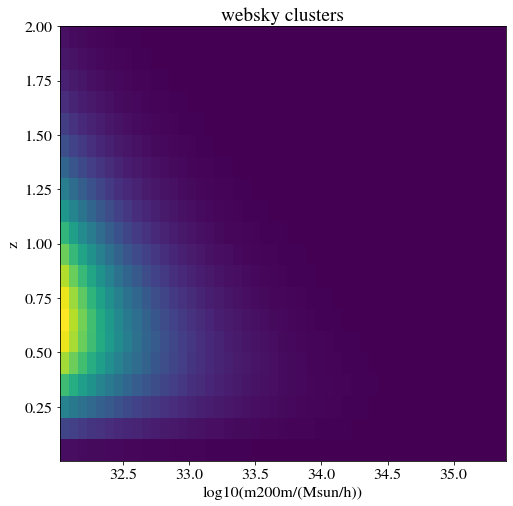

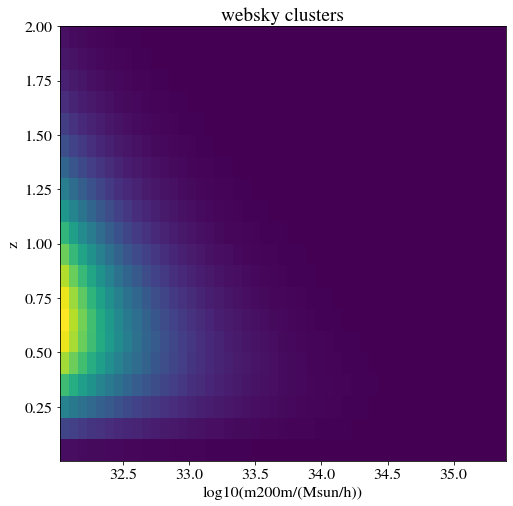

In [88]:
# x = np.random.normal(2, 1, 100)
# y = np.random.normal(1, 1, 100)
H, xedges, yedges = np.histogram2d(np.log(M200m*h), z, bins=(m_edges, z_edges))
# Histogram does not follow Cartesian convention (see Notes),
# therefore transpose H for visualization purposes. 
H = H.T

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot( title='websky clusters',
        aspect="auto")
X, Y = np.meshgrid(xedges, yedges)
ax.pcolormesh(X, Y, H)
plt.xlabel('log10(m200m/(Msun/h))')
plt.ylabel('z')
plt.show()

In [108]:
nms = 1000
nzs = 2000
lnms = np.linspace(np.log(m200_min*1.000001),np.log(m200_max*0.99999),nms)
zs = np.linspace(z_min,z_max,nzs)

In [109]:
# masses in rows
# redshifts in column
# sum over rows -> axis 0 (1st dimension)
# sum over columns -> axis 1 (2nd dimension)
dndmdz = np.zeros((nms,nzs))

In [110]:
for (im,mm) in enumerate(lnms):
    dndmdz[im,:] = np.vectorize(M.get_volume_dVdzdOmega_at_z)(zs)*np.vectorize(M.get_dndlnM_at_z_and_M)(zs,np.exp(mm))

In [111]:
# integrate over massses at each z:
dndz = np.trapz(dndmdz,x=lnms,axis=0)
nz = np.zeros((len(z_center)))

for (iz,zz) in enumerate(z_center): 
    filter_bin = (zs>z_edges[iz]) & (zs<z_edges[iz+1])
    nz[iz] = 4.*np.pi*np.trapz(dndz[filter_bin],x=zs[filter_bin] )

    

In [112]:
nmz = np.zeros((len(m_center),len(z_center)))

for (im,mm) in enumerate(m_center): 
    filter_binm = (lnms>m_edges[im]) & (lnms<m_edges[im+1])
    dndz_m = np.trapz(dndmdz[filter_binm,:],x=lnms[filter_binm],axis=0)

    for (iz,zz) in enumerate(z_center): 
        filter_bin = (zs>z_edges[iz]) & (zs<z_edges[iz+1])
        nmz[im,iz] = 4.*np.pi*np.trapz(dndz_m[filter_bin],x=zs[filter_bin] )



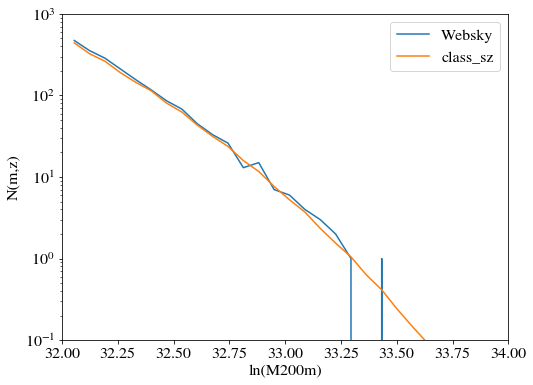

In [127]:
i = 19
plt.plot(m_center,H[i,:],label='Websky')
plt.plot(m_center,nmz.T[i,:],label='class_sz')
plt.legend()
plt.xlabel('ln(M200m)')
plt.ylabel('N(m,z)')
plt.yscale('log')
plt.ylim(1e-1,1e3)
plt.xlim(32,34.)
plt.show()


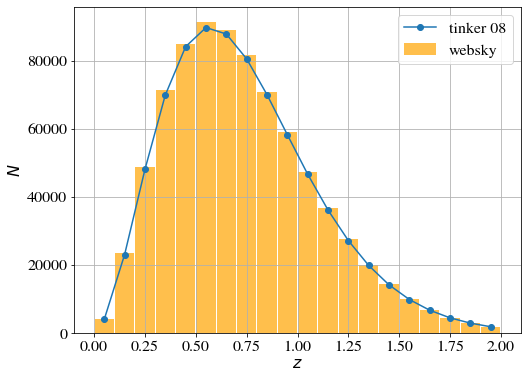

In [123]:
N_clusters_z, xedges = np.histogram(z, bins=z_edges)
# plt.errorbar(z_center,N_clusters_z,yerr=np.sqrt(N_clusters_z),marker='o',markersize=3.,ls='none',label='catalogue data',capsize=5,c='k')
#plt.hist(z_center,N_clusters_z_theory,marker='o',markersize=3.,ls=':',label='theory',c='orange')
n, bins, patches = plt.hist(x=np.repeat(z_center,
                                        N_clusters_z), 
                            bins=z_edges, 
                            color='orange',
                            alpha=0.7, 
                            rwidth=0.95,
                            label='websky')
plt.plot(z_center,nz,label='tinker 08',marker='o')
# n, bins, patches = plt.hist(x=np.repeat(z_center,
#                                         nz), 
#                             bins=z_edges, 
#                             color='orange',
#                             alpha=0.7, 
#                             rwidth=0.95,
#                             label='Tinker')

# n, bins, patches = plt.hist(x=np.repeat(z_center,N_clusters_z_theory), bins=z_edges, color='blue',alpha=0.7, rwidth=0.95,label=r'SO (~$10^{4}$) - class_sz')



plt.grid()
plt.legend(loc=1)
plt.xlabel(r'$z$')
plt.ylabel(r'$N$')
plt.yscale('linear')
plt.show()

In [24]:
N_clusters_z/nz

array([1.00910917, 1.00815332, 1.00173647, 1.0086956 , 1.0005214 ,
       1.0070011 , 1.00535157, 1.00712293, 1.00463454, 1.00794746,
       1.00670921, 1.00654552, 1.00622915, 1.00254401, 1.00903843,
       1.00874464, 1.00419847, 1.00294473, 0.99471306, 1.02691874])

In [25]:
N_clusters_z_theory/N_clusters_z

array([0.06211432, 0.08481944, 0.07739063, 0.06647054, 0.05807553,
       0.0509611 , 0.04584227, 0.04155207, 0.03834022, 0.03538099,
       0.03320069, 0.03123576, 0.02964743, 0.02846951, 0.02710366,
       0.02616593, 0.02562798, 0.02508999, 0.02476617, 0.02258588])

# testing cellls

# Websky halos

In [3]:
# copied from : https://github.com/simonsobs/websky_model/blob/a93bbf758432a936c0ec2b59775683b695d3d191/websky_model/websky.py#L55
websky_Omega_M = 0.31
websky_Omega_B = 0.049
websky_Omega_L = 0.69
websky_h = 0.68
websky_sigma_8 = 0.81
websky_n_s = 0.965


websky_cosmo = {
    'omega_b': websky_Omega_B*websky_h**2.,
    'omega_cdm': (websky_Omega_M-websky_Omega_B)*websky_h**2.,
    'h': websky_h,
    'tau_reio': 0.0543,
    'sigma8': websky_sigma_8,
    'n_s': websky_n_s,   
}

In [5]:
M = Class()
M.set(websky_cosmo)
M.set({
          'non linear': 'halofit',
          'output' : 'sz_cluster_counts',
          'mass function' : 'M500',
          'integrate_wrt_m500c' : 1,
          'has_selection_function' : 1,
          'experiment' : 1, # simons observatory 1
          'y_m_relation' : 1,
          'signal-to-noise cut-off for survey cluster completeness' : 5.,

          'M1SZ' : 1e13,
          'M2SZ' : 5e15,
          'B': 1.,

          'N_ur': 2.0328,
          'N_ncdm': 1,
          'm_ncdm': 0.0,
          'T_ncdm': 0.71611,
          'input_verbose' : 0,
          'background_verbose': 3,
          'perturbations_verbose': 0,
          'sz_verbose'  : 3,

          'bin_z_min_cluster_counts' : 0.,
          'bin_z_max_cluster_counts' : 2.,
          'bin_dz_cluster_counts' : 0.1,
          'bin_dlog10_snr': 0.25,

          'dlny' : 0.02,
          'lnymin' : -11., # planck  -11.5 so -11
          'lnymax' : -5.,  # planck 10. so -5
          'dlnM_cluster_count_completeness_grid' : 0.02,


          'cluster_count_completeness_grid_z_cutoff_low' : 0.2,
          'cluster_count_completeness_grid_z_cutoff_mid' : 1.,

          'dz_cluster_count_completeness_grid_low_z' : 1e-3,
          'dz_cluster_count_completeness_grid_mid_z' : 1e-2,
          'dz_cluster_count_completeness_grid_high_z' : 1e-1,



          'mass_epsrel_cluster_counts' : 1e-4,
          'mass_epsabs_cluster_counts' : 1e-40,

          'redshift_epsrel_cluster_counts' : 1e-4,
          'redshift_epsabs_cluster_counts' : 1e-40,
    
          'A_ym': 2.65e-05,#4.62e-05,#A_ym_websky,
          'B_ym': 0.08, #B_ym_websky,
          'C_ym' : 0.,
          'sigmaM_ym' : 0.2,
    

#           # # tabulation of mass function:
          'n_z_dndlnM' : 200,
          'n_m_dndlnM' : 200,
#           #
#           # # computation of mass function
#           # # (grid in mass and redshifts for sigma and dsigma)
          'ndim_masses' : 200,
          'ndim_redshifts' : 200,

#           # pk setup for computation of sigma and dsigma
    
          'k_per_decade_class_sz' : 40., #important parameter
          'k_min_for_pk_class_sz' : 1e-4,
          'k_max_for_pk_class_sz' : 2e0,

          'P_k_max_h/Mpc' : 2e1
    
})
M.compute()
print(M.sigma8())
print(M.get_sigma8_at_z(0.0002))
# print(M.get_sigma8_at_z(0.0))

0.8099998979385795
0.8102746666139765
inf


In [10]:
M.get_sigma8_at_z(1e-8)

0.8103597118811502

In [5]:
dNdzdy_theoretical = M.dndzdy_theoretical()['dndzdy']
z_center = M.dndzdy_theoretical()['z_center']
z_edges = M.dndzdy_theoretical()['z_edges']
log10y_center = M.dndzdy_theoretical()['log10y_center']
log10y_edges = M.dndzdy_theoretical()['log10y_edges']
# M.struct_cleanup()
# M.empty()



In [6]:
np.sum(dNdzdy_theoretical)

15919.775816414256

In [107]:
N_z,N_y = np.shape(dNdzdy_theoretical)
N_clusters_z_theory = []
N_clusters_z_theory_actlike = []
# N_clusters_z_theory_plancklike = []
for iz in range(N_z):
    N_clusters_z_theory.append(np.sum(dNdzdy_theoretical[iz]))
    N_clusters_z_theory_actlike.append(np.sum(dNdzdy_theoretical[iz])/4.)
#     N_clusters_z_theory_plancklike.append(np.sum(dNdzdy_theoretical[iz])/25.)
N_clusters_y_theory = []
for iy in range(N_y):
    N_clusters_y_theory.append(np.sum(np.asarray(dNdzdy_theoretical)[:,iy]))




In [108]:
# here puth the path to the directory : MFMF_SOSim_3freq_tiles
path_to_catalogue = '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_external_data_and_scripts/MFMF_SOSim_3freq_tiles/'

#"fits_image_filename = fits.util.get_testdata_filepath(path_to_catalogue+'MFMF_SOSim_3freq_tiles_M500.fits')
tcat = path_to_catalogue+'MFMF_SOSim_3freq_tiles_M500.fits'
list = fits.open(tcat)
data = list[1].data
z = data.field("redshift")
snr = data.field("fixed_SNR")
tile = data.field("tileName")
snrcut = 5
z = z[snr > snrcut]
snr = snr[snr > snrcut]
sf = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/so_3freqs_020621_skyfracs.txt')
print('sky fraction:',sf.sum())
print('N clusters:',z.size)

sky fraction: 0.43213469173544644
N clusters: 15889


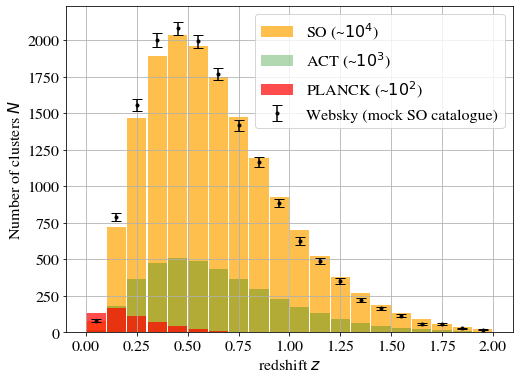

In [120]:
N_clusters_z, xedges = np.histogram(z, bins=z_edges)
plt.errorbar(z_center,N_clusters_z,yerr=np.sqrt(N_clusters_z),marker='o',markersize=3.,ls='none',label=r'Websky (mock SO catalogue)',capsize=5,c='k')
#plt.hist(z_center,N_clusters_z_theory,marker='o',markersize=3.,ls=':',label='theory',c='orange')
n, bins, patches = plt.hist(x=np.repeat(z_center,N_clusters_z_theory), bins=z_edges, color='orange',alpha=0.7, rwidth=0.95,label=r'SO (~$10^{4}$)')
n, bins, patches = plt.hist(x=np.repeat(z_center,N_clusters_z_theory_actlike), bins=z_edges, color='green',alpha=0.3, rwidth=0.95,label=r'ACT (~$10^{3}$)')
n, bins, patches = plt.hist(x=np.repeat(z_center_planck,N_clusters_z_theory_planck), bins=z_edges_planck, color='red',alpha=0.7, rwidth=0.95,label=r'PLANCK (~$10^{2}$)')



plt.grid()
plt.legend(loc=1)
plt.xlabel(r'redshift $z$')
plt.ylabel(r'Number of clusters $N$')
plt.yscale('linear')
plt.savefig('Nz_compare.pdf')
# plt.ylim(1e0,5e3)

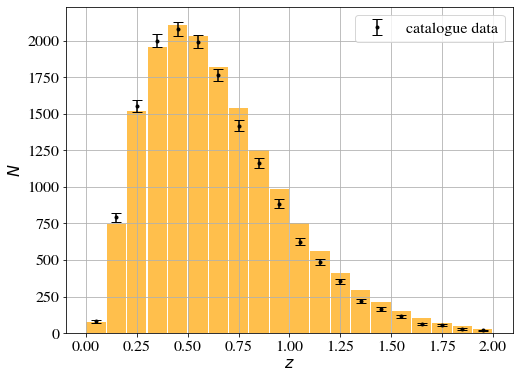

In [59]:
N_clusters_z, xedges = np.histogram(z, bins=z_edges)
plt.errorbar(z_center,N_clusters_z,yerr=np.sqrt(N_clusters_z),marker='o',markersize=3.,ls='none',label='catalogue data',capsize=5,c='k')
#plt.hist(z_center,N_clusters_z_theory,marker='o',markersize=3.,ls=':',label='theory',c='orange')
n, bins, patches = plt.hist(x=np.repeat(z_center,N_clusters_z_theory), bins=z_edges, color='orange',alpha=0.7, rwidth=0.95)
plt.grid()
plt.legend(loc=1)
plt.xlabel(r'$z$')
plt.ylabel(r'$N$')
plt.yscale('linear')
# plt.ylim(1e0,5e3)

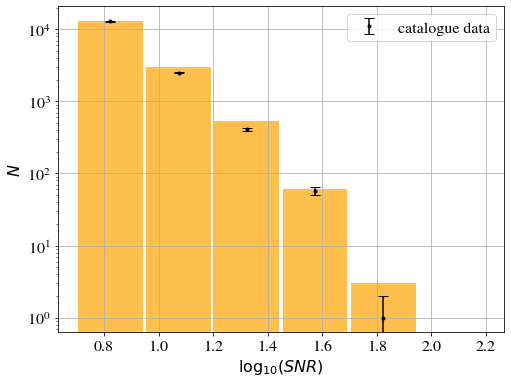

In [60]:
N_clusters_y, xedges = np.histogram(np.log10(snr), bins=log10y_edges)
plt.errorbar(log10y_center,N_clusters_y,yerr=np.sqrt(N_clusters_y),marker='o',markersize=3.,ls='none',label='catalogue data',capsize=5,c='k')
#plt.plot(log10y_center,N_clusters_y_theory,marker='o',markersize=3.,ls=':',label='theory',c='orange')
n, bins, patches = plt.hist(x=np.repeat(log10y_center,N_clusters_y_theory), bins=log10y_edges, color='orange',alpha=0.7, rwidth=0.95)


plt.grid()
plt.legend()
plt.xlabel(r'$\log_{10}(SNR)$')
plt.ylabel(r'$N$')
plt.yscale('log')

In [6]:
# here puth the path to the directory : MFMF_SOSim_3freq_tiles
path_to_catalogue = '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_external_data_and_scripts/MFMF_SOSim_3freq_tiles/'

#"fits_image_filename = fits.util.get_testdata_filepath(path_to_catalogue+'MFMF_SOSim_3freq_tiles_M500.fits')
tcat = path_to_catalogue+'MFMF_SOSim_3freq_tiles_M500.fits'
list = fits.open(tcat)
data = list[1].data
z = data.field("redshift")
snr = data.field("fixed_SNR")
tile = data.field("tileName")
snrcut = 5
z = z[snr > snrcut]
snr = snr[snr > snrcut]
sf = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/so_3freqs_020621_skyfracs.txt')
print('sky fraction:',sf.sum())
print('N clusters:',z.size)
print(data.columns)
df = {"M200m":data.field("M200m").byteswap().newbyteorder()*1e14,
     "M500c_nemo":data.field("M500").byteswap().newbyteorder()*1e14,
      "M500c_errPlus_nemo":data.field("M500_errPlus").byteswap().newbyteorder()*1e14,
      "M500c_errMinus_nemo":data.field("M500_errMinus").byteswap().newbyteorder()*1e14,
     "redshift":data.field("redshift").byteswap().newbyteorder(),
     "y_c": data.field("y_c").byteswap().newbyteorder(),
      "err_y_c": data.field("err_y_c").byteswap().newbyteorder(),
     "SNR": data.field("SNR").byteswap().newbyteorder(),
      "redshiftErr": data.field("redshiftErr").byteswap().newbyteorder(),
      "name":data.field("name").byteswap().newbyteorder(),
     "fixed_y_c": data.field("fixed_y_c").byteswap().newbyteorder(),
      "fixed_err_y_c": data.field("fixed_err_y_c").byteswap().newbyteorder(),
     "fixed_SNR": data.field("fixed_SNR").byteswap().newbyteorder(),
     "decDeg":data.field("decDeg").byteswap().newbyteorder()}
df = pd.DataFrame(df)
df = df[:10000]
df

sky fraction: 0.43213469173544644
N clusters: 15889
ColDefs(
    name = 'name'; format = '18A'
    name = 'RADeg'; format = 'D'
    name = 'decDeg'; format = 'D'
    name = 'SNR'; format = 'D'
    name = 'numSigPix'; format = 'D'
    name = 'template'; format = '17A'
    name = 'tileName'; format = '7A'
    name = 'galacticLatDeg'; format = 'D'
    name = 'fixed_SNR'; format = 'D'
    name = 'deltaT_c'; format = 'D'
    name = 'err_deltaT_c'; format = 'D'
    name = 'y_c'; format = 'D'
    name = 'err_y_c'; format = 'D'
    name = 'fixed_deltaT_c'; format = 'D'
    name = 'fixed_err_deltaT_c'; format = 'D'
    name = 'fixed_y_c'; format = 'D'
    name = 'fixed_err_y_c'; format = 'D'
    name = 'redshift'; format = 'D'
    name = 'redshiftErr'; format = 'D'
    name = 'M500'; format = 'D'
    name = 'M500_errPlus'; format = 'D'
    name = 'M500_errMinus'; format = 'D'
    name = 'M500Uncorr'; format = 'D'
    name = 'M500Uncorr_errPlus'; format = 'D'
    name = 'M500Uncorr_errMinus'; fo

,M200m,M500c_nemo,M500c_errPlus_nemo,M500c_errMinus_nemo,redshift,y_c,err_y_c,SNR,redshiftErr,name,fixed_y_c,fixed_err_y_c,fixed_SNR,decDeg
0,5.482577e+14,3.174886e+14,5.524806e+13,4.705904e+13,1.230438,0.573160,0.066240,8.652821,0.0,SO-CL J0000.0-0207,0.685775,0.080300,8.540124,-2.123842
1,4.851615e+14,2.652659e+14,6.334330e+13,5.113313e+13,0.311749,0.332783,0.049202,6.763545,0.0,SO-CL J0000.0-6015,0.430087,0.065723,6.543895,-60.259410
2,2.726391e+14,1.612437e+14,4.155245e+13,3.303845e+13,0.831074,0.199920,0.046100,4.336629,0.0,SO-CL J0000.0-6211,0.247447,0.064357,3.844894,-62.187500
3,4.751891e+14,2.781727e+14,5.407670e+13,4.527521e+13,0.985001,0.424044,0.065235,6.500304,0.0,SO-CL J0000.1-0604,0.510689,0.079363,6.434868,-6.070684
4,2.738110e+14,1.545051e+14,3.220854e+13,2.665250e+13,1.772472,0.249817,0.052725,4.738135,0.0,SO-CL J0000.1-1840,0.344519,0.076684,4.492719,-18.679979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3.804905e+14,2.120785e+14,5.835108e+13,4.576056e+13,0.366128,0.282934,0.064674,4.374739,0.0,SO-CL J0713.9+1506,0.343204,0.079318,4.326918,15.112471
9996,3.953636e+14,2.320970e+14,5.246859e+13,4.279436e+13,0.835272,0.585623,0.114681,5.106538,0.0,SO-CL J0713.9+0544,0.393922,0.078938,4.990273,5.735271
9997,3.224668e+14,1.817665e+14,4.953281e+13,3.892535e+13,0.400811,0.225849,0.052071,4.337308,0.0,SO-CL J0714.0-3544,0.277679,0.065976,4.208809,-35.735364
9998,1.430703e+15,7.927549e+14,1.495587e+14,1.258216e+14,0.494727,1.279418,0.047421,26.979793,0.0,SO-CL J0714.0-5055,1.607771,0.061416,26.178433,-50.920030


In [24]:
N_clusters = 9999
fixed_y_c = df.loc[:N_clusters,'fixed_y_c'].values*1e-4
fixed_err_y_c = df.loc[:N_clusters,'fixed_err_y_c'].values*1e-4
redshifts = df.loc[:N_clusters,'redshift'].values

A = 2.85e-05
B = 0.0
sigma_int = 0.2
mass_results = np.vectorize(M.getM500_from_y0_H13)(fixed_y_c,fixed_err_y_c,A,B,sigma_int,redshifts)
# paramss = (fixed_y_c,fixed_err_y_c,redshifts)
# paramss
df_masses_boris = {"M500c_boris": mass_results[0],
                   'M500c_errPlus_boris':mass_results[1],
                   'M500c_errMinus_boris':mass_results[2],
                   'redshift':df.loc[:N_clusters,'redshift'].values
                  }
df_masses_boris = pd.DataFrame(df_masses_boris)

In [25]:
print(A,B,sigma_int)

2.85e-05 0.0 0.2


In [26]:
df_with_boris_masses = pd.merge(df, df_masses_boris, how='inner')

In [14]:
from scipy.interpolate import *
import numpy as np

omegab = websky_Omega_B
omegac = websky_Omega_M-websky_Omega_B
omegam = omegab + omegac
h      = websky_h
ns     = websky_n_s
sigma8 = websky_sigma_8

c = 3e5

H0 = 100*h
nz = 100000
z1 = 0.0
z2 = 6.0
za = np.linspace(z1,z2,nz)
dz = za[1]-za[0]

H      = lambda z: H0*np.sqrt(omegam*(1+z)**3+1-omegam)
dchidz = lambda z: c/H(z)

chia = np.cumsum(dchidz(za))*dz

zofchi = interp1d(chia,za)

In [15]:
import healpy as hp
# from   cosmology import *
def makeACTName(RADeg, decDeg, prefix = 'ACT-CL'):
    """Makes ACT cluster name from RADeg, decDeg
    
    """
    
    actName=prefix+" J"+makeRA(RADeg)+makeDec(decDeg)
    
    return actName

def makeRA(myRADeg):
    """Makes RA part of ACT names.
    
    """
    hours=(myRADeg/360)*24
    if hours<10:
        sHours="0"+str(hours)[0]
    else:
        sHours=str(hours)[:2]
    
    mins=float(str(hours)[str(hours).index("."):])*60
    if mins<10:
        sMins="0"+str(mins)[:3]
    else:
        sMins=str(mins)[:4]
        
    return (sHours+sMins)#[:-2] # Trims off .x as not used in ACT names
        
#------------------------------------------------------------------------------------------------------------
def makeDec(myDecDeg):
    """Makes dec part of ACT names
    
    """
    
    # Positive
    if myDecDeg>0:
        if myDecDeg<10:
            sDeg="0"+str(myDecDeg)[0]
        else:
            sDeg=str(myDecDeg)[:2]
    
        mins=float(str(myDecDeg)[str(myDecDeg).index("."):])*60
        if mins<10:
            sMins="0"+str(mins)[:1]
        else:
            sMins=str(mins)[:2]
        
        return "+"+sDeg+sMins
    else:
        if myDecDeg>-10:
            sDeg="-0"+str(myDecDeg)[1]
        else:
            sDeg=str(myDecDeg)[:3]
    
        mins=float(str(myDecDeg)[str(myDecDeg).index("."):])*60
        if mins<10:
            sMins="0"+str(mins)[:1]
        else:
            sMins=str(mins)[:2]
        
        return str(sDeg+sMins)

omegam = M.Omega_m()
h = M.h()
rho = 2.775e11*omegam*h**2 # Msun/Mpc^3
path_to_catalogue_websky = '/Users/boris/Work/CLASS-SZ/SO-SZ/so_cluster_counts/'
f=open(path_to_catalogue_websky+'halos.pksc')
N=np.fromfile(f,count=3,dtype=np.int32)[0]

# only take first five entries for testing (there are ~8e8 halos total...)
# comment the following line to read in all halos
N = 800000
# N = 862923142

catalog=np.fromfile(f,count=N*10,dtype=np.float32)
catalog=np.reshape(catalog,(N,10))

x  = catalog[:,0];  y = catalog[:,1];  z = catalog[:,2] # Mpc (comoving)
vx = catalog[:,3]; vy = catalog[:,4]; vz = catalog[:,5] # km/sec
R  = catalog[:,6] # Mpc

# convert to mass, comoving distance, radial velocity, redshfit, RA and DEc
M200m    = 4*np.pi/3.*rho*R**3        # this is M200m (mean density 200 times mean) in Msun
chi      = np.sqrt(x**2+y**2+z**2)    # Mpc
vrad     = (x*vx + y*vy + z*vz) / chi # km/sec
redshift = zofchi(chi)      

theta, phi  = hp.vec2ang(np.column_stack((x,y,z))) # in radians

decDeg=-1*(np.degrees(theta)-90) # Because HEALPix
RADeg=np.degrees(phi)


### e.g. project to a map, matching the websky orientations
#nside = 1024
#map   = np.zeros((hp.nside2npix(nside)))

#pix = hp.vec2pix(nside, x, y, z)
#pix = hp.ang2pix(nside, theta, phi) does the same

#weight = 1. #1 for number density, array of size(x) for arbitrary
#np.add.at(map, pix, weight)

In [ ]:
names = []
for ra, dec in zip(RADeg, decDeg):
    names.append(makeACTName(ra, dec, prefix= 'SO-CL'))

M500c = []
for zz,mm in zip(redshift,M200m):
    mm500c = M.get_m200m_to_m500c_at_z_and_M(zz,mm*h)
    M500c.append(mm500c/h)

df_websky = {"M200m_websky":M200m, #in m_sun
             "M500c_websky":M500c, #in m_sun
             "redshift":redshift,
             "name": names,
             "decDeg":decDeg}
df_websky = pd.DataFrame(df_websky)

In [233]:
tcat = path_to_catalogue+'MFMF_SOSim_3freq_tiles_M500.fits'
list = fits.open(tcat)
data = list[1].data
z = data.field("redshift")
snr = data.field("fixed_SNR")
tile = data.field("tileName")
snrcut = 5
z = z[snr > snrcut]
snr = snr[snr > snrcut]
sf = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/so_3freqs_020621_skyfracs.txt')
print('sky fraction:',sf.sum())
print('N clusters:',z.size)
# print(data.columns)
df = {"M200m":data.field("M200m").byteswap().newbyteorder()*1e14,
     "M500c_nemo":data.field("M500").byteswap().newbyteorder()*1e14,
      "M500c_errPlus_nemo":data.field("M500_errPlus").byteswap().newbyteorder()*1e14,
      "M500c_errMinus_nemo":data.field("M500_errMinus").byteswap().newbyteorder()*1e14,
     "redshift":data.field("redshift").byteswap().newbyteorder(),
     "y_c": data.field("y_c").byteswap().newbyteorder(),
      "err_y_c": data.field("err_y_c").byteswap().newbyteorder(),
     "SNR": data.field("SNR").byteswap().newbyteorder(),
      "redshiftErr": data.field("redshiftErr").byteswap().newbyteorder(),
      "name":data.field("name").byteswap().newbyteorder(),
     "fixed_y_c": data.field("fixed_y_c").byteswap().newbyteorder(),
      "fixed_err_y_c": data.field("fixed_err_y_c").byteswap().newbyteorder(),
     "fixed_SNR": data.field("fixed_SNR").byteswap().newbyteorder(),
     "decDeg":data.field("decDeg").byteswap().newbyteorder()}
df = pd.DataFrame(df)

N_clusters = 10000
df = df[:N_clusters]



df_so_names_decDeg_z = pd.DataFrame({"name":df["name"],"redshift":df["redshift"]})
df_websky_cut = pd.merge(df_so_names_decDeg_z, df_websky, how='inner')







sky fraction: 0.43213469173544644
N clusters: 15889


In [234]:
A = 2.65e-05
B = 0.0
A = A_minimizer
B = B_minimizer
sigma_int = 0.2
fixed_y_c = df.loc[:N_clusters-1,'fixed_y_c'].values*1e-4
fixed_err_y_c = df.loc[:N_clusters-1,'fixed_err_y_c'].values*1e-4
redshifts = df.loc[:N_clusters-1,'redshift'].values
mass_results = np.vectorize(M.getM500_from_y0_H13)(fixed_y_c,fixed_err_y_c,A,B,sigma_int,redshifts)
# paramss = (fixed_y_c,fixed_err_y_c,redshifts)
# paramss
df_masses_boris = {"M500c_boris": mass_results[0],
                   'M500c_errPlus_boris':mass_results[1],
                   'M500c_errMinus_boris':mass_results[2],
                   'redshift':df.loc[:N_clusters-1,'redshift'].values
                  }
df_masses_boris = pd.DataFrame(df_masses_boris)
df_with_boris_masses = pd.merge(df, df_masses_boris, how='inner')


df_with_boris_and_websky_masses = pd.merge(df_websky_cut, df_with_boris_masses, how='inner',on=['name','redshift'])
df_with_boris_and_websky_masses.drop(df_with_boris_and_websky_masses.loc[df_with_boris_and_websky_masses['fixed_SNR']<5.].index, inplace=True)


m500s =unumpy.uarray(df_with_boris_and_websky_masses["M500c_boris"]/df_with_boris_and_websky_masses["M500c_websky"],
          (df_with_boris_and_websky_masses["M500c_errMinus_boris"]+
          df_with_boris_and_websky_masses["M500c_errPlus_boris"])/2./df_with_boris_and_websky_masses["M500c_websky"])
ratio  = np.sum(m500s)/len(m500s)
ratio.nominal_value

#df_with_boris_and_websky_masses

0.9941713978232236

In [200]:
A = 2.85e-05
B = 0.0

sigma_int = 0.2
def get_A_B_in_H13(t,sigma_int):
    var_A,var_B=t
    print(var_A,var_B)
    mass_results = np.vectorize(M.getM500_from_y0_H13)(fixed_y_c,fixed_err_y_c,var_A,var_B,sigma_int,redshifts)

    df_masses_boris = {"M500c_boris": mass_results[0],
                       'M500c_errPlus_boris':mass_results[1],
                       'M500c_errMinus_boris':mass_results[2],
                       'redshift':df.loc[:N_clusters-1,'redshift'].values
                      }
    df_masses_boris = pd.DataFrame(df_masses_boris)
    df_with_boris_masses = pd.merge(df, df_masses_boris, how='inner')


    df_with_boris_and_websky_masses = pd.merge(df_websky_cut, df_with_boris_masses, how='inner',on=['name','redshift'])
    df_with_boris_and_websky_masses.drop(df_with_boris_and_websky_masses.loc[df_with_boris_and_websky_masses['fixed_SNR']<5.].index, inplace=True)


    m500s =unumpy.uarray(df_with_boris_and_websky_masses["M500c_boris"]/df_with_boris_and_websky_masses["M500c_websky"],
              (df_with_boris_and_websky_masses["M500c_errMinus_boris"]+
              df_with_boris_and_websky_masses["M500c_errPlus_boris"])/2./df_with_boris_and_websky_masses["M500c_websky"])
    ratio  = np.sum(m500s)/len(m500s)
    result = ratio.nominal_value
    return (result -  1.)**2

#df_with_boris_and_websky_masses

In [201]:
A = 2.65e-5
B = -0.0

print(get_A_B_in_H13((A,B),sigma_int))
A = 4.65e-5
B = 0.
print(get_A_B_in_H13((A,B),sigma_int))

2.65e-05 -0.0
0.006860767710384073
4.65e-05 0.0
0.08130446149802328


In [202]:
fmin(get_A_B_in_H13,np.array([2.65e-5,0.0]),args=(sigma_int,))

2.65e-05 0.0
2.7825000000000002e-05 0.0
2.65e-05 0.00025
2.7825000000000005e-05 -0.00025
2.8487500000000008e-05 -0.0005
2.9812500000000006e-05 -0.0005
3.1468750000000016e-05 -0.00075
3.0475000000000012e-05 -0.001
3.1800000000000014e-05 -0.001
2.931562500000001e-05 -0.000625
2.8653125000000004e-05 -0.0001250000000000001


TypeError: argument of type 'NoneType' is not iterable

Exception ignored in: 'classy_sz.Class.__dealloc__'
Traceback (most recent call last):
  File "classy.pyx", line 215, in classy_sz.Class.struct_cleanup
TypeError: argument of type 'NoneType' is not iterable


2.9108593750000006e-05 -0.0003437500000000001
3.001953125000001e-05 -0.00078125
2.933632812500001e-05 -0.0004531250000000001
2.8839453125000012e-05 -0.0005781250000000001
2.9569238281250008e-05 -0.00051953125
2.958994140625001e-05 -0.0003476562500000001
2.9822851562500013e-05 -0.00041406250000000004
2.945795898437501e-05 -0.00044335937500000007
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 19


array([ 2.94579590e-05, -4.43359375e-04])

In [203]:
A_minimizer = 2.94579590e-05
B_minimizer = -4.43359375e-04

0.9941713978232236+/-0.0032236443342834164

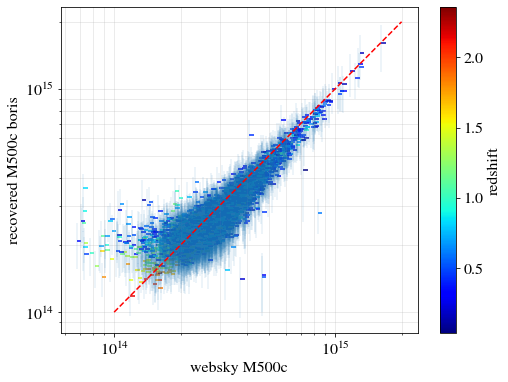

In [235]:






ax = df_with_boris_and_websky_masses.plot(kind="scatter",x="M500c_websky",y="M500c_boris",c="redshift", 
                                          cmap='jet',marker=1, sharex=False)


markers, caps, bars = plt.errorbar(df_with_boris_and_websky_masses["M500c_websky"], 
             df_with_boris_and_websky_masses["M500c_boris"], 
             yerr=[df_with_boris_and_websky_masses["M500c_errMinus_boris"],
                   df_with_boris_and_websky_masses["M500c_errPlus_boris"]],
             ls='None',
              marker='None',markersize=3.)

[bar.set_alpha(0.1) for bar in bars]
[cap.set_alpha(0.1) for cap in caps]

plt.plot(np.geomspace(1e14,2e15,100),np.geomspace(1e14,2e15,100),ls='--',c='r')



ax.set_ylabel(r"recovered M500c boris")
ax.set_xlabel(r"websky M500c")
ax.grid(which='both',alpha=0.3)
ax.loglog()


m500s =unumpy.uarray(df_with_boris_and_websky_masses["M500c_boris"]/df_with_boris_and_websky_masses["M500c_websky"],
          (df_with_boris_and_websky_masses["M500c_errMinus_boris"]+
          df_with_boris_and_websky_masses["M500c_errPlus_boris"])/2./df_with_boris_and_websky_masses["M500c_websky"])
np.sum(m500s)/len(m500s)
#
#fig.tight_layout()

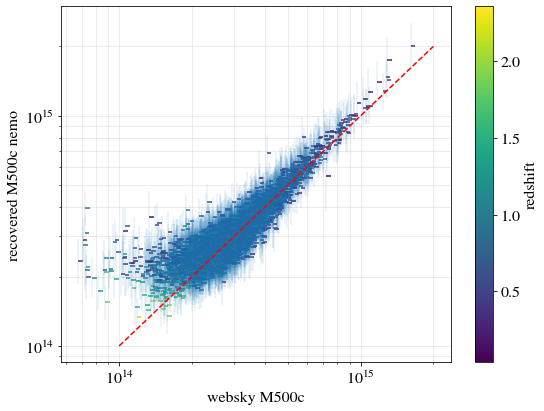

In [236]:

ax = df_with_boris_and_websky_masses.plot(kind="scatter",x="M500c_websky",y="M500c_nemo",c="redshift", cmap='viridis',marker=1, sharex=False)


markers, caps, bars = plt.errorbar(df_with_boris_and_websky_masses["M500c_websky"], 
             df_with_boris_and_websky_masses["M500c_nemo"], 
             yerr=[df_with_boris_and_websky_masses["M500c_errMinus_nemo"],
                   df_with_boris_and_websky_masses["M500c_errPlus_nemo"]],
             ls='None',
              marker='None',markersize=3.)

[bar.set_alpha(0.1) for bar in bars]
[cap.set_alpha(0.1) for cap in caps]

plt.plot(np.geomspace(1e14,2e15,100),np.geomspace(1e14,2e15,100),ls='--',c='r')



ax.set_ylabel(r"recovered M500c nemo")
ax.set_xlabel(r"websky M500c")
ax.grid(which='both',alpha=0.3)
ax.loglog()
plt.tight_layout()


In [240]:
df_with_boris_and_websky_masses["fixed_err_y_c"]

0       0.080300
1       0.065723
2       0.079363
4       0.080042
8       0.111699
          ...   
6456    0.080892
6457    0.064241
6458    0.066340
6459    0.062851
6461    0.061416
Name: fixed_err_y_c, Length: 3837, dtype: float64

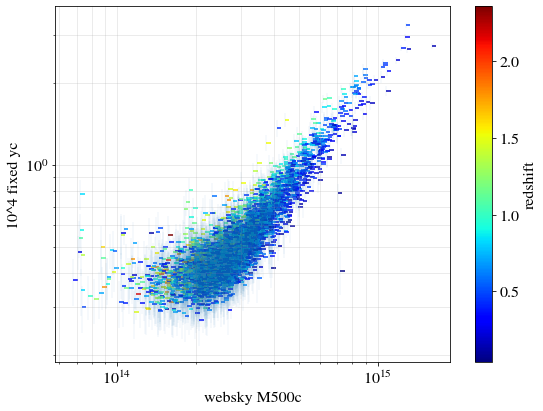

In [244]:
ax = df_with_boris_and_websky_masses.plot(kind="scatter",x="M500c_websky",y="fixed_y_c",c="redshift", cmap='jet',marker=1, sharex=False)

markers, caps, bars = plt.errorbar(df_with_boris_and_websky_masses["M500c_websky"], 
             df_with_boris_and_websky_masses["fixed_y_c"], 
             yerr=df_with_boris_and_websky_masses["fixed_err_y_c"],
             ls='None',
              marker='None',markersize=3.)

[bar.set_alpha(0.05) for bar in bars]
[cap.set_alpha(0.05) for cap in caps]

#plt.plot(np.geomspace(1e14,2e15,100),np.geomspace(1e14,2e15,100),ls='--',c='r')



ax.set_ylabel(r"10^4 fixed yc")
ax.set_xlabel(r"websky M500c")
ax.grid(which='both',alpha=0.3)
ax.loglog()
plt.tight_layout()



In [271]:
z = df_with_boris_and_websky_masses["redshift"]
m = df_with_boris_and_websky_masses["M500c_websky"]*M.h()
f_rel = np.vectorize(M.calcFRel)(z, m)
print(f_rel)
vec_theta = np.vectorize(M.get_theta_at_m_and_z)
thetas = vec_theta(m,z)
QF = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/so_3freqs_020621_theta500arcmin_Q.txt')
get_Q_of_theta500 = interpolate.interp1d(QF[:,0],QF[:,1],fill_value='extrapolate')
Qs = get_Q_of_theta500(thetas)
print(Qs)

[0.96441467 0.96641251 0.95636701 ... 0.96277699 0.96457961 0.93964428]
[0.41447246 1.21604924 0.60827925 ... 0.72525147 0.89853721 1.1850276 ]


In [302]:
def E2(z):
    return (M.Hubble(z)/M.Hubble(0.))**2.
E2zarr = np.vectorize(E2)(df_with_boris_and_websky_masses["redshift"])

df_with_boris_and_websky_masses["fixed_y_c_over_e2z"] =df_with_boris_and_websky_masses["fixed_y_c"]/E2zarr/f_rel/Qs
df_with_boris_and_websky_masses["fixed_err_y_c_over_e2z"] =df_with_boris_and_websky_masses["fixed_err_y_c"]/E2zarr/f_rel/Qs

def reduced_ym_relation(M500,a,b):
    return a*(M500/3e14)**b
xdata = df_with_boris_and_websky_masses["M500c_websky"]
ydata = df_with_boris_and_websky_masses["fixed_y_c_over_e2z"]
popt, pcov = scipy.optimize.curve_fit(reduced_ym_relation, xdata, ydata*1e-4,p0 = [0.08,0.025])
print("a=%.5e b=%5e"%(popt[0],popt[1]))
A_ym_websky = popt[0]
B_ym_websky = popt[1]

a=3.35221e-05 b=9.469742e-01


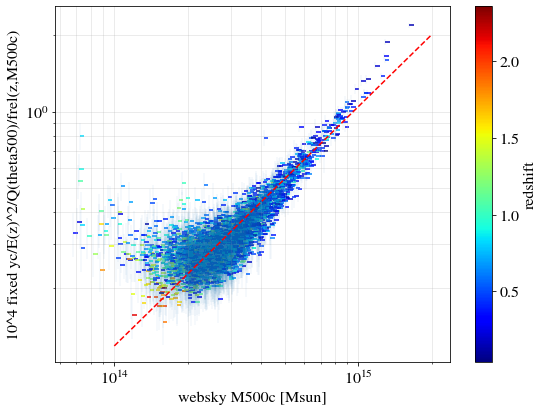

In [293]:
ax = df_with_boris_and_websky_masses.plot(kind="scatter",x="M500c_websky",y="fixed_y_c_over_e2z",c="redshift", cmap='jet',marker=1, sharex=False)

markers, caps, bars = plt.errorbar(df_with_boris_and_websky_masses["M500c_websky"], 
             df_with_boris_and_websky_masses["fixed_y_c_over_e2z"], 
             yerr=df_with_boris_and_websky_masses["fixed_err_y_c_over_e2z"],
             ls='None',
             marker='None',markersize=3.)

[bar.set_alpha(0.05) for bar in bars]
[cap.set_alpha(0.05) for cap in caps]


masses = np.geomspace(1e14,2e15,100)

plt.plot(masses,reduced_ym_relation(masses,1e4*popt[0],popt[1]),ls='--',c='r')



ax.set_ylabel(r"10^4 fixed yc/E(z)^2/Q(theta500)/frel(z,M500c)")
ax.set_xlabel(r"websky M500c [Msun]")
ax.grid(which='both',alpha=0.3)
ax.loglog()
plt.tight_layout()

plt.savefig('fixed_yc_over_ez2_Q_frel_vs_m500c.pdf')

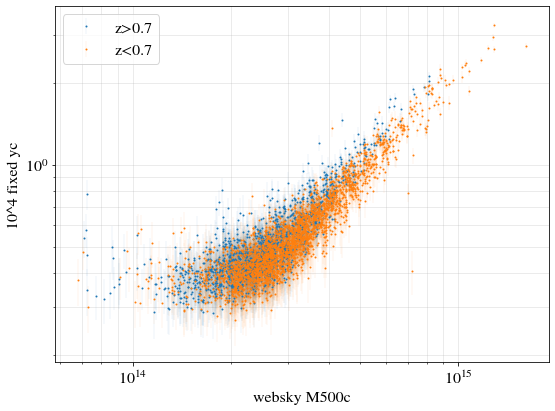

In [258]:
# ax = df_with_boris_and_websky_masses.plot(kind="scatter",x="M500c_websky",y="fixed_y_c",c="redshift", cmap='jet',marker=1, sharex=False)
fig, ax = plt.subplots()


markers, caps, bars = plt.errorbar(df_with_boris_and_websky_masses["M500c_websky"][df_with_boris_and_websky_masses["redshift"]>0.7], 
             df_with_boris_and_websky_masses["fixed_y_c"][df_with_boris_and_websky_masses["redshift"]>0.7], 
             yerr=df_with_boris_and_websky_masses["fixed_err_y_c"][df_with_boris_and_websky_masses["redshift"]>0.7],
             ls='None',
              marker='o',markersize=1.,label='z>0.7')
[bar.set_alpha(0.05) for bar in bars]
[cap.set_alpha(0.05) for cap in caps]
markers, caps, bars = plt.errorbar(df_with_boris_and_websky_masses["M500c_websky"][df_with_boris_and_websky_masses["redshift"]<0.7], 
             df_with_boris_and_websky_masses["fixed_y_c"][df_with_boris_and_websky_masses["redshift"]<0.7], 
             yerr=df_with_boris_and_websky_masses["fixed_err_y_c"][df_with_boris_and_websky_masses["redshift"]<0.7],
             ls='None',
              marker='o',markersize=1.,label='z<0.7')

[bar.set_alpha(0.05) for bar in bars]
[cap.set_alpha(0.05) for cap in caps]

#plt.plot(np.geomspace(1e14,2e15,100),np.geomspace(1e14,2e15,100),ls='--',c='r')



ax.set_ylabel(r"10^4 fixed yc")
ax.set_xlabel(r"websky M500c")
ax.grid(which='both',alpha=0.3)
ax.loglog()
plt.legend()
plt.tight_layout()



In [61]:
path_to_catalogue = '/Users/boris/Work/CLASS-SZ/SO-SZ/nemo/examples/SOSims/MFMF_SOSim_3freq_tiles/'


tcat = path_to_catalogue+'MFMF_SOSim_3freq_tiles_mass_boris.fits'
list = fits.open(tcat)
data = list[1].data
print(data.columns)
df_masses = {
     "y_c": data.field("y_c").byteswap().newbyteorder(),
      "err_y_c": data.field("err_y_c").byteswap().newbyteorder(),
    "M500c": data.field("M500c").byteswap().newbyteorder(),
    "M200m": data.field("M200m").byteswap().newbyteorder(),
     "SNR": data.field("SNR").byteswap().newbyteorder(),
      "name":data.field("name").byteswap().newbyteorder(),
     "fixed_y_c": data.field("fixed_y_c").byteswap().newbyteorder(),
      "fixed_err_y_c": data.field("fixed_err_y_c").byteswap().newbyteorder(),
     "fixed_SNR": data.field("fixed_SNR").byteswap().newbyteorder(),
     "redshift":data.field("redshift").byteswap().newbyteorder(),
     "decDeg":data.field("decDeg").byteswap().newbyteorder()}
df_masses = pd.DataFrame(df_masses)
df_masses

ColDefs(
    name = 'name'; format = '18A'
    name = 'RADeg'; format = 'D'
    name = 'decDeg'; format = 'D'
    name = 'SNR'; format = 'D'
    name = 'numSigPix'; format = 'D'
    name = 'template'; format = '17A'
    name = 'tileName'; format = '7A'
    name = 'galacticLatDeg'; format = 'D'
    name = 'fixed_SNR'; format = 'D'
    name = 'deltaT_c'; format = 'D'
    name = 'err_deltaT_c'; format = 'D'
    name = 'y_c'; format = 'D'
    name = 'err_y_c'; format = 'D'
    name = 'fixed_deltaT_c'; format = 'D'
    name = 'fixed_err_deltaT_c'; format = 'D'
    name = 'fixed_y_c'; format = 'D'
    name = 'fixed_err_y_c'; format = 'D'
    name = 'redshift'; format = 'D'
    name = 'redshiftErr'; format = 'D'
    name = 'M500c'; format = 'D'
    name = 'M500c_errPlus'; format = 'D'
    name = 'M500c_errMinus'; format = 'D'
    name = 'M500cUncorr'; format = 'D'
    name = 'M500cUncorr_errPlus'; format = 'D'
    name = 'M500cUncorr_errMinus'; format = 'D'
    name = 'M500cCal'; format = 'D'

,y_c,err_y_c,M500c,M200m,SNR,name,fixed_y_c,fixed_err_y_c,fixed_SNR,redshift,decDeg
0,0.573160,0.066240,3.174886,5.482577,8.652821,SO-CL J0000.0-0207,0.685775,0.080300,8.540124,1.230438,-2.123842
1,0.332783,0.049202,2.652659,4.851615,6.763545,SO-CL J0000.0-6015,0.430087,0.065723,6.543895,0.311749,-60.259410
2,0.199920,0.046100,1.612437,2.726391,4.336629,SO-CL J0000.0-6211,0.247447,0.064357,3.844894,0.831074,-62.187500
3,0.424044,0.065235,2.781727,4.751891,6.500304,SO-CL J0000.1-0604,0.510689,0.079363,6.434868,0.985001,-6.070684
4,0.249817,0.052725,1.545051,2.738110,4.738135,SO-CL J0000.1-1840,0.344519,0.076684,4.492719,1.772472,-18.679979
...,...,...,...,...,...,...,...,...,...,...,...
30132,0.320097,0.058307,0.000000,0.000000,5.489862,SO-CL J2359.9-0525,0.417228,0.078572,5.310148,0.971221,-5.424936
30133,0.499092,0.067415,0.000000,0.000000,7.403237,SO-CL J2359.9-4029,0.578439,0.078130,7.403552,0.609932,-40.492179
30134,0.331083,0.056531,0.000000,0.000000,5.856641,SO-CL J2359.9-1352,0.421021,0.083107,5.066024,0.218872,-13.883298
30135,0.487757,0.072230,0.000000,0.000000,6.752809,SO-CL J2359.9+0230,0.671116,0.110739,6.060357,0.318073,2.504207


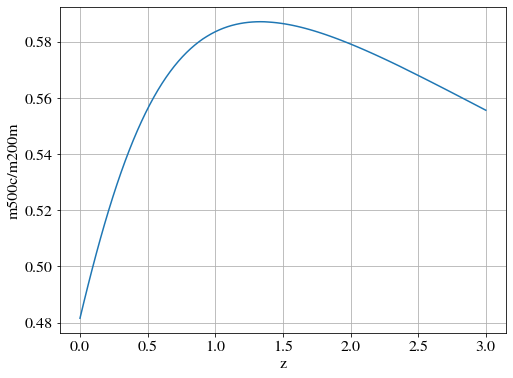

In [7]:

z=1.e-5
m200m_pivot = 3e14*0.7 # [Msun/h]


# corresponding m200c_pivot as a function of z:

z_array = np.linspace(0,3.,100)

m500c_over_m200m_pivot = []
for zz in z_array:
    m500c_over_m200m_pivot.append(M.get_m200m_to_m500c_at_z_and_M(zz,m200m_pivot)/m200m_pivot)


    
plt.plot(z_array,m500c_over_m200m_pivot)
plt.xlabel('z')
plt.ylabel('m500c/m200m')
plt.grid(which='both')

In [217]:
# here puth the path to the directory : MFMF_SOSim_3freq_tiles
path_to_nemo = '/Users/boris/Work/CLASS-SZ/SO-SZ/nemo/'
from astropy.io import fits
#"fits_image_filename = fits.util.get_testdata_filepath(path_to_catalogue+'MFMF_SOSim_3freq_tiles_M500.fits')
tcat = path_to_nemo+'redshifts.fits'
list = fits.open(tcat)
data = list[1].data
data.columns

df_redshifts = {
     "redshift": data.field("redshift").byteswap().newbyteorder(),
      "redshiftErr": data.field("redshiftErr").byteswap().newbyteorder(),
     "RADeg": data.field("RADeg").byteswap().newbyteorder(),
      "name":data.field("name").byteswap().newbyteorder(),
     "decDeg":data.field("decDeg").byteswap().newbyteorder()}
df_redshifts = pd.DataFrame(df_redshifts)
df_redshifts

,redshift,redshiftErr,RADeg,name,decDeg
0,1.230438,0.0,0.016245,SO-CL J0000.0-0207,-2.123842
1,0.311749,0.0,0.016680,SO-CL J0000.0-6015,-60.259410
2,0.831074,0.0,0.020898,SO-CL J0000.0-6211,-62.187500
3,0.985001,0.0,0.027526,SO-CL J0000.1-0604,-6.070684
4,1.772472,0.0,0.039871,SO-CL J0000.1-1840,-18.679979
...,...,...,...,...,...
30099,0.971221,0.0,359.986236,SO-CL J2359.9-0525,-5.424936
30100,0.609932,0.0,359.987866,SO-CL J2359.9-4029,-40.492179
30101,0.218872,0.0,359.991811,SO-CL J2359.9-1352,-13.883298
30102,0.318073,0.0,359.991867,SO-CL J2359.9+0230,2.504207


In [207]:
# here puth the path to the directory : MFMF_SOSim_3freq_tiles
path_to_nemo = '/Users/boris/Work/CLASS-SZ/SO-SZ/nemo/'
from astropy.io import fits
#"fits_image_filename = fits.util.get_testdata_filepath(path_to_catalogue+'MFMF_SOSim_3freq_tiles_M500.fits')
tcat = path_to_nemo+'halos.fits'
list = fits.open(tcat)
data = list[1].data
data.columns

ColDefs(
    name = 'name'; format = '20A'
    name = 'RADeg'; format = 'E'
    name = 'decDeg'; format = 'E'
    name = 'M200m'; format = 'E'
    name = 'z'; format = 'D'
)

In [220]:
path_to_catalogue = '/Users/boris/Work/CLASS-SZ/SO-SZ/nemo/examples/SOSims/MFMF_SOSim_3freq_tiles/'


tcat = path_to_catalogue+'MFMF_SOSim_3freq_tiles_optimalCatalog.fits'
list = fits.open(tcat)
data = list[1].data
data.columns
df_optimal = {
     "y_c": data.field("y_c").byteswap().newbyteorder(),
      "err_y_c": data.field("err_y_c").byteswap().newbyteorder(),
     "SNR": data.field("SNR").byteswap().newbyteorder(),
      "name":data.field("name").byteswap().newbyteorder(),
     "fixed_y_c": data.field("fixed_y_c").byteswap().newbyteorder(),
      "fixed_err_y_c": data.field("fixed_err_y_c").byteswap().newbyteorder(),
     "fixed_SNR": data.field("fixed_SNR").byteswap().newbyteorder(),
     "decDeg":data.field("decDeg").byteswap().newbyteorder()}
df_optimal = pd.DataFrame(df_optimal)
df_optimal

,y_c,err_y_c,SNR,name,fixed_y_c,fixed_err_y_c,fixed_SNR,decDeg
0,0.573160,0.066240,8.652821,SO-CL J0000.0-0207,0.685775,0.080300,8.540124,-2.123842
1,0.332783,0.049202,6.763545,SO-CL J0000.0-6015,0.430087,0.065723,6.543895,-60.259410
2,0.648032,0.147378,4.397060,SO-CL J0000.0-2845,0.423844,0.100428,4.220380,-28.758333
3,0.199920,0.046100,4.336629,SO-CL J0000.0-6211,0.247447,0.064357,3.844894,-62.187500
4,0.424044,0.065235,6.500304,SO-CL J0000.1-0604,0.510689,0.079363,6.434868,-6.070684
...,...,...,...,...,...,...,...,...
34102,0.320097,0.058307,5.489862,SO-CL J2359.9-0525,0.417228,0.078572,5.310148,-5.424936
34103,0.499092,0.067415,7.403237,SO-CL J2359.9-4029,0.578439,0.078130,7.403552,-40.492179
34104,0.331083,0.056531,5.856641,SO-CL J2359.9-1352,0.421021,0.083107,5.066024,-13.883298
34105,0.487757,0.072230,6.752809,SO-CL J2359.9+0230,0.671116,0.110739,6.060357,2.504207


In [22]:
path_to_catalogue = '/Users/boris/Work/CLASS-SZ/SO-SZ/nemo/examples/SOSims/MFMF_SOSim_3freq_tiles/'


tcat = path_to_catalogue+'MFMF_SOSim_3freq_tiles_mass_boris.fits'
list = fits.open(tcat)
data = list[1].data
print(data.columns)
df_masses = {
     "y_c": data.field("y_c").byteswap().newbyteorder(),
      "err_y_c": data.field("err_y_c").byteswap().newbyteorder(),
    "M500c": data.field("M500c").byteswap().newbyteorder(),
    "M200m": data.field("M200m").byteswap().newbyteorder(),
     "SNR": data.field("SNR").byteswap().newbyteorder(),
      "name":data.field("name").byteswap().newbyteorder(),
     "fixed_y_c": data.field("fixed_y_c").byteswap().newbyteorder(),
      "fixed_err_y_c": data.field("fixed_err_y_c").byteswap().newbyteorder(),
     "fixed_SNR": data.field("fixed_SNR").byteswap().newbyteorder(),
     "decDeg":data.field("decDeg").byteswap().newbyteorder()}
df_masses = pd.DataFrame(df_masses)
df_masses

ColDefs(
    name = 'name'; format = '18A'
    name = 'RADeg'; format = 'D'
    name = 'decDeg'; format = 'D'
    name = 'SNR'; format = 'D'
    name = 'numSigPix'; format = 'D'
    name = 'template'; format = '17A'
    name = 'tileName'; format = '7A'
    name = 'galacticLatDeg'; format = 'D'
    name = 'fixed_SNR'; format = 'D'
    name = 'deltaT_c'; format = 'D'
    name = 'err_deltaT_c'; format = 'D'
    name = 'y_c'; format = 'D'
    name = 'err_y_c'; format = 'D'
    name = 'fixed_deltaT_c'; format = 'D'
    name = 'fixed_err_deltaT_c'; format = 'D'
    name = 'fixed_y_c'; format = 'D'
    name = 'fixed_err_y_c'; format = 'D'
    name = 'redshift'; format = 'D'
    name = 'redshiftErr'; format = 'D'
    name = 'M500c'; format = 'D'
    name = 'M500c_errPlus'; format = 'D'
    name = 'M500c_errMinus'; format = 'D'
    name = 'M500cUncorr'; format = 'D'
    name = 'M500cUncorr_errPlus'; format = 'D'
    name = 'M500cUncorr_errMinus'; format = 'D'
    name = 'M500cCal'; format = 'D'

,y_c,err_y_c,M500c,M200m,SNR,name,fixed_y_c,fixed_err_y_c,fixed_SNR,decDeg
0,0.573160,0.066240,3.174886,5.482577,8.652821,SO-CL J0000.0-0207,0.685775,0.080300,8.540124,-2.123842
1,0.332783,0.049202,2.652659,4.851615,6.763545,SO-CL J0000.0-6015,0.430087,0.065723,6.543895,-60.259410
2,0.199920,0.046100,0.000000,0.000000,4.336629,SO-CL J0000.0-6211,0.247447,0.064357,3.844894,-62.187500
3,0.424044,0.065235,0.000000,0.000000,6.500304,SO-CL J0000.1-0604,0.510689,0.079363,6.434868,-6.070684
4,0.249817,0.052725,0.000000,0.000000,4.738135,SO-CL J0000.1-1840,0.344519,0.076684,4.492719,-18.679979
...,...,...,...,...,...,...,...,...,...,...
30132,0.320097,0.058307,0.000000,0.000000,5.489862,SO-CL J2359.9-0525,0.417228,0.078572,5.310148,-5.424936
30133,0.499092,0.067415,0.000000,0.000000,7.403237,SO-CL J2359.9-4029,0.578439,0.078130,7.403552,-40.492179
30134,0.331083,0.056531,0.000000,0.000000,5.856641,SO-CL J2359.9-1352,0.421021,0.083107,5.066024,-13.883298
30135,0.487757,0.072230,0.000000,0.000000,6.752809,SO-CL J2359.9+0230,0.671116,0.110739,6.060357,2.504207


simons observatory files

In [36]:
def E(zp):
    return M.Hubble(zp)/M.Hubble(0.)
vec_Ez = np.vectorize(E)
df["y_c_over_Ez2"] = df["y_c"]/vec_Ez(df["redshift"])**2.
df

,M200m,M500c,redshift,y_c,SNR,name,fixed_y_c,fixed_SNR,decDeg,y_c_over_Ez2
0,5.482577e+14,3.174886e+14,1.230438,0.573160,8.652821,SO-CL J0000.0-0207,0.685775,8.540124,-2.123842,0.138714
1,4.851615e+14,2.652659e+14,0.311749,0.332783,6.763545,SO-CL J0000.0-6015,0.430087,6.543895,-60.259410,0.239433
2,2.726391e+14,1.612437e+14,0.831074,0.199920,4.336629,SO-CL J0000.0-6211,0.247447,3.844894,-62.187500,0.077067
3,4.751891e+14,2.781727e+14,0.985001,0.424044,6.500304,SO-CL J0000.1-0604,0.510689,6.434868,-6.070684,0.136089
4,2.738110e+14,1.545051e+14,1.772472,0.249817,4.738135,SO-CL J0000.1-1840,0.344519,4.492719,-18.679979,0.034214
...,...,...,...,...,...,...,...,...,...,...
30132,4.064517e+14,2.387425e+14,0.971221,0.320097,5.489862,SO-CL J2359.9-0525,0.417228,5.310148,-5.424936,0.104411
30133,5.845295e+14,3.356987e+14,0.609932,0.499092,7.403237,SO-CL J2359.9-4029,0.578439,7.403552,-40.492179,0.251549
30134,4.634598e+14,2.464252e+14,0.218872,0.331083,5.856641,SO-CL J2359.9-1352,0.421021,5.066024,-13.883298,0.264557
30135,6.886024e+14,3.740221e+14,0.318073,0.487757,6.752809,SO-CL J2359.9+0230,0.671116,6.060357,2.504207,0.348384


[]

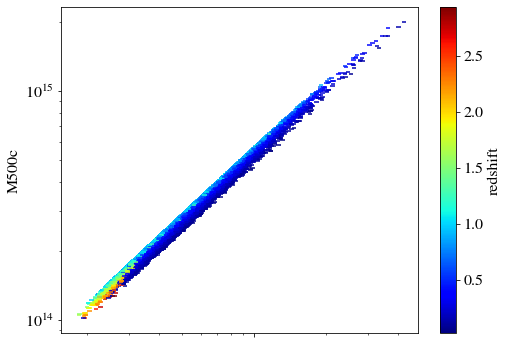

In [14]:

# m500cs = data.field("M500")
# m200ms = data.field("M200m")
# y_c = data.field("y_c")
df.plot.scatter("M200m","M500c",c="redshift", cmap='jet',marker=1)
plt.loglog()
# plt.legend()

<Figure size 576x432 with 0 Axes>

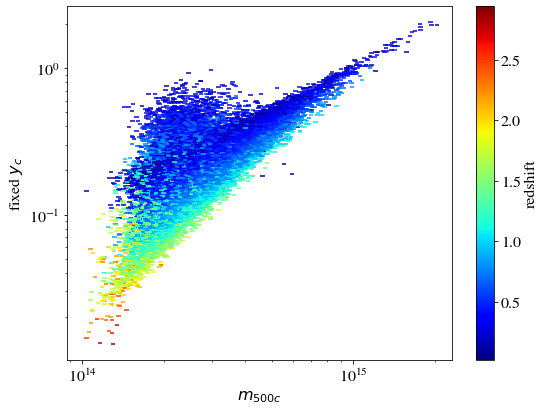

In [15]:
plt.figure()
ax = df.plot(kind="scatter",x="M500c",y="y_c_over_Ez2",c="redshift", cmap='jet',marker=1, sharex=False)
plt.loglog()
ax.set_ylabel(r"fixed $y_c$")
ax.set_xlabel(r"$m_{500c}$")
plt.tight_layout()
# plt.show()
# plt.grid()

In [68]:
df_so_cut = pd.merge(df, df_websky_cut, how='inner', on=['redshift','name'])
df_so_cut

,M200m_x,M500c_x,redshift,y_c,SNR,name,fixed_y_c,fixed_SNR,decDeg_x,y_c_over_Ez2,M200m_y,M500c_y,decDeg_y
0,5.482577e+14,3.174886e+14,1.230438,0.573160,8.652821,SO-CL J0000.0-0207,0.685775,8.540124,-2.123842,0.138714,3.067892e+14,1.800876e+14,-2.121216
1,4.851615e+14,2.652659e+14,0.311749,0.332783,6.763545,SO-CL J0000.0-6015,0.430087,6.543895,-60.259410,0.239433,5.327689e+14,2.803910e+14,-60.261047
2,4.751891e+14,2.781727e+14,0.985001,0.424044,6.500304,SO-CL J0000.1-0604,0.510689,6.434868,-6.070684,0.136089,5.171511e+14,2.977027e+14,-6.070442
3,2.738110e+14,1.545051e+14,1.772472,0.249817,4.738135,SO-CL J0000.1-1840,0.344519,4.492719,-18.679979,0.034214,2.048220e+14,1.207156e+14,-18.674484
4,1.014308e+15,5.244704e+14,0.197431,0.699576,12.590344,SO-CL J0000.3-1049,0.902336,11.273216,-10.829660,0.572324,1.104035e+15,5.496402e+14,-10.830849
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19488,4.188044e+14,2.454093e+14,0.812866,0.410144,5.215079,SO-CL J2359.9-0913,0.410144,5.215079,-9.222469,0.161611,5.879861e+14,3.338723e+14,-9.223587
19489,5.845295e+14,3.356987e+14,0.609932,0.499092,7.403237,SO-CL J2359.9-4029,0.578439,7.403552,-40.492179,0.251549,5.608934e+14,3.121614e+14,-40.492645
19490,4.634598e+14,2.464252e+14,0.218872,0.331083,5.856641,SO-CL J2359.9-1352,0.421021,5.066024,-13.883298,0.264557,5.150645e+14,2.643337e+14,-13.880302
19491,6.886024e+14,3.740221e+14,0.318073,0.487757,6.752809,SO-CL J2359.9+0230,0.671116,6.060357,2.504207,0.348384,8.602998e+14,4.471256e+14,2.500832


<Figure size 576x432 with 0 Axes>

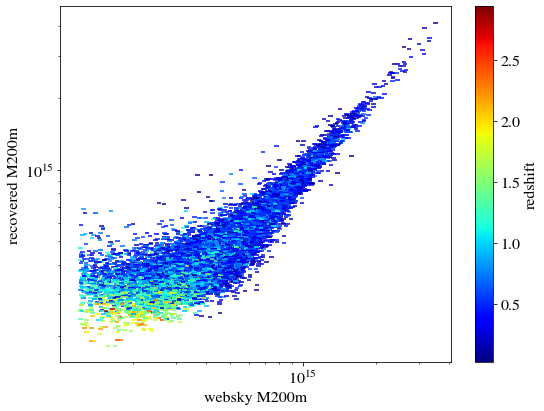

In [70]:
plt.figure()
ax = df_so_cut.plot(kind="scatter",x="M200m_y",y="M200m_x",c="redshift", cmap='jet',marker=1, sharex=False)
plt.loglog()
ax.set_ylabel(r"recovered M200m")
ax.set_xlabel(r"websky M200m")
plt.tight_layout()

<Figure size 576x432 with 0 Axes>

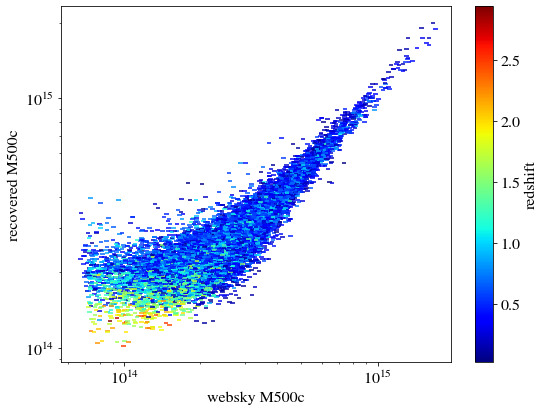

In [157]:
plt.figure()
ax = df_so_cut.plot(kind="scatter",x="M500c_y",y="M500c_x",c="redshift", cmap='jet',marker=1, sharex=False)
plt.loglog()
ax.set_ylabel(r"recovered M500c")
ax.set_xlabel(r"websky M500c")
plt.tight_layout()

<Figure size 576x432 with 0 Axes>

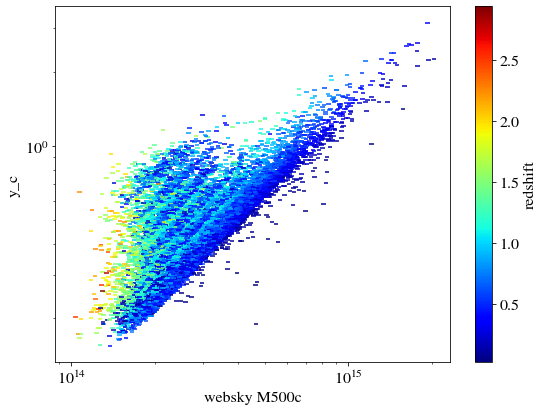

In [160]:
plt.figure()
ax = df_so_cut.plot(kind="scatter",x="M500c_x",y="y_c",c="redshift", cmap='jet',marker=1, sharex=False)
plt.loglog()
ax.set_ylabel(r"y_c")
ax.set_xlabel(r"websky M500c")
plt.tight_layout()

In [79]:
M.h()

0.68

In [73]:
3.067892e+14/5.482577e+14

0.5595711651655781

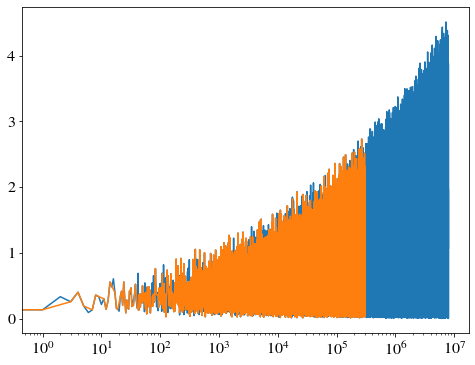

In [87]:
plt.plot(redshift)
plt.plot(df_websky_cut["redshift"])
plt.xscale('log')

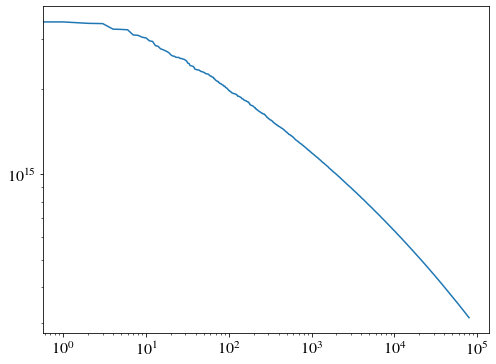

In [18]:
plt.plot(M200m)
#plt.plot(df_websky_cut["M200m"])
plt.yscale('log')
plt.xscale('log')

In [24]:
print("%.3e"%M200m.min())
print("%.3e"%M200m.max())
print("%.3e"%df["M200m"].min())
print("%.3e"%df["M200m"].max())

1.186e+14
3.464e+15
1.823e+14
4.140e+15


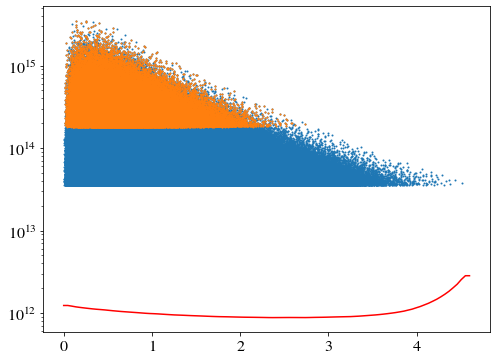

In [89]:
plt.scatter(redshift,M200m,marker='o',s=1.,label='websky catalogue')
plt.scatter(df_websky_cut["redshift"],df_websky_cut["M200m"],marker='o',s=1.,label='websky catalogue cut')
L=np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/so_cluster_counts/halos_mass_completion_websky.txt')
plt.plot(L[:,0],L[:,1],label='completeness',c='r')
plt.yscale('log')

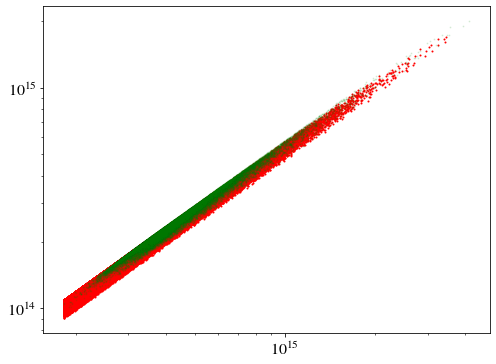

In [93]:
plt.scatter(df_websky_cut["M200m"],df_websky_cut["M500c"],label='websky',c='r',s=1)
plt.scatter(df["M200m"],df["M500c"],label='nemo',c='g',alpha=0.1,s=1)
plt.yscale('log')
plt.xscale('log')

In [274]:
M.T_cmb()

2.7255

In [275]:
import scipy
# range of integration of the reduced pressure profile:
x= np.logspace(-8,2,1000)
m500c_pivot = 3e14*0.7 # [Msun/h]

def E(zp):
    return M.Hubble(zp)/M.Hubble(0.)

vec_get_dy_classy_gnfw = np.vectorize(M.get_1e6xdy_from_gnfw_pressure_at_x_z_and_m500c)
vec_get_dy_classy_battaglia = np.vectorize(M.get_1e6xdy_from_battaglia_pressure_at_x_z_and_m200c)

def y0_over_Ez2_over_mfid_gnfw_at_m_and_z(m_over_m_pivot_500c,z):
    m500c = m_over_m_pivot_500c*m500c_pivot
    pp_gnfw = []
    #for xx in x:
        #pp_gnfw.append(M.get_1e6xdy_from_gnfw_pressure_at_x_z_and_m500c(xx,z,m))
    pp_gnfw = vec_get_dy_classy_gnfw(x,z,m500c)
    norm_gnfw = 2.*np.trapz(pp_gnfw, x=x)/E(z)**2*1e-6/m_over_m_pivot_500c
    return norm_gnfw
QF = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/so_3freqs_020621_theta500arcmin_Q.txt')
get_Q_of_theta500 = interp1d(QF[:,0],QF[:,1],fill_value='extrapolate')


def get_y0_at_m_and_z_H13(m,z,A,B):
    Eh = E(z)
    t = -0.00848*pow(m/(3.e14*70./(h*100.))*Eh,-0.585)
    f_rel = 1. + 3.79*t -28.2*t*t
    f_rel = 1.
    yp = A*pow(Eh,2.)*pow(m/(3.e14*70./(h*100.)),1.+B)*f_rel
    return yp

def get_yc_at_m_and_z_H13(m,z,A,B):
    Eh = E(z)
    #t = -0.00848*pow(m/(3.e14*70./(h*100.))*Eh,-0.585)
    #f_rel = 1. + 3.79*t -28.2*t*t
    ##  f_rel = 1.
    f_rel = calcFRel(z, m)
    vec_theta = np.vectorize(M.get_theta_at_m_and_z)
    theta_500 = vec_theta(m,z)
    yp = A*pow(Eh,2.)*pow(m/(3.e14*h),1.+B)*f_rel*get_Q_of_theta500(theta_500)
    return yp

def get_m500c_of_yc_at_z(yc,zz,A,B):
    def fun(lnm):
        return yc - get_yc_at_m_and_z_H13(np.exp(lnm),zz,A,B)
    sol = scipy.optimize.brentq(fun, np.log(1e10), np.log(1e17))
    return np.exp(sol)


def calcFRel(z, M500, obsFreqGHz = 148.0):
    """Calculates relativistic correction to SZ effect at specified frequency, given z, M500 in MSun.

    This assumes the Arnaud et al. (2005) M-T relation, and applies formulae of Itoh et al. (1998)

    As for H13, we return fRel = 1 + delta_SZE (see also Marriage et al. 2011)

    """
    M500 = M500/h
    Ez = E(z)

    # NOTE: we should define constants somewhere else...
    hplanck=6.63e-34
    kB=1.38e-23
    sigmaT=6.6524586e-29
    me=9.11e-31
    e=1.6e-19
    c=3e8
    TCMB = M.T_cmb()

    # Using Arnaud et al. (2005) M-T to get temperature
    A=3.84e14
    B=1.71
    #TkeV=5.*np.power(((cosmoModel.efunc(z)*M500)/A), 1/B)   # HMF/Astropy
    #TkeV=5.*np.power(((cosmoModel.Ez(z)*M500)/A), 1/B)   # Colossus
    TkeV=5.*np.power(((Ez*M500)/A), 1/B)
    TKelvin=TkeV*((1000*e)/kB)

    # Itoh et al. (1998) eqns. 2.25 - 2.30
    thetae=(kB*TKelvin)/(me*c**2)
    X=(hplanck*obsFreqGHz*1e9)/(kB*TCMB)
    Xtw=X*(np.cosh(X/2.)/np.sinh(X/2.))
    Stw=X/np.sinh(X/2.)

    Y0=-4+Xtw

    Y1=-10. + (47/2.)*Xtw - (42/5.)*Xtw**2 + (7/10.)*Xtw**3 + np.power(Stw, 2)*(-(21/5.) + (7/5.)*Xtw)

    Y2=-(15/2.) +  (1023/8.)*Xtw - (868/5.)*Xtw**2 + (329/5.)*Xtw**3 - (44/5.)*Xtw**4 + (11/30.)*Xtw**5 \
        + np.power(Stw, 2)*(-(434/5.) + (658/5.)*Xtw - (242/5.)*Xtw**2 + (143/30.)*Xtw**3) \
        + np.power(Stw, 4)*(-(44/5.) + (187/60.)*Xtw)

    Y3=(15/2.) + (2505/8.)*Xtw - (7098/5.)*Xtw**2 + (14253/10.)*Xtw**3 - (18594/35.)*Xtw**4 + (12059/140.)*Xtw**5 - (128/21.)*Xtw**6 + (16/105.)*Xtw**7 \
        + np.power(Stw, 2)*(-(7098/10.) + (14253/5.)*Xtw - (102267/35.)*Xtw**2 + (156767/140.)*Xtw**3 - (1216/7.)*Xtw**4 + (64/7.)*Xtw**5) \
        + np.power(Stw, 4)*(-(18594/35.) + (205003/280.)*Xtw - (1920/7.)*Xtw**2 + (1024/35.)*Xtw**3) \
        + np.power(Stw, 6)*(-(544/21.) + (992/105.)*Xtw)

    Y4=-(135/32.) + (30375/128.)*Xtw - (62391/10.)*Xtw**2 + (614727/40.)*Xtw**3 - (124389/10.)*Xtw**4 \
        + (355703/80.)*Xtw**5 - (16568/21.)*Xtw**6 + (7516/105.)*Xtw**7 - (22/7.)*Xtw**8 + (11/210.)*Xtw**9 \
        + np.power(Stw, 2)*(-(62391/20.) + (614727/20.)*Xtw - (1368279/20.)*Xtw**2 + (4624139/80.)*Xtw**3 - (157396/7.)*Xtw**4 \
        + (30064/7.)*Xtw**5 - (2717/7.)*Xtw**6 + (2761/210.)*Xtw**7) \
        + np.power(Stw, 4)*(-(124389/10.) + (6046951/160.)*Xtw - (248520/7.)*Xtw**2 + (481024/35.)*Xtw**3 - (15972/7.)*Xtw**4 + (18689/140.)*Xtw**5) \
        + np.power(Stw, 6)*(-(70414/21.) + (465992/105.)*Xtw - (11792/7.)*Xtw**2 + (19778/105.)*Xtw**3) \
        + np.power(Stw, 8)*(-(682/7.) + (7601/210.)*Xtw)

    deltaSZE=((X**3)/(np.exp(X)-1)) * ((thetae*X*np.exp(X))/(np.exp(X)-1)) * (Y0 + Y1*thetae + Y2*thetae**2 + Y3*thetae**3 + Y4*thetae**4)

    fRel=1+deltaSZE

    return fRel


In [276]:
M500c_zk = [float(num) for num in """1.00000000e+13 1.02329299e+13 1.04712855e+13 1.07151931e+13
 1.09647820e+13 1.12201845e+13 1.14815362e+13 1.17489755e+13
 1.20226443e+13 1.23026877e+13 1.25892541e+13 1.28824955e+13
 1.31825674e+13 1.34896288e+13 1.38038426e+13 1.41253754e+13
 1.44543977e+13 1.47910839e+13 1.51356125e+13 1.54881662e+13
 1.58489319e+13 1.62181010e+13 1.65958691e+13 1.69824365e+13
 1.73780083e+13 1.77827941e+13 1.81970086e+13 1.86208714e+13
 1.90546072e+13 1.94984460e+13 1.99526231e+13 2.04173794e+13
 2.08929613e+13 2.13796209e+13 2.18776162e+13 2.23872114e+13
 2.29086765e+13 2.34422882e+13 2.39883292e+13 2.45470892e+13
 2.51188643e+13 2.57039578e+13 2.63026799e+13 2.69153480e+13
 2.75422870e+13 2.81838293e+13 2.88403150e+13 2.95120923e+13
 3.01995172e+13 3.09029543e+13 3.16227766e+13 3.23593657e+13
 3.31131121e+13 3.38844156e+13 3.46736850e+13 3.54813389e+13
 3.63078055e+13 3.71535229e+13 3.80189396e+13 3.89045145e+13
 3.98107171e+13 4.07380278e+13 4.16869383e+13 4.26579519e+13
 4.36515832e+13 4.46683592e+13 4.57088190e+13 4.67735141e+13
 4.78630092e+13 4.89778819e+13 5.01187234e+13 5.12861384e+13
 5.24807460e+13 5.37031796e+13 5.49540874e+13 5.62341325e+13
 5.75439937e+13 5.88843655e+13 6.02559586e+13 6.16595002e+13
 6.30957344e+13 6.45654229e+13 6.60693448e+13 6.76082975e+13
 6.91830971e+13 7.07945784e+13 7.24435960e+13 7.41310241e+13
 7.58577575e+13 7.76247117e+13 7.94328235e+13 8.12830516e+13
 8.31763771e+13 8.51138038e+13 8.70963590e+13 8.91250938e+13
 9.12010839e+13 9.33254301e+13 9.54992586e+13 9.77237221e+13
 1.00000000e+14 1.02329299e+14 1.04712855e+14 1.07151931e+14
 1.09647820e+14 1.12201845e+14 1.14815362e+14 1.17489755e+14
 1.20226443e+14 1.23026877e+14 1.25892541e+14 1.28824955e+14
 1.31825674e+14 1.34896288e+14 1.38038426e+14 1.41253754e+14
 1.44543977e+14 1.47910839e+14 1.51356125e+14 1.54881662e+14
 1.58489319e+14 1.62181010e+14 1.65958691e+14 1.69824365e+14
 1.73780083e+14 1.77827941e+14 1.81970086e+14 1.86208714e+14
 1.90546072e+14 1.94984460e+14 1.99526231e+14 2.04173794e+14
 2.08929613e+14 2.13796209e+14 2.18776162e+14 2.23872114e+14
 2.29086765e+14 2.34422882e+14 2.39883292e+14 2.45470892e+14
 2.51188643e+14 2.57039578e+14 2.63026799e+14 2.69153480e+14
 2.75422870e+14 2.81838293e+14 2.88403150e+14 2.95120923e+14
 3.01995172e+14 3.09029543e+14 3.16227766e+14 3.23593657e+14
 3.31131121e+14 3.38844156e+14 3.46736850e+14 3.54813389e+14
 3.63078055e+14 3.71535229e+14 3.80189396e+14 3.89045145e+14
 3.98107171e+14 4.07380278e+14 4.16869383e+14 4.26579519e+14
 4.36515832e+14 4.46683592e+14 4.57088190e+14 4.67735141e+14
 4.78630092e+14 4.89778819e+14 5.01187234e+14 5.12861384e+14
 5.24807460e+14 5.37031796e+14 5.49540874e+14 5.62341325e+14
 5.75439937e+14 5.88843655e+14 6.02559586e+14 6.16595002e+14
 6.30957344e+14 6.45654229e+14 6.60693448e+14 6.76082975e+14
 6.91830971e+14 7.07945784e+14 7.24435960e+14 7.41310241e+14
 7.58577575e+14 7.76247117e+14 7.94328235e+14 8.12830516e+14
 8.31763771e+14 8.51138038e+14 8.70963590e+14 8.91250938e+14
 9.12010839e+14 9.33254301e+14 9.54992586e+14 9.77237221e+14
 1.00000000e+15 1.02329299e+15 1.04712855e+15 1.07151931e+15
 1.09647820e+15 1.12201845e+15 1.14815362e+15 1.17489755e+15
 1.20226443e+15 1.23026877e+15 1.25892541e+15 1.28824955e+15
 1.31825674e+15 1.34896288e+15 1.38038426e+15 1.41253754e+15
 1.44543977e+15 1.47910839e+15 1.51356125e+15 1.54881662e+15
 1.58489319e+15 1.62181010e+15 1.65958691e+15 1.69824365e+15
 1.73780083e+15 1.77827941e+15 1.81970086e+15 1.86208714e+15
 1.90546072e+15 1.94984460e+15 1.99526231e+15 2.04173794e+15
 2.08929613e+15 2.13796209e+15 2.18776162e+15 2.23872114e+15
 2.29086765e+15 2.34422882e+15 2.39883292e+15 2.45470892e+15
 2.51188643e+15 2.57039578e+15 2.63026799e+15 2.69153480e+15
 2.75422870e+15 2.81838293e+15 2.88403150e+15 2.95120923e+15
 3.01995172e+15 3.09029543e+15 3.16227766e+15 3.23593657e+15
 3.31131121e+15 3.38844156e+15 3.46736850e+15 3.54813389e+15
 3.63078055e+15 3.71535229e+15 3.80189396e+15 3.89045145e+15
 3.98107171e+15 4.07380278e+15 4.16869383e+15 4.26579519e+15
 4.36515832e+15 4.46683592e+15 4.57088190e+15 4.67735141e+15
 4.78630092e+15 4.89778819e+15 5.01187234e+15 5.12861384e+15
 5.24807460e+15 5.37031796e+15 5.49540874e+15 5.62341325e+15
 5.75439937e+15 5.88843655e+15 6.02559586e+15 6.16595002e+15
 6.30957344e+15 6.45654229e+15 6.60693448e+15 6.76082975e+15
 6.91830971e+15 7.07945784e+15 7.24435960e+15 7.41310241e+15
 7.58577575e+15 7.76247117e+15 7.94328235e+15 8.12830516e+15
 8.31763771e+15 8.51138038e+15 8.70963590e+15 8.91250938e+15
 9.12010839e+15 9.33254301e+15 9.54992586e+15 9.77237221e+15""".split()]


In [ ]:
M500c_zk = np.geomspace(1.00000000e+12,1e16,300)
log10M500c_zk = np.log10(M500c_zk)

In [277]:
log10M500c_zk = np.log10(M500c_zk)
zk =0.40633456316230765
theta500s = np.vectorize(M.get_theta_at_m_and_z)(10**log10M500c_zk,zk)
theta500s

array([0.98164505, 0.98920844, 0.99683011, 1.0045105 , 1.01225007,
       1.02004927, 1.02790856, 1.0358284 , 1.04380926, 1.05185162,
       1.05995594, 1.06812271, 1.07635239, 1.08464549, 1.09300248,
       1.10142386, 1.10991013, 1.11846178, 1.12707932, 1.13576326,
       1.1445141 , 1.15333237, 1.16221858, 1.17117326, 1.18019693,
       1.18929013, 1.19845339, 1.20768725, 1.21699226, 1.22636895,
       1.2358179 , 1.24533965, 1.25493476, 1.2646038 , 1.27434733,
       1.28416594, 1.2940602 , 1.3040307 , 1.31407801, 1.32420274,
       1.33440547, 1.34468682, 1.35504738, 1.36548777, 1.3760086 ,
       1.38661049, 1.39729407, 1.40805996, 1.4189088 , 1.42984123,
       1.44085789, 1.45195943, 1.46314651, 1.47441978, 1.48577991,
       1.49722757, 1.50876343, 1.52038817, 1.53210248, 1.54390704,
       1.55580256, 1.56778973, 1.57986926, 1.59204186, 1.60430824,
       1.61666914, 1.62912527, 1.64167738, 1.6543262 , 1.66707248,
       1.67991696, 1.69286041, 1.70590358, 1.71904725, 1.73229

In [278]:
get_Q_of_theta500(theta500s)

array([0.36826525, 0.3722987 , 0.37636322, 0.38045905, 0.38458645,
       0.38874564, 0.39293688, 0.39716042, 0.40141649, 0.40570536,
       0.41002727, 0.41438248, 0.41877125, 0.42319383, 0.42765049,
       0.43214148, 0.43666708, 0.44122755, 0.44582315, 0.45045416,
       0.45506199, 0.45962431, 0.46422178, 0.46885467, 0.47352326,
       0.47822782, 0.48296862, 0.48774596, 0.4925601 , 0.49741134,
       0.50229995, 0.50722622, 0.51219046, 0.51719294, 0.52223397,
       0.52731383, 0.53243284, 0.53759129, 0.54278948, 0.54802772,
       0.55330632, 0.55862559, 0.56398585, 0.56913017, 0.57423916,
       0.57938753, 0.58457556, 0.58980356, 0.59507184, 0.60038072,
       0.6057305 , 0.6111215 , 0.61655403, 0.62202842, 0.62754499,
       0.63310406, 0.63870597, 0.64435104, 0.6500396 , 0.65577199,
       0.66154855, 0.66736961, 0.67323553, 0.67914664, 0.6851033 ,
       0.69103124, 0.69649595, 0.70200276, 0.70755199, 0.71314399,
       0.71877907, 0.72445757, 0.73017982, 0.73594615, 0.74175

In [315]:
from scipy import interpolate
def getM500_from_y0_H13(y0,log_y0Err,A,B,z):
    # y0 is fixed_y_c*1e-4 in the catalogue
    # log_y0Err is fixed_err_y_c in the catalogue
    # returns:
    # M500*1e14, M500_errPlus*1e14, M500_errMinus*1e14 in Msun
    y0 = 4.300866216556414e-05
    log_y0Err = 0.15281418703049873
    sigma_int = 0.2
    log_y0 = np.log(y0)
    A = 2.65e-05
    B = 0.
    z = 0.31174946578600604
    m = (10**log10M500c_zk)*h
    log_y0pred = np.log(get_yc_at_m_and_z_H13(m,z,A,B)) # feeds in m500c in Msun/h
    Py0GivenM=np.exp(-np.power(log_y0-log_y0pred, 2)/(2*(np.power(log_y0Err, 2)+np.power(sigma_int, 2))))
    Py0GivenM=Py0GivenM/np.trapz(Py0GivenM, log10M500c_zk)
    PLog10M = 1.
    Pz = 1.
    P=Py0GivenM*PLog10M*Pz
    PArr = P
    PArr=np.array(PArr)
    P = PArr
    P=P/np.trapz(P, log10M500c_zk)

    calcErrors = True

    """Returns M500 as the maximum likelihood value from given P(log10M) distribution, together with
    1-sigma error bars (M500, -M500Err, +M500 err).

    """
    log10M = log10M500c_zk
    # Find max likelihood and integrate to get error bars
    tckP=interpolate.splrep(log10M, P)
    fineLog10M=np.linspace(log10M.min(), log10M.max(), 10000)
    fineP=interpolate.splev(fineLog10M, tckP)
    fineP=fineP/np.trapz(fineP, fineLog10M)
    index=np.argmax(fineP)

    clusterLogM500=fineLog10M[index]
    clusterM500=np.power(10, clusterLogM500)/1e14


    for n in range(fineP.shape[0]):
        minIndex=index-n
        maxIndex=index+n
        if minIndex < 0 or maxIndex > fineP.shape[0]:
            # This shouldn't happen; if it does, probably y0 is in the wrong units
            # Previously we threw an exception here, but we can't if using this for forced photometry
            #print("WARNING: outside M500 range - check y0 units or for problem at cluster location in map (if not in forced photometry mode)")
            clusterM500MinusErr=0.
            clusterM500PlusErr=0.
            break
        p=np.trapz(fineP[minIndex:maxIndex], fineLog10M[minIndex:maxIndex])
        if p >= 0.6827:
            clusterLogM500Min=fineLog10M[minIndex]
            clusterLogM500Max=fineLog10M[maxIndex]
            clusterM500MinusErr=(np.power(10, clusterLogM500)-np.power(10, clusterLogM500Min))/1e14
            clusterM500PlusErr=(np.power(10, clusterLogM500Max)-np.power(10, clusterLogM500))/1e14
            break

    return clusterM500*1e14, clusterM500MinusErr*1e14, clusterM500PlusErr*1e14


In [312]:
print("m500c = %.3e errMinus = %.3e errPlus = %.3e"%getM500())

m500c = 2.960e+14 errMinus = 5.820e+13 errPlus = 7.244e+13


In [316]:
df_masses

,y_c,err_y_c,M500c,M200m,SNR,name,fixed_y_c,fixed_err_y_c,fixed_SNR,decDeg
0,0.573160,0.066240,3.603709,6.240871,8.652821,SO-CL J0000.0-0207,0.685775,0.080300,8.540124,-2.123842
1,0.332783,0.049202,2.996468,5.496536,6.763545,SO-CL J0000.0-6015,0.430087,0.065723,6.543895,-60.259410
2,0.199920,0.046100,0.000000,0.000000,4.336629,SO-CL J0000.0-6211,0.247447,0.064357,3.844894,-62.187500
3,0.424044,0.065235,0.000000,0.000000,6.500304,SO-CL J0000.1-0604,0.510689,0.079363,6.434868,-6.070684
4,0.249817,0.052725,0.000000,0.000000,4.738135,SO-CL J0000.1-1840,0.344519,0.076684,4.492719,-18.679979
...,...,...,...,...,...,...,...,...,...,...
30132,0.320097,0.058307,0.000000,0.000000,5.489862,SO-CL J2359.9-0525,0.417228,0.078572,5.310148,-5.424936
30133,0.499092,0.067415,0.000000,0.000000,7.403237,SO-CL J2359.9-4029,0.578439,0.078130,7.403552,-40.492179
30134,0.331083,0.056531,0.000000,0.000000,5.856641,SO-CL J2359.9-1352,0.421021,0.083107,5.066024,-13.883298
30135,0.487757,0.072230,0.000000,0.000000,6.752809,SO-CL J2359.9+0230,0.671116,0.110739,6.060357,2.504207


In [ ]:
M.get_m200m_to_m500c_at_z_and_M(zz,mm*h)
M.get_m2

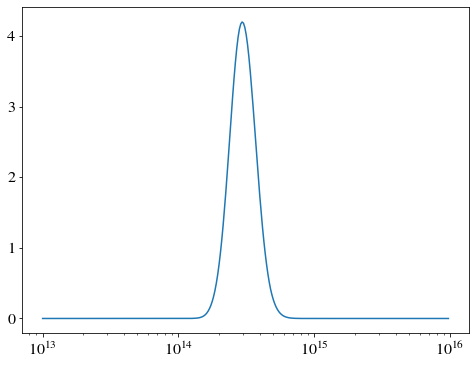

In [298]:
plt.plot(10**log10M500c_zk,P)
plt.xscale('log')

/usr/local/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: divide by zero encountered in get_theta_at_m_and_z (vectorized)
  outputs = ufunc(*inputs)


'2.8031e+12'

/usr/local/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: divide by zero encountered in get_theta_at_m_and_z (vectorized)
  outputs = ufunc(*inputs)
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: divide by zero encountered in get_yc_at_m_and_z_H13 (vectorized)
  outputs = ufunc(*inputs)


<Figure size 576x432 with 0 Axes>

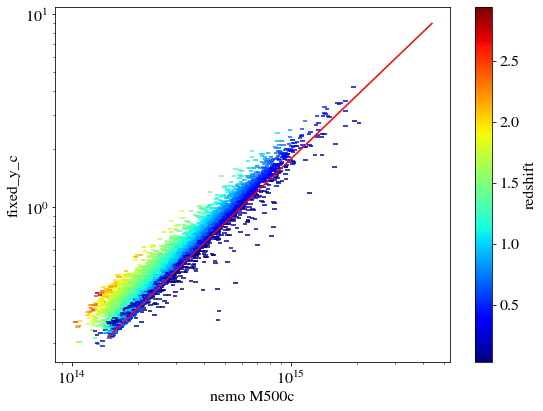

In [196]:
plt.figure()
ax = df_so_cut.plot(kind="scatter",x="M500c_x",y="fixed_y_c",c="redshift", cmap='jet',marker=1, sharex=False)
mm = np.geomspace(1e14,3e15,100)
A = 4.95e-5
B = 0.08
z = 0.
yyc = np.vectorize(get_yc_at_m_and_z_H13)(mm,z,A,B)
plt.plot(mm/h,yyc*1e4,c='r')
plt.loglog()
ax.set_ylabel(r"fixed_y_c")
ax.set_xlabel(r"nemo M500c")
plt.tight_layout()

In [240]:
# test on one cluster:
m500c_test = df["M500c"][0]*1e14*h
redshift_test = df["redshift"][0]
print("m500c = %.3e Msun/h"%m500c_test)
print("redshift_test = %.3e"%redshift_test)
print("E(z) = %.3e"%E(redshift_test))
theta_500 = M.get_theta_at_m_and_z(m500c_test,redshift_test)
y0_over_Ez2_over_mfid = y0_over_Ez2_over_mfid_gnfw_at_m_and_z(m500c_test/m500c_pivot,redshift_test)
y0 = y0_over_Ez2_over_mfid*E(redshift_test)**2.*(m500c_test/m500c_pivot)#*get_Q_of_theta500(theta_500)

A = 2.65e-5
B = 0.0
y0_h13 = get_y0_at_m_and_z_H13(m500c_test,redshift_test,A,B)*get_Q_of_theta500(theta_500)
print("y0 (H13) = %.3e y0 boris = %.3e SNR = %.3e  fixed_SNR = %.3e y_c = %.3e fixed_y_c = %.3e"%(y0_h13,y0,df["SNR"][0],df["fixed_SNR"][0],df["y_c"][0],df["fixed_y_c"][0]))

m500c = 2.159e+28 Msun/h
redshift_test = 1.230e+00
E(z) = 2.014e+00
y0 (H13) = 3.804e+11 y0 boris = 2.046e+13 SNR = 8.653e+00  fixed_SNR = 8.540e+00 y_c = 5.732e-01 fixed_y_c = 6.858e-01


In [27]:

get_Q_of_theta500(theta_500)

array(0.53061114)

In [239]:
df["redshift"][0]

1.230437635667177

# Computing cluster abundance

matches high-accuracy cosmomc at 0.2% level

In [30]:
M = Class()


best_fit_planck_new_sigmaM ={
    'H0':  68.576660156250000 ,
    'sigma8': 0.75290221947553726 ,
   'omega_cdm': 1.2547102E-01,
   'omega_b': 2.1865653E-02,
   'tau_reio': 0.09,
   'n_s': 9.5611087E-01,
    
    'alpha_ym': 1.8674885E+00,
    'ystar_ym': -1.8663318E-01,
    'sigmaM_ym': 1.6903344E-01,
    'B': 1./(7.7068241E-01)
}

best_fit_planck_old_sigmaM ={
   'H0': 67.834472656250000,
    'sigma8':0.76886885293327345,
   'omega_cdm': 1.1707694E-01,
   'omega_b': 2.1572441E-02,
   'tau_reio': 0.09,
   'n_s': 9.6892923E-01,
    
    'alpha_ym': 1.8226235E+00,
    'ystar_ym': -1.9139607E-01,
    'sigmaM_ym': 7.0815376E-02,
    'B': 1./(7.6169989E-01)
}


cosmomc_default = {
    
'h':0.67702636718750000,
'omega_b': 2.2100000000000002e-2,
'omega_cdm':0.12000000000000000,
'n_s':0.95999999999999996,
'A_s': 22.197951281441636e-10,
'tau_reio':0.0543,

'B': 1.25,
'sigmaM_ym': 0.075,
'ystar_ym': -0.186,
'alpha_ym': 1.7889999999999999
}
M.set(best_fit_planck_old_sigmaM)

M.set({
          'output' : 'sz_cluster_counts',
          'mass function' : 'M500',
          'integrate_wrt_m500c' : 1,
          'has_selection_function' : 1,
          'experiment' : 0,
          'y_m_relation' : 0,
          'signal-to-noise cut-off for survey cluster completeness' : 6.,
          'N_ur': 2.0328,
          'N_ncdm': 1,
          'm_ncdm': 0.06,
          'T_ncdm': 0.71611,
          'input_verbose' : 0,
          'background_verbose': 3,
          'perturbations_verbose': 0,
          'sz_verbose'  : 3,

          'bin_z_min_cluster_counts' : 0.,
          'bin_z_max_cluster_counts' : 1.,
          'bin_dz_cluster_counts' : 0.1,
          'bin_dlog10_snr': 0.25,

          'dlny' : 0.02,
          'lnymin' : -11.5,
          'lnymax' : 10.,
          'dlnM_cluster_count_completeness_grid' : 0.02,


          'cluster_count_completeness_grid_z_cutoff_low' : 0.2,
          'cluster_count_completeness_grid_z_cutoff_mid' : 1.,

          'dz_cluster_count_completeness_grid_low_z' : 1e-3,
          'dz_cluster_count_completeness_grid_mid_z' : 1e-2,
          'dz_cluster_count_completeness_grid_high_z' : 1e-1,

          'mass_epsrel_cluster_counts' : 1e-4,
          'mass_epsabs_cluster_counts' : 1e-40,

          'redshift_epsrel_cluster_counts' : 1e-4,
          'redshift_epsabs_cluster_counts' : 1e-40,

#           # # tabulation of mass function:
          'n_z_dndlnM' : 200,
          'n_m_dndlnM' : 200,
#           #
#           # # computation of mass function
#           # # (grid in mass and redshifts for sigma and dsigma)
          'ndim_masses' : 200,
          'ndim_redshifts' : 200,

#           # pk setup for computation of sigma and dsigma
    
          'k_per_decade_class_sz' : 40., #important parameter
          'k_min_for_pk_class_sz' : 1e-4,
          'k_max_for_pk_class_sz' : 2e0,

          'P_k_max_h/Mpc' : 2e1
    
})
M.compute()
print(M.sigma8())
print(M.get_sigma8_at_z(0.0002))
print(M.get_sigma8_at_z(0.0))

0.7688690299166802
0.7691159765074382
0.7691954289761858


In [31]:
M.get_current_derived_parameters(['h'])

{'h': 0.6783447265625}

In [32]:
M.Hubble(0.)

0.00022627144494825817

In [33]:
dNdzdy_theoretical = M.dndzdy_theoretical()['dndzdy']
z_center = M.dndzdy_theoretical()['z_center']
z_edges = M.dndzdy_theoretical()['z_edges']
log10y_center = M.dndzdy_theoretical()['log10y_center']
log10y_edges = M.dndzdy_theoretical()['log10y_edges']
M.struct_cleanup()
M.empty()



In [34]:
np.sum(dNdzdy_theoretical)

402.81720410137245

In [237]:
np.sum(dNdzdy_theoretical)

402.81720410137245

In [35]:
N_z,N_y = np.shape(dNdzdy_theoretical)
N_clusters_z_theory = []
for iz in range(N_z):
    N_clusters_z_theory.append(np.sum(dNdzdy_theoretical[iz]))
N_clusters_y_theory = []
for iy in range(N_y):
    N_clusters_y_theory.append(np.sum(np.asarray(dNdzdy_theoretical)[:,iy]))




No handles with labels found to put in legend.


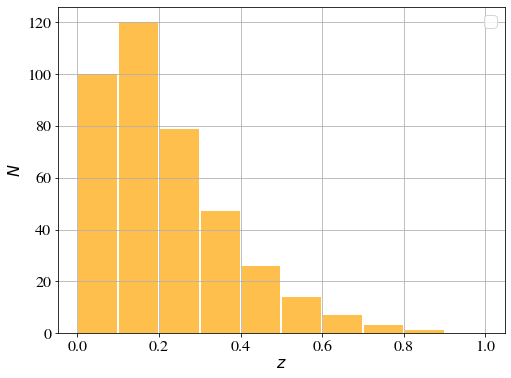

In [36]:
#N_clusters_z, xedges = np.histogram(z, bins=z_edges)
# plt.errorbar(z_center,N_clusters_z,yerr=np.sqrt(N_clusters_z),marker='o',markersize=3.,ls='none',label='catalogue data',capsize=5,c='k')
#plt.hist(z_center,N_clusters_z_theory,marker='o',markersize=3.,ls=':',label='theory',c='orange')
n, bins, patches = plt.hist(x=np.repeat(z_center,N_clusters_z_theory), bins=z_edges, color='orange',alpha=0.7, rwidth=0.95)
plt.grid()
plt.legend(loc=1)
plt.xlabel(r'$z$')
plt.ylabel(r'$N$')
plt.yscale('linear')
# plt.ylim(1e0,5e3)

No handles with labels found to put in legend.


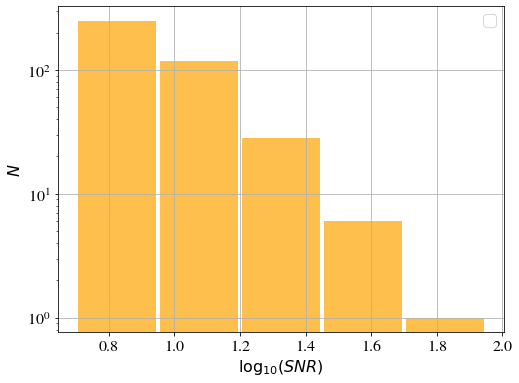

In [37]:
#N_clusters_y, xedges = np.histogram(np.log10(snr), bins=log10y_edges)
# plt.errorbar(log10y_center,N_clusters_y,yerr=np.sqrt(N_clusters_y),marker='o',markersize=3.,ls='none',label='catalogue data',capsize=5,c='k')
#plt.plot(log10y_center,N_clusters_y_theory,marker='o',markersize=3.,ls=':',label='theory',c='orange')
n, bins, patches = plt.hist(x=np.repeat(log10y_center,N_clusters_y_theory), bins=log10y_edges, color='orange',alpha=0.7, rwidth=0.95)


plt.grid()
plt.legend()
plt.xlabel(r'$\log_{10}(SNR)$')
plt.ylabel(r'$N$')
plt.yscale('log')

No handles with labels found to put in legend.


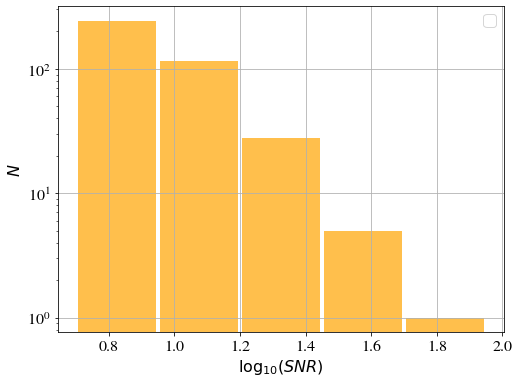

In [17]:
#N_clusters_y, xedges = np.histogram(np.log10(snr), bins=log10y_edges)
# plt.errorbar(log10y_center,N_clusters_y,yerr=np.sqrt(N_clusters_y),marker='o',markersize=3.,ls='none',label='catalogue data',capsize=5,c='k')
#plt.plot(log10y_center,N_clusters_y_theory,marker='o',markersize=3.,ls=':',label='theory',c='orange')
n, bins, patches = plt.hist(x=np.repeat(log10y_center,N_clusters_y_theory), bins=log10y_edges, color='orange',alpha=0.7, rwidth=0.95)


plt.grid()
plt.legend()
plt.xlabel(r'$\log_{10}(SNR)$')
plt.ylabel(r'$N$')
plt.yscale('log')

# connection between pressure profiles and y-m relations

In [71]:
M = Class()
cosmo_settings = {
                  'omega_cdm': 0.125,
                  'omega_b': 0.0224,
                  'A_s': 1.9e-9,
                  'n_s': 0.96,
                  'H0': 70.,
                  'tau_reio': 0.054, # planck 2018 value (in abstract of 1807.06209)
                  'YHe': 'BBN',

                  # 1 massive neutrino (planck 2018 baseline)
                  'N_ur': 2.0328,
                  'N_ncdm': 1,
                  'm_ncdm': 0.06,
                  'T_ncdm': 0.71611,
                   
                  'M2SZ': 5e16,


                  # X ray mass bias (if applicable)
                  'B' : 1.,
                  'output' : 'sz_cluster_counts,m200c_to_m500c,m500c_to_m200c',
                  'pressure profile': 'Custom. GNFW',
                  'P0GNFW': 8.403,
                  'c500':1.177,
                  'gammaGNFW':0.3081,
                  'alphaGNFW':1.0510,
                  'betaGNFW':5.4905
}

M.set(cosmo_settings)
M.compute()

In [ ]:

z=1.e-5
m200m_pivot = 3e14*0.7 # [Msun/h]


# corresponding m200c_pivot as a function of z:

z_array = np.linspace(0,3.,100)

m500c_over_m200m_pivot = []
for zz in z_array:
    m500c_over_m200m_pivot.append(M.get_m200m_to_m500c_at_z_and_M(zz,m200m_pivot)/m200m_pivot)


    
plt.plot(z_array,m200c_over_m500c_pivot)
plt.xlabel('z')
plt.ylabel('m500c/m200m')
plt.grid(which='both')

[]

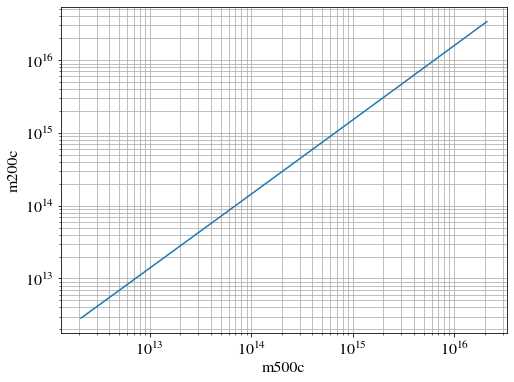

In [69]:
m500c_pivot = 3e14*0.7 # [Msun/h]
m500c_array = np.geomspace(1e-2,1e2,100)*m500c_pivot
m200c_array = []
for mm in m500c_array:
    m200c_array.append(M.get_m500c_to_m200c_at_z_and_M(z,mm))

plt.plot(m500c_array,m200c_array)
plt.xlabel('m500c')
plt.ylabel('m200c')
plt.grid(which='both')
plt.loglog()

In [70]:
# range of integration of the reduced pressure profile:
x= np.logspace(-8,2,1000)
m500c_pivot = 3e14*0.7 # [Msun/h]

def E(zp):
    return M.Hubble(zp)/M.Hubble(0.)

vec_get_dy_classy_gnfw = np.vectorize(M.get_1e6xdy_from_gnfw_pressure_at_x_z_and_m500c)
vec_get_dy_classy_battaglia = np.vectorize(M.get_1e6xdy_from_battaglia_pressure_at_x_z_and_m200c)

def y0_over_Ez2_over_mfid_gnfw_at_m_and_z(m_over_m_pivot_500c,z):
    m500c = m_over_m_pivot_500c*m500c_pivot
    pp_gnfw = []
    #for xx in x:
        #pp_gnfw.append(M.get_1e6xdy_from_gnfw_pressure_at_x_z_and_m500c(xx,z,m))
    pp_gnfw = vec_get_dy_classy_gnfw(x,z,m500c)
    norm_gnfw = 2.*np.trapz(pp_gnfw, x=x)/E(z)**2*1e-6/m_over_m_pivot_500c
    return norm_gnfw


def y0_over_Ez2_over_mfid_battaglia_at_m_and_z(m_over_m_pivot_500c,z):
    m500c = m_over_m_pivot_500c*m500c_pivot
    m200c = M.get_m500c_to_m200c_at_z_and_M(zz,m500c)
    pp_battaglia = []
    #for xx in x:
        #pp_gnfw.append(M.get_1e6xdy_from_gnfw_pressure_at_x_z_and_m500c(xx,z,m))
    pp_battaglia = vec_get_dy_classy_battaglia(x,z,m200c)
    norm_battaglia = 2.*np.trapz(pp_battaglia, x=x)/E(z)**2*1e-6/m_over_m_pivot_500c
    return norm_battaglia

def y_over_Ez2_over_mfid_gnfw_at_m_and_z_theta(m_over_m_pivot_500c,thetap,z):
    m500c = m_over_m_pivot_500c*m500c_pivot
    theta_over_theta_500c = thetap
    pp_gnfw = []
    #for xx in x:
        #pp_gnfw.append(M.get_1e6xdy_from_gnfw_pressure_at_x_z_and_m500c(np.sqrt(xx**2+theta_over_theta_500**2),z,m))
    pp_gnfw = vec_get_dy_classy_gnfw(np.sqrt(x**2+theta_over_theta_500c**2),z,m500c)
    norm_gnfw = 2.*np.trapz(pp_gnfw, x=x)/E(z)**2*1e-6/m_over_m_pivot_500c
    return norm_gnfw

def y_over_Ez2_over_mfid_battaglia_at_m_and_z_theta(m_over_m_pivot_500c,thetap,z):
    m500c = m_over_m_pivot_500c*m500c_pivot
    m200c = M.get_m500c_to_m200c_at_z_and_M(zz,m500c)
    theta_over_theta_500c = thetap
    theta_over_theta_200c = theta_over_theta_500c*(m200c/m500c)**(1./3.)
    
    pp_battaglia = []
    #for xx in x:
        #pp_gnfw.append(M.get_1e6xdy_from_gnfw_pressure_at_x_z_and_m500c(np.sqrt(xx**2+theta_over_theta_500**2),z,m))
    pp_battaglia = vec_get_dy_classy_battaglia(np.sqrt(x**2+theta_over_theta_200c**2),z,m200c)
    norm_battaglia = 2.*np.trapz(pp_battaglia, x=x)/E(z)**2*1e-6/m_over_m_pivot_500c
    return norm_battaglia

vec_y0_gnfw = np.vectorize(y0_over_Ez2_over_mfid_gnfw_at_m_and_z)
vec_y_gnfw = np.vectorize(y_over_Ez2_over_mfid_gnfw_at_m_and_z_theta)

def tau_gnfw_of_theta_over_theta_500c_at_z(thetap,z):
    return y_over_Ez2_over_mfid_gnfw_at_m_and_z_theta(1.,thetap,z)/y0_over_Ez2_over_mfid_gnfw_at_m_and_z(1.,z)
    
vec_tau_gnfw = np.vectorize(tau_gnfw_of_theta_over_theta_500c_at_z)



vec_y0_battaglia = np.vectorize(y0_over_Ez2_over_mfid_battaglia_at_m_and_z)
vec_y_battaglia = np.vectorize(y_over_Ez2_over_mfid_battaglia_at_m_and_z_theta)

def tau_battaglia_of_theta_over_theta_500c_at_z(thetap,z):
    return y_over_Ez2_over_mfid_battaglia_at_m_and_z_theta(1.,thetap,z)/y0_over_Ez2_over_mfid_battaglia_at_m_and_z(1.,z)
    
vec_tau_battaglia = np.vectorize(tau_battaglia_of_theta_over_theta_500c_at_z)



# m = m_pivot
#y0_over_Ez2_gnfw_at_m_and_z(1.,z)

In [71]:
t = 0.
print('10^A_0 (gnfw) =',vec_y0_gnfw(1.,z))
print('10^A_0 (gnfw) = ',vec_y_gnfw(1.,0.,z))
print('10^A_0 (battaglia) =',vec_y0_battaglia(1.,z))
print('10^A_0 (battaglia) = ',vec_y_battaglia(1.,0.,z))

10^A_0 (gnfw) = 4.950179581389252e-05
10^A_0 (gnfw) =  4.950179581389252e-05
10^A_0 (battaglia) = 4.902769636746939e-05
10^A_0 (battaglia) =  4.902769636746939e-05


In [72]:
n_m = 100
n_th = 80
m_array = np.geomspace(1e-2,1e2,n_m)
th_array = np.geomspace(0.1,3.,n_th)

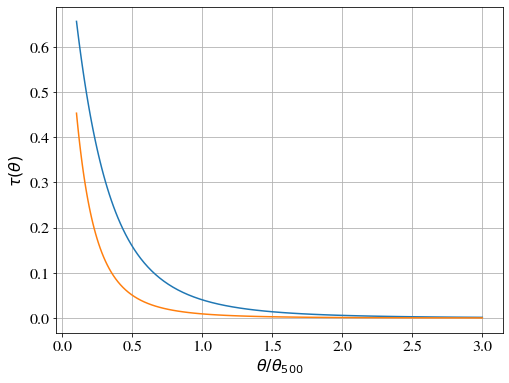

In [73]:
plt.plot(th_array,vec_tau_gnfw(th_array,z),label='gnfw')
plt.plot(th_array,vec_tau_battaglia(th_array,z),label='battaglia')
plt.xlabel(r'$\theta/\theta_{500}$')
plt.ylabel(r'$\tau(\theta)$')
plt.grid(which='both')
plt.legend(loc=1)

In [74]:
xd, yd = np.log(m_array), np.log(1.+th_array)
X, Y = np.meshgrid(xd, yd)
Z_gnfw = np.zeros(X.shape)
Z_battaglia = np.zeros(X.shape)
for ith in range(n_th):
    for im in range(n_m):
        mm = m_array[im]
        thth = th_array[ith]
        Z_gnfw[ith][im] = np.log(y_over_Ez2_over_mfid_gnfw_at_m_and_z_theta(mm,thth,z))
        Z_battaglia[ith][im] = np.log(y_over_Ez2_over_mfid_battaglia_at_m_and_z_theta(mm,thth,z))


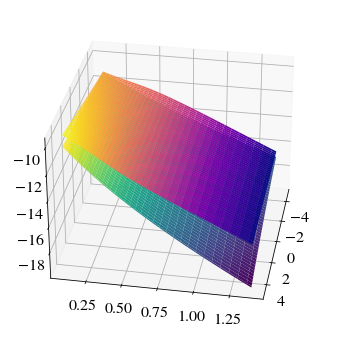

In [81]:
# Plot the 3D figure of the fitted function and the residuals.
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_surface(X, Y, Z_gnfw, cmap='plasma')
ax.plot_surface(X, Y, Z_battaglia, cmap='viridis')
#ax.set_zlim(np.min(Z),np.max(Z))

ax.view_init(30, 10)
plt.show()

In [84]:
from scipy.optimize import curve_fit

ln_tentoA0_gnfw = np.log(vec_y_gnfw(1.,0.,z))
def ym_rel_gnfw(vars_, a, b):
    xv,yv = vars_
    return a*xv + ln_tentoA0_gnfw + np.log(vec_tau_gnfw(np.exp(b*xv)*(np.exp(yv)-1.),z))

ln_tentoA0_battaglia = np.log(vec_y_battaglia(1.,0.,z))
def ym_rel_battaglia(vars_, a, b):
    xv,yv = vars_
    return a*xv + ln_tentoA0_battaglia + np.log(vec_tau_battaglia(np.exp(b*xv)*(np.exp(yv)-1.),z))





xdata = np.vstack((X.ravel(), Y.ravel()))
popt_gnfw, pcov_gnfw = curve_fit(ym_rel_gnfw, xdata, Z_gnfw.ravel(),p0 = [0.08,-0.025])
popt_battaglia, pcov_battaglia = curve_fit(ym_rel_battaglia, xdata, Z_battaglia.ravel(),p0 = [0.08,-0.025])

In [85]:
print(r'gnfw: 10^A_{0} = %.4e B=%.4e C=%.4e'%(np.exp(ln_tentoA0_gnfw),popt_gnfw[0],popt_gnfw[1]))
print(r'battaglia: 10^A_{0} = %.4e B=%.4e C=%.4e'%(np.exp(ln_tentoA0_battaglia),popt_battaglia[0],popt_battaglia[1]))


gnfw: 10^A_{0} = 4.9502e-05 B=1.9431e-01 C=6.4731e-02
battaglia: 10^A_{0} = 4.9028e-05 B=2.1964e-01 C=1.3577e-01


In [89]:
B_gnfw_bf = 1.9431e-01
C_gnfw_bf = 6.4731e-02

B_battaglia_bf = 2.1964e-01
C_battaglia_bf = 1.3577e-01

B_act = 0.08
C_act = -0.025

In [90]:
Z_fit_gnfw = np.zeros(X.shape)
Z_fit_battaglia = np.zeros(X.shape)
Z_fit_act = np.zeros(X.shape)
for ith in range(n_th):
    for im in range(n_m):
        mm = m_array[im]
        lnm = np.log(mm)
        thth = th_array[ith]
        ln_1pthth = np.log(1.+thth)
        Z_fit_gnfw[ith][im] = ym_rel_gnfw((lnm,ln_1pthth),B_gnfw_bf,C_gnfw_bf)
        Z_fit_battaglia[ith][im] = ym_rel_battaglia((lnm,ln_1pthth),B_battaglia_bf,C_battaglia_bf)
        Z_fit_act[ith][im] = ym_rel_gnfw((lnm,ln_1pthth),B_act,C_act)



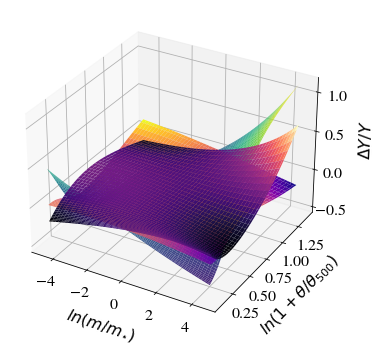

In [93]:
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, (np.exp(Z_fit_gnfw)-np.exp(Z_gnfw))/np.exp(Z_gnfw), cmap='plasma')
ax.plot_surface(X, Y, (np.exp(Z_fit_battaglia)-np.exp(Z_battaglia))/np.exp(Z_battaglia), cmap='magma')
ax.plot_surface(X, Y, (np.exp(Z_fit_act)-np.exp(Z_gnfw))/np.exp(Z_gnfw), cmap='viridis')
plt.xlabel(r'$ln(m/m_{\star})$',labelpad=10)
plt.ylabel(r'$ln(1+\theta/\theta_{500})$',labelpad=10)
ax.set_zlabel(r'$\Delta Y/Y$',labelpad=10)
#ax.set_zlim(np.min(np.log(Z)),np.max(np.log(Z)))
plt.show()
#ax.legend()

Text(0.5, 1.0, 'class_sz gnfw')

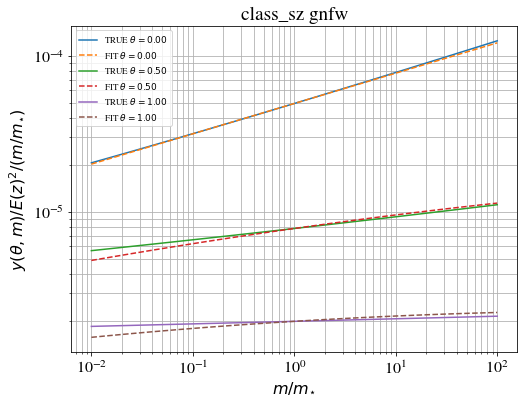

In [97]:
theta_test = 0.
plt.plot(m_array,vec_y_gnfw(m_array,theta_test,z),label=r'TRUE $\theta=%.2f$'%(theta_test),ls='-')
plt.plot(m_array,np.exp(ym_rel_gnfw((np.log(m_array),np.log(1.+theta_test)), B_gnfw_bf, C_gnfw_bf)),label=r'FIT $\theta=%.2f$'%(theta_test),ls='--')

theta_test = 0.5
plt.plot(m_array,vec_y_gnfw(m_array,theta_test,z),label=r'TRUE $\theta=%.2f$'%(theta_test),ls='-')
plt.plot(m_array,np.exp(ym_rel_gnfw((np.log(m_array),np.log(1.+theta_test)), B_gnfw_bf, C_gnfw_bf)),label=r'FIT $\theta=%.2f$'%(theta_test),ls='--')


theta_test = 1.
plt.plot(m_array,vec_y_gnfw(m_array,theta_test,z),label=r'TRUE $\theta=%.2f$'%(theta_test),ls='-')
plt.plot(m_array,np.exp(ym_rel_gnfw((np.log(m_array),np.log(1.+theta_test)), B_gnfw_bf, C_gnfw_bf)),label=r'FIT $\theta=%.2f$'%(theta_test),ls='--')




plt.loglog()
plt.grid(which='both')
plt.xlabel(r'$m/m_{\star}$')
plt.ylabel(r'$y(\theta,m)/E(z)^2/(m/m_{\star})$')
plt.legend(fontsize = 9.)
plt.title('class_sz gnfw')

Text(0.5, 1.0, 'class_sz battaglia')

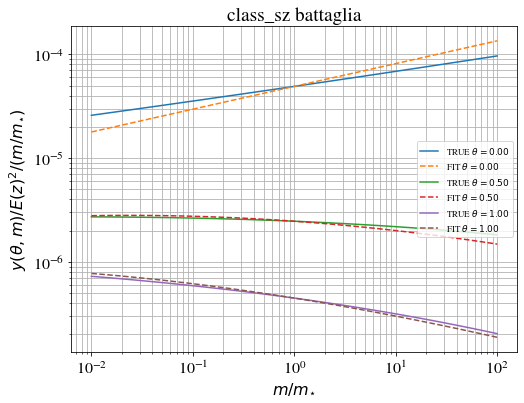

In [98]:
theta_test = 0.
plt.plot(m_array,vec_y_battaglia(m_array,theta_test,z),label=r'TRUE $\theta=%.2f$'%(theta_test),ls='-')
plt.plot(m_array,np.exp(ym_rel_battaglia((np.log(m_array),np.log(1.+theta_test)), B_battaglia_bf, C_battaglia_bf)),label=r'FIT $\theta=%.2f$'%(theta_test),ls='--')

theta_test = 0.5
plt.plot(m_array,vec_y_battaglia(m_array,theta_test,z),label=r'TRUE $\theta=%.2f$'%(theta_test),ls='-')
plt.plot(m_array,np.exp(ym_rel_battaglia((np.log(m_array),np.log(1.+theta_test)), B_battaglia_bf, C_battaglia_bf)),label=r'FIT $\theta=%.2f$'%(theta_test),ls='--')


theta_test = 1.
plt.plot(m_array,vec_y_battaglia(m_array,theta_test,z),label=r'TRUE $\theta=%.2f$'%(theta_test),ls='-')
plt.plot(m_array,np.exp(ym_rel_battaglia((np.log(m_array),np.log(1.+theta_test)), B_battaglia_bf, C_battaglia_bf)),label=r'FIT $\theta=%.2f$'%(theta_test),ls='--')




plt.loglog()
plt.grid(which='both')
plt.xlabel(r'$m/m_{\star}$')
plt.ylabel(r'$y(\theta,m)/E(z)^2/(m/m_{\star})$')
plt.legend(fontsize = 9.)
plt.title('class_sz battaglia')

Text(0.5, 1.0, 'act gnfw')

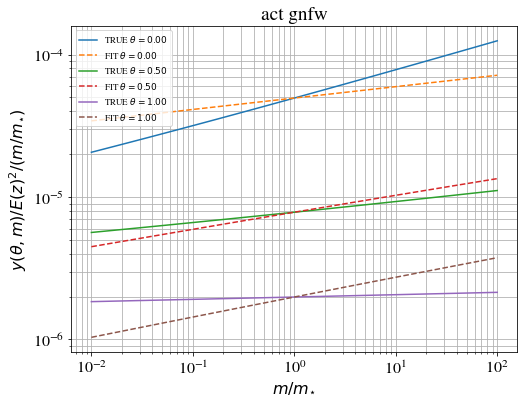

In [99]:
theta_test = 0.
plt.plot(m_array,vec_y_gnfw(m_array,theta_test,z),label=r'TRUE $\theta=%.2f$'%(theta_test),ls='-')
plt.plot(m_array,np.exp(ym_rel_gnfw((np.log(m_array),np.log(1.+theta_test)), B_act, C_act)),label=r'FIT $\theta=%.2f$'%(theta_test),ls='--')

theta_test = 0.5
plt.plot(m_array,vec_y_gnfw(m_array,theta_test,z),label=r'TRUE $\theta=%.2f$'%(theta_test),ls='-')
plt.plot(m_array,np.exp(ym_rel_gnfw((np.log(m_array),np.log(1.+theta_test)), B_act, C_act)),label=r'FIT $\theta=%.2f$'%(theta_test),ls='--')


theta_test = 1.
plt.plot(m_array,vec_y_gnfw(m_array,theta_test,z),label=r'TRUE $\theta=%.2f$'%(theta_test),ls='-')
plt.plot(m_array,np.exp(ym_rel_gnfw((np.log(m_array),np.log(1.+theta_test)), B_act, C_act)),label=r'FIT $\theta=%.2f$'%(theta_test),ls='--')




plt.loglog()
plt.grid(which='both')
plt.xlabel(r'$m/m_{\star}$')
plt.ylabel(r'$y(\theta,m)/E(z)^2/(m/m_{\star})$')
plt.legend(fontsize = 9.)
plt.title('act gnfw')

In [17]:
M.struct_cleanup()
M.empty()

# y-m relation

In [10]:
M = Class()
cosmo_settings = {
                  'omega_cdm': 0.125,
                  'omega_b': 0.0224,
                  'A_s': 1.9e-9,
                  'n_s': 0.96,
                  'H0': 69.,
                  'tau_reio': 0.054, # planck 2018 value (in abstract of 1807.06209)
                  'YHe': 'BBN',

                  # 1 massive neutrino (planck 2018 baseline)
                  'N_ur': 2.0328,
                  'N_ncdm': 1,
                  'm_ncdm': 0.06,
                  'T_ncdm': 0.71611,


                  # X ray mass bias (if applicable)
                  'B' : 1.,
    
                  'output' : 'sz_cluster_counts'
}

M.set(cosmo_settings)
M.set({
          'y_m_relation' : 1, # simons observatory/ACT
          # scaling law parameter
          # Hilton et al 2020
          'A_ym' : 4.95e-5,
          'B_ym' : 0.08,
})
M.compute()

z = 1.e0
m = np.geomspace(5e13,5e15,50)
y_hilton = []
for mm in m:
    y_hilton.append(M.get_y_at_m_and_z(mm,z))
    
M.set({
    'y_m_relation' : 0, # planck 
     # scaling law parameter
     # Planck 2015    ?
    'ystar_ym': -0.186,
    'alpha_ym': 1.78,
    'beta_ym': 0.66,
    
})
M.compute()
y_planck = []
for mm in m:
    y_planck.append(M.get_y_at_m_and_z(mm,z))
#y_hilton

[]

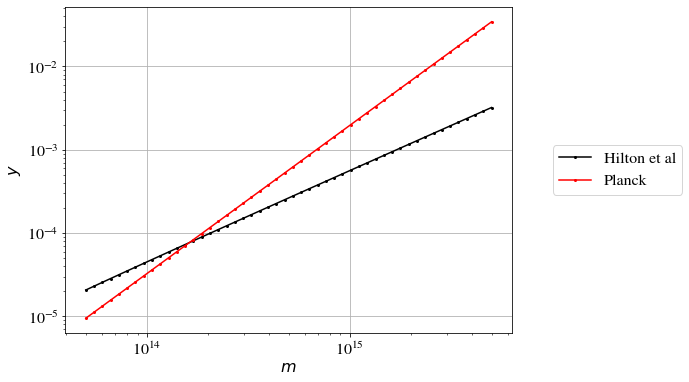

In [11]:
plt.xlabel(r"$m$")
plt.ylabel(r"$y$")
plt.grid()
plt.plot(m,y_hilton,marker  = 'o',markersize = 2.,c='k',label='Hilton et al')
plt.plot(m,y_planck,marker  = 'o',markersize = 2.,c='r',label='Planck')
plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
plt.loglog()

In [12]:
M.struct_cleanup()
M.empty()

# Computing cluster abundance (SO)

In [4]:
M = Class()
cluster_settings = {
                   # LambdaCDM parameters
#                    'h':0.7,
#                    'B': 1.,
#                    'Omega_b':0.04,
#                    'Omega_cdm':0.26,
#                    'A_s':1.75e-9,
#                    'n_s': 0.96
                   'h':0.67556,
                   'omega_b':0.022032,
                   'omega_cdm':0.12038,
                   'A_s':2.215e-9,
                   'tau_reio':0.0925,
                   'n_s': 0.96605
}

best_fit ={
   'H0': 6.7169970E+01,
   'A_s': 1.8160055E-09,
   'omega_cdm': 1.1972036E-01,
   'B_ym': -8.7525562E-02,
   'A_ym': 4.9660989E-05,
   'omega_b': 0.022383,
   'tau_reio': 0.0543,
   'n_s': 0.96605
}

mass_cal ={
#    'H0': 6.7169970E+01,
#    'A_s': 1.8160055E-09,
#    'omega_cdm': 1.1972036E-01,
   'B_ym': 0.1,
   'A_ym': 2.85e-5,
#    'omega_b': 0.022383,
#    'tau_reio': 0.0543,
#    'n_s': 0.96605
#     'B': 1.4
}

M.set(p18_cosmo)
M.set(mass_cal)
# M.set(best_fit)
M.set({
          'non linear': 'halofit',
          'output' : 'sz_cluster_counts',
          'mass function' : 'M500',
          'integrate_wrt_m500c' : 1,
          'has_selection_function' : 1,
          'experiment' : 1, # simons observatory
          'y_m_relation' : 1,
          'signal-to-noise cut-off for survey cluster completeness' : 5.,

          # scaling law parameter
          #'A_ym' : 4.90e-5,
          #'B_ym' : 0.22,
          'C_ym' : 0.,



          'M1SZ' : 5e13,
          'M2SZ' : 5e15,

          # bin_z_min_cluster_counts : 0.
          # bin_z_max_cluster_counts : 2.
          # bin_dz_cluster_counts : 0.1
          #
          #
          #'tau_reio': 0.054, # planck 2018 value (in abstract of 1807.06209)
          'YHe': 'BBN',

          # 1 massive neutrino (planck 2018 baseline)
          'N_ur': 2.0328,
          'N_ncdm': 1,
          'm_ncdm': 0.06,
          'T_ncdm': 0.71611,

          #
          # #3 massive neutrinos
          # N_ur : 0.00641
          # N_ncdm : 1
          # deg_ncdm : 3
          # m_ncdm : 0.02
          # T_ncdm : 0.71611



          #
          # HMF_prescription_NCDM: 'CDM'

          # verbose parameters for debugging
          'input_verbose' : 0,
          'background_verbose': 3,
          'perturbations_verbose': 0,
          'sz_verbose'  : 3,

          # X ray mass bias (if applicable)
          'B' : 1.4,


          'bin_z_min_cluster_counts' : 0.,
          'bin_z_max_cluster_counts' : 2.,
          'bin_dz_cluster_counts' : 0.1,
          'bin_dlog10_snr': 0.1,

          'dlny' : 0.03,
          'lnymin' : -11.,
          'lnymax' : -5.,
          'sigmaM_ym' : 0.2,
          'dlnM_cluster_count_completeness_grid' : 0.02,


          'cluster_count_completeness_grid_z_cutoff_low' : 0.5,
          'cluster_count_completeness_grid_z_cutoff_mid' : 1.5,

          'dz_cluster_count_completeness_grid_low_z' : 5e-3,
          'dz_cluster_count_completeness_grid_mid_z' : 1e-1,
          'dz_cluster_count_completeness_grid_high_z' : 1e-1,

          'mass_epsrel_cluster_counts' : 1e-3,
          'mass_epsabs_cluster_counts' : 1e-30,

          'redshift_epsrel_cluster_counts' : 1e-3,
          'redshift_epsabs_cluster_counts' : 1e-30,
          #
          #
          # # tabulation of mass function:
          'n_z_dndlnM' : 80,
          'n_m_dndlnM' : 80,
          #
          # # computation of mass function
          # # (grid in mass and redshifts for sigma and dsigma)
          'ndim_masses' : 80,
          'ndim_redshifts' : 80,
          #
          # pk setup for computation of sigma and dsigma
          'k_per_decade_class_sz' : 20.,
          'k_min_for_pk_class_sz' : 1e-3,
          'k_max_for_pk_class_sz' : 1e1,

          'P_k_max_h/Mpc' : 1e1
    
})
M.compute()

In [5]:
mm = 5e13
z = 5.5
M.get_y_at_m_and_z(mm,z)


0.0002225145789344047

In [6]:
print('sigma8 : %f'%M.sigma8())
print('Omega_m : %f'%M.Omega_m())

sigma8 : 0.811665
Omega_m : 0.315838


In [35]:
dNdzdy_theoretical = M.dndzdy_theoretical()['dndzdy']
z_center = M.dndzdy_theoretical()['z_center']
z_edges = M.dndzdy_theoretical()['z_edges']
log10y_center = M.dndzdy_theoretical()['log10y_center']
log10y_edges = M.dndzdy_theoretical()['log10y_edges']
# M.struct_cleanup()
# M.empty()

In [36]:
N_z,N_y = np.shape(dNdzdy_theoretical)
N_clusters_z_theory = []
for iz in range(N_z):
    N_clusters_z_theory.append(np.sum(dNdzdy_theoretical[iz]))
N_clusters_y_theory = []
for iy in range(N_y):
    N_clusters_y_theory.append(np.sum(np.asarray(dNdzdy_theoretical)[:,iy]))



In [37]:
# here puth the path to the directory : MFMF_SOSim_3freq_tiles
path_to_catalogue = '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_external_data_and_scripts/MFMF_SOSim_3freq_tiles/'
from astropy.io import fits
#"fits_image_filename = fits.util.get_testdata_filepath(path_to_catalogue+'MFMF_SOSim_3freq_tiles_M500.fits')
tcat = path_to_catalogue+'MFMF_SOSim_3freq_tiles_M500.fits'
list = fits.open(tcat)
data = list[1].data
z = data.field("redshift")
snr = data.field("SNR")
tile = data.field("tileName")
snrcut = 5
z = z[snr > snrcut]
snr = snr[snr > snrcut]
sf = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/so_3freqs_020621_skyfracs.txt')
print('sky fraction:',sf.sum())

sky fraction: 0.43213469173544644


In [38]:
import pandas as pd

# df  = {"M200m"}

In [39]:
df = {"M200m":data.field("M200m").byteswap().newbyteorder(),
     "M500c":data.field("M500").byteswap().newbyteorder(),
     "redshift":data.field("redshift").byteswap().newbyteorder(),
     "y_c": data.field("fixed_y_c").byteswap().newbyteorder()}
df = pd.DataFrame(df)

In [40]:
df["redshift"][30136]

0.6090747062823515

In [41]:
M.Hubble(0.)

0.00022455534888739598

In [42]:
def E(zp):
    return M.Hubble(zp)/M.Hubble(0.)
vec_Ez = np.vectorize(E)
df["y_c_over_Ez2"] = df["y_c"]/vec_Ez(df["redshift"])**2.
df

,M200m,M500c,redshift,y_c,y_c_over_Ez2
0,5.482577,3.174886,1.230438,0.685775,0.163645
1,4.851615,2.652659,0.311749,0.430087,0.307820
2,2.726391,1.612437,0.831074,0.247447,0.094302
3,4.751891,2.781727,0.985001,0.510689,0.161836
4,2.738110,1.545051,1.772472,0.344519,0.046434
...,...,...,...,...,...
30132,4.064517,2.387425,0.971221,0.417228,0.134395
30133,5.845295,3.356987,0.609932,0.578439,0.288854
30134,4.634598,2.464252,0.218872,0.421021,0.335159
30135,6.886024,3.740221,0.318073,0.671116,0.476793


[]

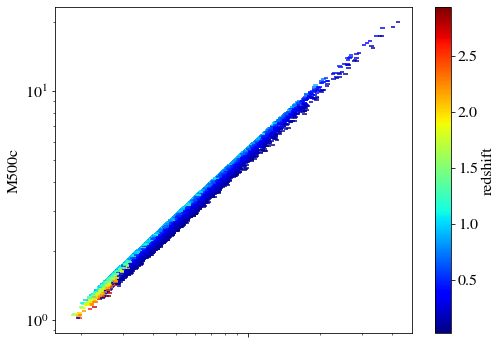

In [43]:

# m500cs = data.field("M500")
# m200ms = data.field("M200m")
# y_c = data.field("y_c")
df.plot.scatter("M200m","M500c",c="redshift", cmap='jet',marker=1)
plt.loglog()
# plt.legend()

<Figure size 576x432 with 0 Axes>

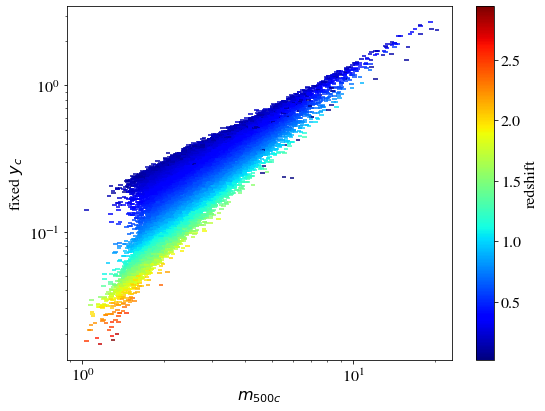

In [44]:
plt.figure()
ax = df.plot(kind="scatter",x="M500c",y="y_c_over_Ez2",c="redshift", cmap='jet',marker=1, sharex=False)
plt.loglog()
ax.set_ylabel(r"fixed $y_c$")
ax.set_xlabel(r"$m_{500c}$")
plt.tight_layout()
# plt.show()
# plt.grid()

In [8]:
from scipy.interpolate import *
import numpy as np

omegab = 0.049
omegac = 0.261
omegam = omegab + omegac
h      = 0.68
ns     = 0.965
sigma8 = 0.81

c = 3e5

H0 = 100*h
nz = 100000
z1 = 0.0
z2 = 6.0
za = np.linspace(z1,z2,nz)
dz = za[1]-za[0]

H      = lambda z: H0*np.sqrt(omegam*(1+z)**3+1-omegam)
dchidz = lambda z: c/H(z)

chia = np.cumsum(dchidz(za))*dz

zofchi = interp1d(chia,za)

In [10]:
f=open(path_to_catalogue_websky+'halos-light.pksc')
N=np.fromfile(f,count=3,dtype=np.int32)[0]
N

862923142

In [46]:
import healpy as hp
# from   cosmology import *

omegam = M.Omega_m()
h = M.h()
rho = 2.775e11*omegam*h**2 # Msun/Mpc^3
path_to_catalogue_websky = '/Users/boris/Work/CLASS-SZ/SO-SZ/so_cluster_counts/'
f=open(path_to_catalogue_websky+'halos.pksc')
N=np.fromfile(f,count=3,dtype=np.int32)[0]

# only take first five entries for testing (there are ~8e8 halos total...)
# comment the following line to read in all halos
N = 8000000
# N = 862923142

catalog=np.fromfile(f,count=N*10,dtype=np.float32)
catalog=np.reshape(catalog,(N,10))

x  = catalog[:,0];  y = catalog[:,1];  z = catalog[:,2] # Mpc (comoving)
vx = catalog[:,3]; vy = catalog[:,4]; vz = catalog[:,5] # km/sec
R  = catalog[:,6] # Mpc

# convert to mass, comoving distance, radial velocity, redshfit, RA and DEc
M200m    = 4*np.pi/3.*rho*R**3*h        # this is M200m (mean density 200 times mean) in Msun/h
chi      = np.sqrt(x**2+y**2+z**2)    # Mpc
vrad     = (x*vx + y*vy + z*vz) / chi # km/sec
redshift = zofchi(chi)      

theta, phi  = hp.vec2ang(np.column_stack((x,y,z))) # in radians

### e.g. project to a map, matching the websky orientations
#nside = 1024
#map   = np.zeros((hp.nside2npix(nside)))

#pix = hp.vec2pix(nside, x, y, z)
#pix = hp.ang2pix(nside, theta, phi) does the same

#weight = 1. #1 for number density, array of size(x) for arbitrary
#np.add.at(map, pix, weight)

In [47]:
# import numpy as np
# import websky_model as wm

# # load model
# #wmodel = wm.WebSky(directory_path='/global/project/projectdirs/sobs/v4_sims/mbs/websky/data/',websky_version = 'v0.1', verbose=True)
# path_to_catalogue_websky = '/Users/boris/Work/CLASS-SZ/SO-SZ/so_cluster_counts/'
# wmodel = wm.WebSky(directory_path=path_to_catalogue_websky,websky_version = '',halo_catalogue = 'halos.pksc', verbose=True)


# # read in halo catalogue
# hcat  = wmodel.load_halo_catalogue(mmin=0, mmax=np.inf, zmin=0, zmax=np.inf, rmin=0., rmax=np.inf, practical=True)



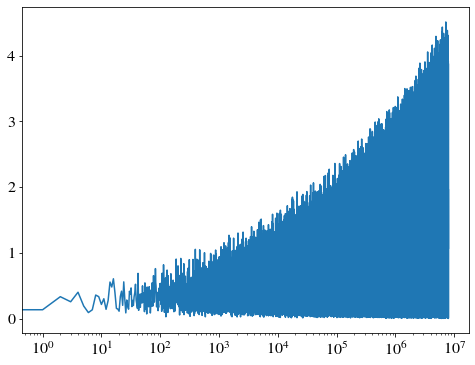

In [48]:
plt.plot(redshift)
plt.xscale('log')

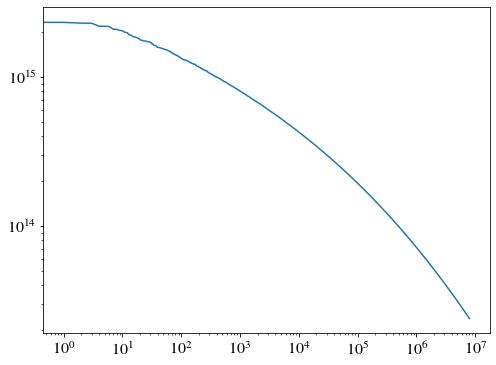

In [49]:
plt.plot(M200m)
plt.yscale('log')
plt.xscale('log')

In [50]:
"%.3e"%M200m.min()

'2.386e+13'

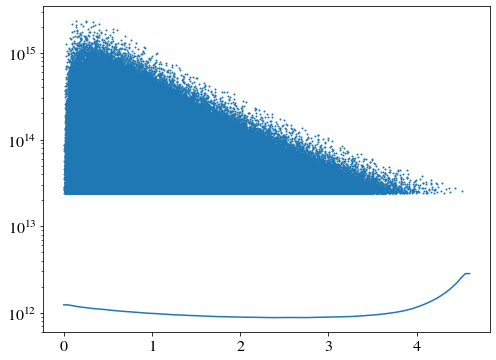

In [51]:
plt.scatter(redshift,M200m,marker='o',s=1.)
L=np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/so_cluster_counts/halos_mass_completion_websky.txt')
plt.plot(L[:,0],L[:,1])
plt.yscale('log')

Text(0.5, 0, 'cl id')

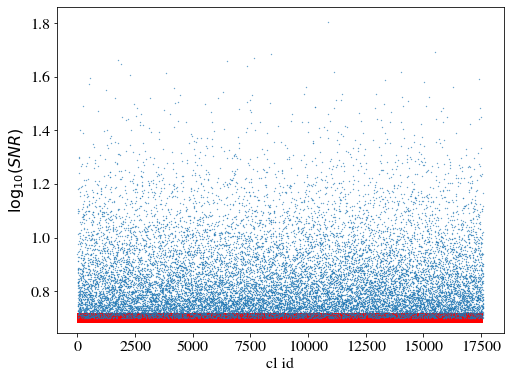

In [61]:
plt.plot(np.log10(snr),marker='o',ls='None',markersize=0.3)
plt.hlines(np.log10(snrcut),xmin=0,xmax=len(snr),color='r',lw=10)
plt.ylabel(r'$\log_{10}(SNR)$')
plt.xlabel('cl id')

Text(0, 0.5, '$z$')

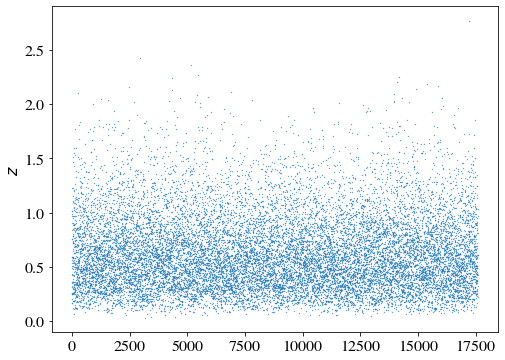

In [62]:
plt.plot(z,marker='o',ls='None',markersize=0.3)
plt.ylabel(r'$z$')
# plt.hlines(np.log10(snrcut),xmin=0,xmax=len(snr),color='r',lw=10)

(1.0, 5000.0)

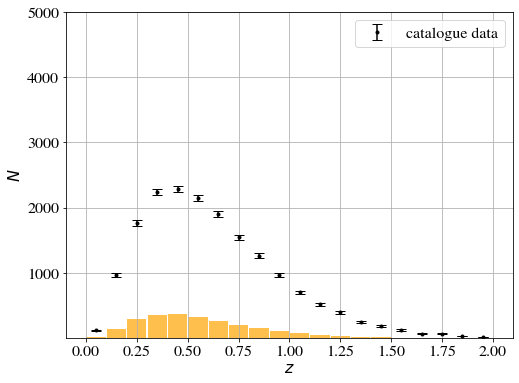

In [63]:
N_clusters_z, xedges = np.histogram(z, bins=z_edges)
plt.errorbar(z_center,N_clusters_z,yerr=np.sqrt(N_clusters_z),marker='o',markersize=3.,ls='none',label='catalogue data',capsize=5,c='k')
#plt.hist(z_center,N_clusters_z_theory,marker='o',markersize=3.,ls=':',label='theory',c='orange')
n, bins, patches = plt.hist(x=np.repeat(z_center,N_clusters_z_theory), bins=z_edges, color='orange',alpha=0.7, rwidth=0.95)
plt.grid()
plt.legend(loc=1)
plt.xlabel(r'$z$')
plt.ylabel(r'$N$')
plt.yscale('linear')
plt.ylim(1e0,5e3)

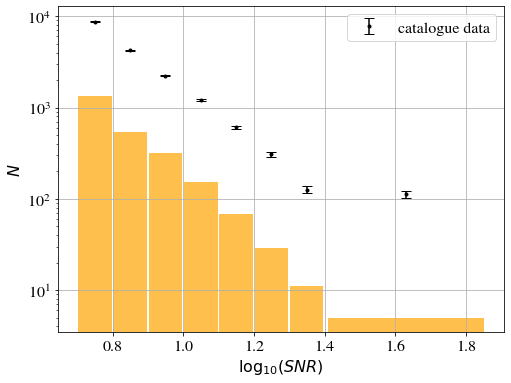

In [64]:
N_clusters_y, xedges = np.histogram(np.log10(snr), bins=log10y_edges)
plt.errorbar(log10y_center,N_clusters_y,yerr=np.sqrt(N_clusters_y),marker='o',markersize=3.,ls='none',label='catalogue data',capsize=5,c='k')
#plt.plot(log10y_center,N_clusters_y_theory,marker='o',markersize=3.,ls=':',label='theory',c='orange')
n, bins, patches = plt.hist(x=np.repeat(log10y_center,N_clusters_y_theory), bins=log10y_edges, color='orange',alpha=0.7, rwidth=0.95)


plt.grid()
plt.legend()
plt.xlabel(r'$\log_{10}(SNR)$')
plt.ylabel(r'$N$')
plt.yscale('log')

In [65]:
dNdzdy_catalog, zedges, yedges = np.histogram2d(z,np.log10(snr), bins=[z_edges,log10y_edges])
SZCC_Cash = 0.
for index_z in range(N_z):
    for index_y in range(N_y):
        if not dNdzdy_theoretical[index_z][index_y] == 0.:
            ln_factorial = 0.
            if not dNdzdy_catalog[index_z,index_y] == 0.:
                if dNdzdy_catalog[index_z,index_y] > 10.:
                    # Stirling approximation only for more than 10 elements
                    ln_factorial = 0.918939 + (dNdzdy_catalog[index_z,index_y] + 0.5) * np.log(dNdzdy_catalog[index_z,index_y]) - dNdzdy_catalog[index_z,index_y]
                else:
                    # Direct computation of factorial
                    ln_factorial = np.log(np.math.factorial(int(dNdzdy_catalog[index_z,index_y])))
            SZCC_Cash += (dNdzdy_catalog[index_z,index_y] * np.log(dNdzdy_theoretical[index_z][index_y]) - dNdzdy_theoretical[index_z][index_y] - ln_factorial)

# return ln(L)
loglkl = SZCC_Cash
print(loglkl)

-20394.11943865362


In [66]:
np.sum(dNdzdy_theoretical)

2451.4569798812954

In [67]:
np.sum(dNdzdy_theoretical)

2451.4569798812954

In [ ]:
    // pcsz->lnM_max = 37.; //cosmomc/szount.f90 range
    // pcsz->lnM_min = 31.54;

In [16]:
np.exp(37.)

1.1719142372802612e+16

# Computing cluster abundance

In [80]:
M = Class()


best_fit_planck_new_sigmaM ={
   'H0': 6.8078121E+01,
   'A_s': 1.6473666E-09,
   'omega_cdm': 1.2547102E-01,
   'omega_b': 2.1865653E-02,
   'tau_reio': 0.0543,
   'n_s': 9.5611087E-01,
    
    'alpha_ym': 1.8674885E+00,
    'ystar_ym': -1.8663318E-01,
    'sigmaM_ym': 1.6903344E-01,
    'B': 1./(7.7068241E-01)
}

best_fit_planck_old_sigmaM ={
   'H0': 6.7318259E+01,
   'A_s': 1.8548184E-09,
   'omega_cdm': 1.1707694E-01,
   'omega_b': 2.1572441E-02,
   'tau_reio': 0.0543,
   'n_s': 9.6892923E-01,
    
    'alpha_ym': 1.8226235E+00,
    'ystar_ym': -1.9139607E-01,
    'sigmaM_ym': 7.0815376E-02,
    'B': 1./(7.6169989E-01)
}

M.set(best_fit_planck_old_sigmaM)

M.set({
          'M2SZ':np.exp(37.),
          'M1SZ':np.exp(31.54),
          'non linear': 'halofit',
          'output' : 'sz_cluster_counts',
          'mass function' : 'M500',
          'integrate_wrt_m500c' : 1,
          'has_selection_function' : 1,
          'experiment' : 0,
          'y_m_relation' : 0,
          'signal-to-noise cut-off for survey cluster completeness' : 5.,

          #'tau_reio': 0.054, # planck 2018 value (in abstract of 1807.06209)
          'YHe': 'BBN',

          # 1 massive neutrino (planck 2018 baseline)
          'N_ur': 2.0328,
          'N_ncdm': 1,
          'm_ncdm': 0.06,
          'T_ncdm': 0.71611,



          # verbose parameters for debugging
          'input_verbose' : 0,
          'background_verbose': 3,
          'perturbations_verbose': 0,
          'sz_verbose'  : 3,



          'bin_z_min_cluster_counts' : 0.,
          'bin_z_max_cluster_counts' : 1.,
          'bin_dz_cluster_counts' : 0.1,
          'bin_dlog10_snr': 0.25,

          'dlny' : 0.05,
          'lnymin' : -11.5,
          'lnymax' : 10.,
          #'sigmaM_ym' : 0.2,
          'dlnM_cluster_count_completeness_grid' : 0.05,


          'cluster_count_completeness_grid_z_cutoff_low' : 0.2,
          'cluster_count_completeness_grid_z_cutoff_mid' : 1.,

          'dz_cluster_count_completeness_grid_low_z' : 1e-3,
          'dz_cluster_count_completeness_grid_mid_z' : 1e-2,
          'dz_cluster_count_completeness_grid_high_z' : 1e-1,

          'mass_epsrel_cluster_counts' : 1e-5,
          'mass_epsabs_cluster_counts' : 1e-30,

          'redshift_epsrel_cluster_counts' : 1e-5,
          'redshift_epsabs_cluster_counts' : 1e-30,

          # # tabulation of mass function:
          'n_z_dndlnM' : 100,
          'n_m_dndlnM' : 100,
          #
          # # computation of mass function
          # # (grid in mass and redshifts for sigma and dsigma)
          'ndim_masses' : 100,
          'ndim_redshifts' : 100,
          #
          # pk setup for computation of sigma and dsigma
          'k_per_decade_class_sz' : 20.,
          'k_min_for_pk_class_sz' : 1e-3,
          'k_max_for_pk_class_sz' : 5e1,

          'P_k_max_h/Mpc' : 7e1
    
})
M.compute()

In [81]:
dNdzdy_theoretical = M.dndzdy_theoretical()['dndzdy']
z_center = M.dndzdy_theoretical()['z_center']
z_edges = M.dndzdy_theoretical()['z_edges']
log10y_center = M.dndzdy_theoretical()['log10y_center']
log10y_edges = M.dndzdy_theoretical()['log10y_edges']
M.struct_cleanup()
M.empty()



In [82]:
np.sum(dNdzdy_theoretical)

570.1973405126556

In [87]:
N_clusters_z_theory_planck = N_clusters_z_theory.copy()
z_center_planck = z_center.copy()
z_edges_planck = z_edges.copy()

In [83]:
N_z,N_y = np.shape(dNdzdy_theoretical)
N_clusters_z_theory = []
for iz in range(N_z):
    N_clusters_z_theory.append(np.sum(dNdzdy_theoretical[iz]))
N_clusters_y_theory = []
for iy in range(N_y):
    N_clusters_y_theory.append(np.sum(np.asarray(dNdzdy_theoretical)[:,iy]))




No handles with labels found to put in legend.


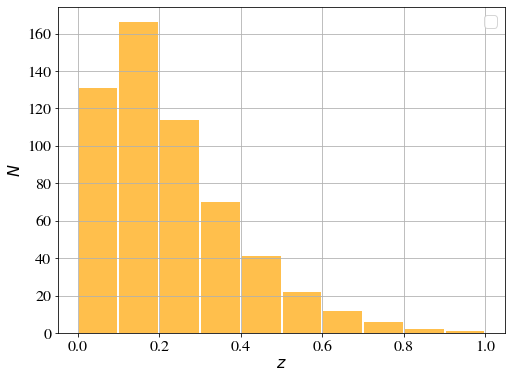

In [84]:
#N_clusters_z, xedges = np.histogram(z, bins=z_edges)
# plt.errorbar(z_center,N_clusters_z,yerr=np.sqrt(N_clusters_z),marker='o',markersize=3.,ls='none',label='catalogue data',capsize=5,c='k')
#plt.hist(z_center,N_clusters_z_theory,marker='o',markersize=3.,ls=':',label='theory',c='orange')
n, bins, patches = plt.hist(x=np.repeat(z_center,N_clusters_z_theory), bins=z_edges, color='orange',alpha=0.7, rwidth=0.95)
plt.grid()
plt.legend(loc=1)
plt.xlabel(r'$z$')
plt.ylabel(r'$N$')
plt.yscale('linear')
# plt.ylim(1e0,5e3)

No handles with labels found to put in legend.


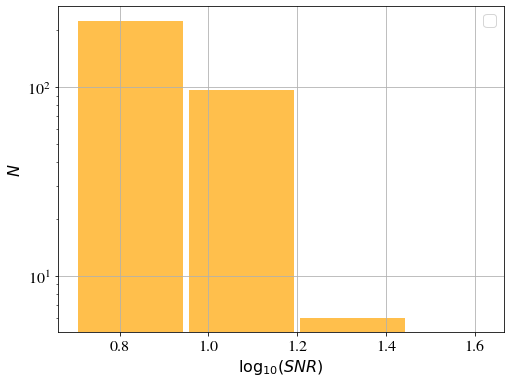

In [10]:
#N_clusters_y, xedges = np.histogram(np.log10(snr), bins=log10y_edges)
# plt.errorbar(log10y_center,N_clusters_y,yerr=np.sqrt(N_clusters_y),marker='o',markersize=3.,ls='none',label='catalogue data',capsize=5,c='k')
#plt.plot(log10y_center,N_clusters_y_theory,marker='o',markersize=3.,ls=':',label='theory',c='orange')
n, bins, patches = plt.hist(x=np.repeat(log10y_center,N_clusters_y_theory), bins=log10y_edges, color='orange',alpha=0.7, rwidth=0.95)


plt.grid()
plt.legend()
plt.xlabel(r'$\log_{10}(SNR)$')
plt.ylabel(r'$N$')
plt.yscale('log')

# Mock catalogues

In [111]:
path_to_catalogue = '/Users/boris/Work/CLASS-SZ/SO-SZ/so_cluster_counts/MFMF_WebSkyHalos_A10tSZ_3freq_tiles_pass2/MFMF_WebSkyHalos_A10tSZ_3freq_tiles/'


#"fits_image_filename = fits.util.get_testdata_filepath(path_to_catalogue+'MFMF_SOSim_3freq_tiles_M500.fits')
tcat = path_to_catalogue+'MFMF_WebSkyHalos_A10tSZ_3freq_tiles_mass.fits'
# tcat = path_to_catalogue+'MFMF_WebSkyHalos_A10tSZ_3freq_tiles_optimalCatalog.fits'
list = fits.open(tcat)
data = list[1].data
z = data.field("redshift")
snr = data.field("fixed_SNR")
# snr = np.sqrt(snr**2-3.)
tile = data.field("tileName")

In [112]:
print(data.columns)
df_nemo = {
     "y_c": data.field("y_c").byteswap().newbyteorder(),
    "redshift": data.field("redshift").byteswap().newbyteorder(),
      "err_y_c": data.field("err_y_c").byteswap().newbyteorder(),
    "M500c": data.field("M500c").byteswap().newbyteorder(),
    "M200m": data.field("M200m").byteswap().newbyteorder(),
     "SNR": data.field("SNR").byteswap().newbyteorder(),
      "name":data.field("name").byteswap().newbyteorder(),
     "fixed_y_c": data.field("fixed_y_c").byteswap().newbyteorder(),
      "fixed_err_y_c": data.field("fixed_err_y_c").byteswap().newbyteorder(),
     "fixed_SNR": data.field("fixed_SNR").byteswap().newbyteorder(),
     "decDeg":data.field("decDeg").byteswap().newbyteorder()}
df_nemo = pd.DataFrame(df_nemo)
df_nemo

ColDefs(
    name = 'name'; format = '18A'
    name = 'RADeg'; format = 'D'
    name = 'decDeg'; format = 'D'
    name = 'SNR'; format = 'D'
    name = 'numSigPix'; format = 'D'
    name = 'template'; format = '17A'
    name = 'tileName'; format = '7A'
    name = 'galacticLatDeg'; format = 'D'
    name = 'fixed_SNR'; format = 'D'
    name = 'deltaT_c'; format = 'D'
    name = 'err_deltaT_c'; format = 'D'
    name = 'y_c'; format = 'D'
    name = 'err_y_c'; format = 'D'
    name = 'fixed_deltaT_c'; format = 'D'
    name = 'fixed_err_deltaT_c'; format = 'D'
    name = 'fixed_y_c'; format = 'D'
    name = 'fixed_err_y_c'; format = 'D'
    name = 'tileBoundarySplit'; format = 'L'
    name = 'redshift'; format = 'D'
    name = 'redshiftErr'; format = 'K'
    name = 'M500c'; format = 'D'
    name = 'M500c_errPlus'; format = 'D'
    name = 'M500c_errMinus'; format = 'D'
    name = 'M500cUncorr'; format = 'D'
    name = 'M500cUncorr_errPlus'; format = 'D'
    name = 'M500cUncorr_errMinus'; for

,y_c,redshift,err_y_c,M500c,M200m,SNR,name,fixed_y_c,fixed_err_y_c,fixed_SNR,decDeg
0,0.758948,1.230438,0.062122,2.955487,5.095571,12.217131,SO-CL J0000.0-0207,0.919446,0.075988,12.099889,-2.124506
1,0.639414,1.025901,0.104136,1.765854,2.989484,6.140166,SO-CL J0000.0-5006,0.411763,0.068363,6.023197,-50.104487
2,0.451077,0.552456,0.097108,1.414709,2.434125,4.645110,SO-CL J0000.0-5910,0.281209,0.062391,4.507243,-59.169303
3,0.507924,0.311749,0.043713,2.741794,5.018612,11.619512,SO-CL J0000.0-6015,0.664135,0.059461,11.169200,-60.261835
4,0.584283,0.918096,0.136817,1.485587,2.504392,4.270554,SO-CL J0000.1-0433,0.310615,0.075102,4.135903,-4.562470
...,...,...,...,...,...,...,...,...,...,...,...
62470,0.500363,0.218872,0.051645,2.721106,5.130395,9.688464,SO-CL J2359.9-1352,0.676967,0.078640,8.608426,-13.878277
62471,0.352899,0.367818,0.072910,1.623578,2.894354,4.840210,SO-CL J2359.9-1730,0.352899,0.072910,4.840210,-17.512378
62472,0.462289,0.366927,0.077227,1.985134,3.555533,5.986131,SO-CL J2359.9-1923,0.452226,0.075556,5.985300,-19.395694
62473,0.985086,0.609075,0.068779,4.257110,7.453453,14.322539,SO-CL J2359.9-3559,1.205494,0.085183,14.151849,-35.992754


# Websky

In [113]:
import healpy as hp
# from   cosmology import *
def makeACTName(RADeg, decDeg, prefix = 'ACT-CL'):
    """Makes ACT cluster name from RADeg, decDeg
    
    """
    
    actName=prefix+" J"+makeRA(RADeg)+makeDec(decDeg)
    
    return actName

def makeRA(myRADeg):
    """Makes RA part of ACT names.
    
    """
    hours=(myRADeg/360)*24
    if hours<10:
        sHours="0"+str(hours)[0]
    else:
        sHours=str(hours)[:2]
    
    mins=float(str(hours)[str(hours).index("."):])*60
    if mins<10:
        sMins="0"+str(mins)[:3]
    else:
        sMins=str(mins)[:4]
        
    return (sHours+sMins)#[:-2] # Trims off .x as not used in ACT names
        
#------------------------------------------------------------------------------------------------------------
def makeDec(myDecDeg):
    """Makes dec part of ACT names
    
    """
    
    # Positive
    if myDecDeg>0:
        if myDecDeg<10:
            sDeg="0"+str(myDecDeg)[0]
        else:
            sDeg=str(myDecDeg)[:2]
    
        mins=float(str(myDecDeg)[str(myDecDeg).index("."):])*60
        if mins<10:
            sMins="0"+str(mins)[:1]
        else:
            sMins=str(mins)[:2]
        
        return "+"+sDeg+sMins
    else:
        if myDecDeg>-10:
            sDeg="-0"+str(myDecDeg)[1]
        else:
            sDeg=str(myDecDeg)[:3]
    
        mins=float(str(myDecDeg)[str(myDecDeg).index("."):])*60
        if mins<10:
            sMins="0"+str(mins)[:1]
        else:
            sMins=str(mins)[:2]
        
        return str(sDeg+sMins)

omegam = M.Omega_m()
h = M.h()
rho = 2.775e11*omegam*h**2 # Msun/Mpc^3
path_to_catalogue_websky = '/Users/boris/Work/CLASS-SZ/SO-SZ/so_cluster_counts/'
f=open(path_to_catalogue_websky+'halos.pksc')
N=np.fromfile(f,count=3,dtype=np.int32)[0]

# only take first five entries for testing (there are ~8e8 halos total...)
# comment the following line to read in all halos
# ordered by decreasing mass
N = 800000
# N = 862923142

catalog=np.fromfile(f,count=N*10,dtype=np.float32)
catalog=np.reshape(catalog,(N,10))

x  = catalog[:,0];  y = catalog[:,1];  z = catalog[:,2] # Mpc (comoving)
vx = catalog[:,3]; vy = catalog[:,4]; vz = catalog[:,5] # km/sec
R  = catalog[:,6] # Mpc

# convert to mass, comoving distance, radial velocity, redshfit, RA and DEc
M200m    = 4*np.pi/3.*rho*R**3        # this is M200m (mean density 200 times mean) in Msun
chi      = np.sqrt(x**2+y**2+z**2)    # Mpc
vrad     = (x*vx + y*vy + z*vz) / chi # km/sec
redshift = zofchi(chi)      

theta, phi  = hp.vec2ang(np.column_stack((x,y,z))) # in radians

decDeg=-1*(np.degrees(theta)-90) # Because HEALPix
RADeg=np.degrees(phi)


### e.g. project to a map, matching the websky orientations
#nside = 1024
#map   = np.zeros((hp.nside2npix(nside)))

#pix = hp.vec2pix(nside, x, y, z)
#pix = hp.ang2pix(nside, theta, phi) does the same

#weight = 1. #1 for number density, array of size(x) for arbitrary
#np.add.at(map, pix, weight)

In [ ]:
names = []
for ra, dec in zip(RADeg, decDeg):
    names.append(makeACTName(ra, dec, prefix= 'SO-CL'))

M500c = []
for zz,mm in zip(redshift,M200m):
    mm500c = M.get_m200m_to_m500c_at_z_and_M(zz,mm*h)
    M500c.append(mm500c/h)

df_websky = {"M200m_websky":M200m, #in m_sun
             "M500c_websky":M500c, #in m_sun
             "redshift":redshift,
             "name": names,
             "decDeg":decDeg}
df_websky = pd.DataFrame(df_websky)

In [14]:
df_websky 


,M200m_websky,M500c_websky,redshift,name,decDeg
0,3.464257e+15,1.796293e+15,0.256726,SO-CL J1751.3-1129,-11.485306
1,3.442972e+15,1.721570e+15,0.136831,SO-CL J0212.9-4204,-42.077911
2,3.403789e+15,1.799262e+15,0.335245,SO-CL J0925.4+7427,74.461525
3,3.396257e+15,1.762844e+15,0.258311,SO-CL J1847.2-1345,-13.755684
4,3.246793e+15,1.741653e+15,0.403070,SO-CL J1350.1+1422,14.376556
...,...,...,...,...,...
799995,1.185614e+14,7.122814e+13,1.068359,SO-CL J1733.0-6043,-60.722733
799996,1.185614e+14,7.112939e+13,1.128705,SO-CL J1659.4+7329,73.493454
799997,1.185613e+14,6.805782e+13,0.346979,SO-CL J1713.0-3858,-38.981491
799998,1.185613e+14,7.128651e+13,0.883106,SO-CL J1956.1-4246,-42.780167


In [15]:
int_df_full = pd.merge(df_websky, df_nemo, how ='inner', on =['redshift','name'])

In [16]:
int_df_full

,M200m_websky,M500c_websky,redshift,name,decDeg_x,y_c,err_y_c,M500c,M200m,SNR,fixed_y_c,fixed_err_y_c,fixed_SNR,decDeg_y
0,3.442972e+15,1.721570e+15,0.136831,SO-CL J0212.9-4204,-42.077911,2.791923,0.047101,15.555687,31.917560,59.275526,3.337292,0.067836,49.196790,-42.076916
1,3.246793e+15,1.741653e+15,0.403070,SO-CL J1350.1+1422,14.376556,4.302460,0.046035,16.234131,30.403539,93.459651,5.640186,0.066505,84.808660,14.375924
2,3.240287e+15,1.653650e+15,0.193444,SO-CL J1730.0+1647,16.787682,3.163145,0.056765,14.520655,28.972992,55.723219,4.193346,0.082546,50.800263,16.787668
3,3.097614e+15,1.553693e+15,0.136054,SO-CL J0742.3-0732,-7.542931,2.508929,0.064466,13.554491,27.700262,38.918593,3.112952,0.098338,31.655627,-7.543371
4,3.088679e+15,1.645903e+15,0.360132,SO-CL J0927.0+0325,3.429047,3.909122,0.052052,15.534280,29.365162,75.100310,5.239461,0.075564,69.338177,3.429603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44102,1.665894e+14,9.940387e+13,1.092927,SO-CL J0532.1-5209,-52.163010,0.615127,0.115521,1.405969,2.372981,5.324782,0.307298,0.060151,5.108779,-52.164760
44103,1.665457e+14,9.943397e+13,1.066222,SO-CL J1939.5-6147,-61.796539,0.250628,0.055068,1.214178,2.041841,4.551214,0.250628,0.055068,4.551214,-61.800000
44104,1.661042e+14,9.928998e+13,0.962609,SO-CL J1721.2+1451,14.852928,0.466420,0.080191,1.744103,2.949769,5.816340,0.387990,0.066964,5.794030,14.852797
44105,1.659952e+14,9.922255e+13,0.917055,SO-CL J0023.3-2739,-27.663811,0.808093,0.165256,1.759785,2.976833,4.889954,0.406498,0.090312,4.501045,-27.666667


In [17]:
from scipy import interpolate
import scipy
def E2(z):
    return (M.Hubble(z)/M.Hubble(0.))**2.



int_df = int_df_full[int_df_full['fixed_SNR'] >= 5.]
z = int_df["redshift"]
m = int_df["M500c_websky"]*M.h()
int_df["M500c_nemo"] = int_df["M500c"]*1e14
f_rel = np.vectorize(M.calcFRel)(z, m)
print(f_rel)
vec_theta = np.vectorize(M.get_theta_at_m_and_z)
thetas = vec_theta(m,z)
QF = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/so_3freqs_120921_pass2_theta500arcmin_Q.txt')
get_Q_of_theta500 = interpolate.interp1d(QF[:,0],QF[:,1],fill_value='extrapolate')
Qs = get_Q_of_theta500(thetas)
print(Qs)
E2zarr = np.vectorize(E2)(int_df["redshift"])



int_df["fixed_y_c_over_e2z"] =int_df["fixed_y_c"]/E2zarr/f_rel/Qs
int_df["fixed_err_y_c_over_e2z"] =int_df["fixed_err_y_c"]/E2zarr/f_rel/Qs



/var/folders/_q/j04c9lw93j75_c_z2jdfbtwm0000gn/T/ipykernel_37371/1557687452.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  int_df["M500c_nemo"] = int_df["M500c"]*1e14


[0.91269611 0.90472484 0.91316674 ... 0.97791476 0.97572649 0.97677545]
[1.18162699 1.40725498 1.34969424 ... 0.44559577 0.34247544 0.38328322]


/var/folders/_q/j04c9lw93j75_c_z2jdfbtwm0000gn/T/ipykernel_37371/1557687452.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  int_df["fixed_y_c_over_e2z"] =int_df["fixed_y_c"]/E2zarr/f_rel/Qs
/var/folders/_q/j04c9lw93j75_c_z2jdfbtwm0000gn/T/ipykernel_37371/1557687452.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  int_df["fixed_err_y_c_over_e2z"] =int_df["fixed_err_y_c"]/E2zarr/f_rel/Qs


In [47]:





def reduced_ym_relation(M200m_ws,a,b,c,d,e):
    return np.exp(a*np.exp(-(np.log(M200m_ws/3e14/e))**2.)+(b*(np.log(M200m_ws))+c)*(1.-np.exp(-(np.log(M200m_ws/3e14/d))**2.)))
#     return np.exp(a*(np.log(M200m_ws/3e14))**3.+b*(np.log(M200m_ws/3e14))**2.+c*(np.log(M200m_ws/3e14))+d)
xdata = int_df["M500c_websky"]
ydata = int_df["fixed_y_c_over_e2z"]
popt, pcov = scipy.optimize.curve_fit(reduced_ym_relation, xdata, ydata,p0 = [1,1.,1.,1.,1.])
print("a=%.5e b=%5e c=%5e d=%5e e=%5e"%(popt[0],popt[1],popt[2],popt[3],popt[4]))
A_ym_websky = popt[0]
B_ym_websky = popt[1]
C_ym_websky = popt[2]
D_ym_websky = popt[3]
E_ym_websky = popt[4]

a=-1.29389e-01 b=9.991387e-01 c=-3.403211e+01 d=1.279992e-01 e=8.441768e-01


In [26]:
def reduced_ym_relation(M500,a,b):
    return a*(M500/3e14)**(1.+b)
xdata = int_df["M500c_websky"]
ydata = int_df["fixed_y_c_over_e2z"]
popt, pcov = scipy.optimize.curve_fit(reduced_ym_relation, xdata, ydata,p0 = [0.08,0.025])
print("a=%.5e b=%5e"%(popt[0],popt[1]))
A_ym_websky = popt[0]
B_ym_websky = popt[1]

a=4.56036e-01 b=-3.869082e-02


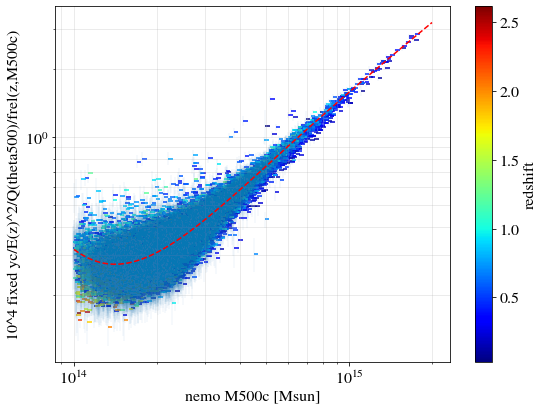

In [48]:
ax = int_df.plot(kind="scatter",x="M500c_websky",y="fixed_y_c_over_e2z",c="redshift", cmap='jet',marker=1, sharex=False)

markers, caps, bars = plt.errorbar(int_df["M500c_websky"], 
             int_df["fixed_y_c_over_e2z"], 
             yerr=int_df["fixed_err_y_c_over_e2z"],
             ls='None',
             marker='None',markersize=3.)

[bar.set_alpha(0.05) for bar in bars]
[cap.set_alpha(0.05) for cap in caps]


masses = np.geomspace(1e14,2e15,100)

plt.plot(masses,reduced_ym_relation(masses,popt[0],popt[1],popt[2],popt[3],popt[4]),ls='--',c='r')

# plt.plot(masses,reduced_ym_relation(masses,popt[0],popt[1]),ls='--',c='r')
# plt.plot(masses,reduced_ym_relation(masses,4.35e-01,0.08),ls='--',c='r')


# y in 1e-4 : see https://arxiv.org/pdf/2009.11043.pdf
ax.set_ylabel(r"10^4 fixed yc/E(z)^2/Q(theta500)/frel(z,M500c)")
ax.set_xlabel(r"nemo M500c [Msun]")
ax.grid(which='both',alpha=0.3)
ax.loglog()
plt.tight_layout()

# plt.savefig('fixed_yc_over_ez2_Q_frel_vs_m500c.pdf')

In [21]:
df_nemo = df_nemo[df_nemo['fixed_SNR'] >= 5.]
z = df_nemo["redshift"]
m = df_nemo["M500c"]*M.h()*1e14
df_nemo["M500c_nemo"] = df_nemo["M500c"]*1e14
f_rel = np.vectorize(M.calcFRel)(z, m)
print(f_rel)
vec_theta = np.vectorize(M.get_theta_at_m_and_z)
thetas = vec_theta(m,z)
QF = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/so_3freqs_120921_pass2_theta500arcmin_Q.txt')
get_Q_of_theta500 = interpolate.interp1d(QF[:,0],QF[:,1],fill_value='extrapolate')
Qs = get_Q_of_theta500(thetas)
print(Qs)
E2zarr = np.vectorize(E2)(df_nemo["redshift"])

df_nemo["fixed_y_c_over_e2z"] =df_nemo["fixed_y_c"]/E2zarr/f_rel/Qs
df_nemo["fixed_err_y_c_over_e2z"] =df_nemo["fixed_err_y_c"]/E2zarr/f_rel/Qs



[0.95296411 0.96706767 0.96683641 ... 0.97188936 0.95302711 0.96265819]
[0.51089865 0.47175327 1.21365284 ... 1.04015734 0.94540668 0.83532569]


/var/folders/_q/j04c9lw93j75_c_z2jdfbtwm0000gn/T/ipykernel_37081/901285045.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nemo["M500c_nemo"] = df_nemo["M500c"]*1e14
/var/folders/_q/j04c9lw93j75_c_z2jdfbtwm0000gn/T/ipykernel_37081/901285045.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nemo["fixed_y_c_over_e2z"] =df_nemo["fixed_y_c"]/E2zarr/f_rel/Qs
/var/folders/_q/j04c9lw93j75_c_z2jdfbtwm0000gn/T/ipykernel_37081/901285045.py:16: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [29]:
def reduced_ym_relation(M500,a,b):
    return a*(M500/3e14)**(1.+b)
xdata = df_nemo["M500c_nemo"]
ydata = df_nemo["fixed_y_c_over_e2z"]
popt, pcov = scipy.optimize.curve_fit(reduced_ym_relation, xdata, ydata*1e-4,p0 = [0.08,0.025])
print("a=%.5e b=%5e"%(popt[0],popt[1]))
A_ym_websky = popt[0]
B_ym_websky = popt[1]

a=4.68912e-05 b=5.496869e-02


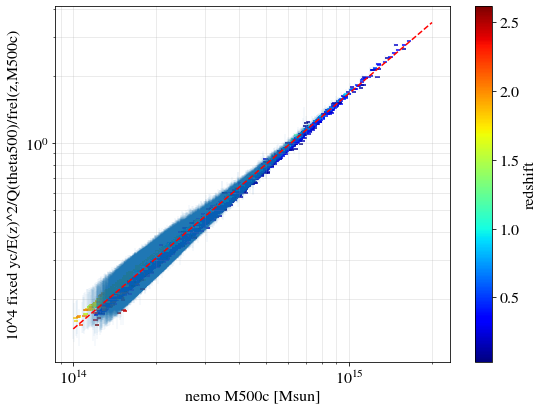

In [28]:
ax = df_nemo.plot(kind="scatter",x="M500c_nemo",y="fixed_y_c_over_e2z",c="redshift", cmap='jet',marker=1, sharex=False)

markers, caps, bars = plt.errorbar(df_nemo["M500c_nemo"], 
             df_nemo["fixed_y_c_over_e2z"], 
             yerr=df_nemo["fixed_err_y_c_over_e2z"],
             ls='None',
             marker='None',markersize=3.)

[bar.set_alpha(0.05) for bar in bars]
[cap.set_alpha(0.05) for cap in caps]


masses = np.geomspace(1e14,2e15,100)

plt.plot(masses,reduced_ym_relation(masses,1e4*popt[0],popt[1]),ls='--',c='r')



ax.set_ylabel(r"10^4 fixed yc/E(z)^2/Q(theta500)/frel(z,M500c)")
ax.set_xlabel(r"nemo M500c [Msun]")
ax.grid(which='both',alpha=0.3)
ax.loglog()
plt.tight_layout()

/usr/local/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2246: RuntimeWarning: overflow encountered in get_m200m_to_m500c_at_z_and_M (vectorized)
  outputs = ufunc(*inputs)


ValueError: A value in x_new is below the interpolation range.

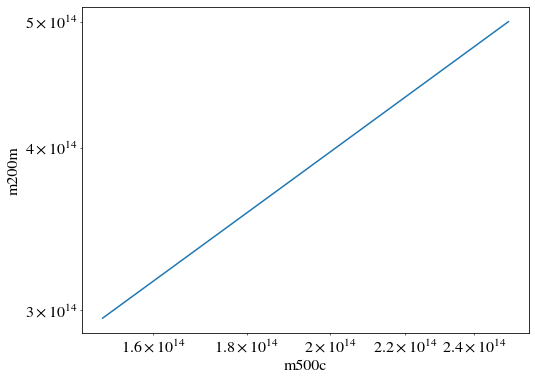

In [5]:
mm = np.geomspace(1e14,5e14)
m500c = np.vectorize(M.get_m200m_to_m500c_at_z_and_M)(1.e-5,mm*M.h())/M.h()
plt.plot(m500c,mm)
plt.loglog()
plt.xlabel('m500c')
plt.ylabel('m200m')
plt.grid()
from scipy import interpolate
f = interpolate.interp1d(m500c,mm)
f(1e14)